# Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru

# Описание проекта

Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%. 
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.

**Задачи:**

Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет. Оценка качества модели будет производиться с использованием precision и ROC-AUC.

В БД — есть “дубли заявок”. На одну заявку может быть только один “назначенный репетитор”, то есть репетитор, с которым случился обмен контактами. 

Если клиент хочет ещё с одним репетитором обменяться номерами, то мы создаём дубль заявки и назначаем репетитора на дубль, при этом в дубле создаётся запись original_order_id = номер первой заявки. Иногда консультанты создают новую заявку сами и не указывают, что эта заявка — дубль.

Для чего создается вторая заявка (дубль)? На случай, если репетитор не устраивает, не доступен или хочется просто получить ещё один номер или если сильно меняются условия заявки после уточнения консультантом.
Стоит помечать всю группу дублей таргетом - оплачено, если хотя бы один из дублей оплачен.

**Проблема постоянных изменений в заявке.**

Если заявка только только что создана, то мы знаем только параметры фильтров, по которым клиент ищет репетитора и подходящих репетиторов на заявку. Проходит 1-180 минут и за это время может произойти очень многое, что критично скажется на заявке: появятся отклики репетиторов, клиент выберет репетиторов из каталога , возможно даже создастся дубль заявки и с одним из репетиторов произойдет обмен номерами, консультант позвонит по заявке и уточнит требования к репетитору.

Если прогонять через модель один раз на свежую заявку, то можно довольно низкую метрику `precision`. Но хочется, чтобы с каждым новым действием по заявке метрика росла.

**Описание данных**
- данные с заявками (`orders`),
- данные по репетиторам (`teachers_info`),
- данные с подходящими по фильтру репетиторами (`suitable_teachers`).

**План работы:**
- загрузка и ознакомление с данными,
- предварительная обработка и отбор полезных признаков,
- разработка новых синтетических признаков,
- отбор финального набора обучающих признаков,
- разведочный анализ,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- выводы.

&copy; by Копцев Андрей [<img src="https://upload.wikimedia.org/wikipedia/commons/8/82/Telegram_logo.svg" alt="Telegram" width="17"/>](https://t.me/Andrei_VK_1980)

## Импорты

In [1]:
# системные модули
import gc
import os
import sys
import time
import warnings
from functools import wraps
# обработка данных и визуализация
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
# оформление выводов и процессво
from colorama import Back, Fore, Style
from pandarallel import pandarallel
from tqdm import tqdm
# корреляция
import phik
from phik.report import plot_correlation_matrix
# статистики
from scipy.stats import kurtosis, skew
# разбиение на выборки, кроссвалидация и масштабирование
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, StandardScaler
# модели
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
# метрики
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
# подбор гиперпараметров
import optuna
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler
# отбор признаков
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

warnings.filterwarnings("ignore")

**Переменные**

In [2]:
RANDOM = 12345
# рабочая директория проекта
WORK_DIR = os.path.abspath(os.curdir)
# директория c датасетами
DATA_DIR = os.path.join(WORK_DIR, "datasets")
# директория cо списками ключевых слов
LST_DIR = os.path.join(WORK_DIR, "data")
# файлы с данными для датасетов
ORDER_FILE = "orders.feather"
TEACHERS_INFO_FILE = "teachers_info.feather"
PREFERED_TEACHERS_ORDER_FILE = "prefered_teachers_order_id.feather"
SUITABLE_TEACHERS_FILE = "suitable_teachers.feather"

**Временной декоратор**

Для подстета времени выполнения методов обработки и моделирования, можно использовать временной декоратор реализованный в виде класса `TimeitDecorator`.

In [3]:
class TimeitDecorator:
    """
    Класс для декоратора, который измеряет время выполнения функции.
    """

    def timeit(func):
        """
        Декоратор, который измеряет время выполнения функции.

        Параметры:
        - func: функция, для которой измеряется время выполнения

        Возвращает:
        - wrapper: обертка, которая измеряет время выполнения функции
        """

        @wraps(func)
        def wrapper(*args, **kwargs):
            """
            Обертка, которая измеряет время выполнения функции.

            Параметры:
            - args: позиционные аргументы функции
            - kwargs: именованные аргументы функции

            Возвращает:
            - result: результат выполнения функции
            """
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Время выполнения: {round(end_time - start_time, 2)} секунд(ы){Style.RESET_ALL}"
            )

            return result

        return wrapper

## Загрузка датасетов

Для загрузки датасетов создается класс `GetDataframe`, который будет загружать датасет и выводить первичную информацию по нему.

In [4]:
class GetDataframe:
    """
    Класс для работы с датасетами.

    Методы класса:
    - get_dataframe_from_feather : метод создает датасет из файла формата feather.
    - get_dataframe_info: метод выводит информацию о датасете и пропущенных значениях.
    - is_accessible (staticmethod): статический метод для проверки доступности файлов в режиме чтения.
    - check_type (staticmethod): статический метод для типа переменной на строковое значение и ненулевую длину.
    """

    def __init__(self, data_dir):
        """
        Конструктор класса GetDataframe.

        Параметры:
        - data_dir (str): директория с данными для датасета.
        """
        self.data_dir = data_dir

    @staticmethod
    def is_accessible(file, data_dir, mode="r"):
        """
        Статический метод is_accessible класса GetDataframe.
        Проверка, является ли файл в рабочей директории доступным для работы в предоставленном режиме.

        Параметры:
        - file (str): файл с данными для датасета,
        - data_dir (str): рабочая директория с файлами для датасета,
        - mode (str): режим доступа к файлу, по умолчанию 'r' - чтение.

        Возвращает:
        - Boolean: True или False.
        """
        try:
            f = open(os.path.join(data_dir, file), mode)
            f.close()
        except IOError:
            return False
        return True

    @staticmethod
    def check_type(file_to_check):
        """
        Статический метод check_type класса GetDataframe.
        Проверяет тип переменной на строковое значение и ненулевую длину.

        Параметры:
        - file_to_check: переменная для проверки.

        Возвращает:
        - Boolean: True если проверка пройдена.
        """
        if not isinstance(file_to_check, str):
            raise TypeError(f"Тип переменной должен быть str. Датасет не будет создан.")
        if len(file_to_check) == 0:
            raise ValueError(
                f"Имя файла не должно быть пустым. Датасет не будет создан."
            )
        else:
            return True

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def get_dataframe_from_feather(self, file=None):
        """
        Создает датасет из файла формата feather.

        Параметры:
        - file (str): имя файла для создания датасета.

        Возвращает:
        - dataset: созданный датасет.
        """
        # вызов статического метода проверки типа переменной
        check_file = GetDataframe.check_type(file)
        # вызов статического метода проверки читаемости файла
        flag = GetDataframe.is_accessible(file, self.data_dir)
        # если оба True
        if all([check_file, flag]):
            # создаем датасет
            print(
                f"{Fore.RED}{Style.BRIGHT}Создаем датасет из файла {file}...{Style.RESET_ALL}"
            )
            dataset = pd.read_feather(os.path.join(self.data_dir, file))
            # присваиваем имя датасету в соответсвии с именем файла
            dataset.name = re.findall("(\w+)\.", file)[0]
            print(f"{Fore.GREEN}{Style.BRIGHT}Датасет создан!{Style.RESET_ALL}")
            return dataset
        # в противном случай вызываем ошибку
        else:
            raise ValueError(f"Файл {file} не найден в директории {self.data_dir}.")

    def get_dataframe_info(self, dataset=None, info=True, miss_values=True):
        """
        Выводит информацию о датасете и пропущенных значениях.

        Параметры:
        - dataset: датасет для анализа,
        - info (bool): выводить информацию о датасете (по умолчанию True),
        - miss_values (bool): выводить информацию о пропущенных значениях (по умолчанию True).
        """
        # если выбран флаг info, выводим информацию о датасете
        if info:
            print(
                f"{Fore.RED}{Style.BRIGHT}Общая информация по датасету{Style.RESET_ALL}"
            )
            dataset.info()
            print()
        # если выбран флаг miss_values, считаем пропуски в столбцах
        if miss_values:
            percentage_missing = (dataset.isna().sum() / len(dataset)) * 100
            dataset_miss = pd.DataFrame({"percent_missing": percentage_missing})
            dataset_miss = dataset_miss.loc[dataset_miss["percent_missing"] > 0]
            # если в датасете нету пропусков
            if len(dataset_miss) == 0:
                print(
                    f"{Fore.GREEN}{Style.BRIGHT}В датасете нет пропущенных значений.{Style.RESET_ALL}"
                )
            # если они есть
            else:
                print(
                    f"{Fore.RED}{Style.BRIGHT}Столбцы с пропущенными значениями:{Style.RESET_ALL}"
                )
                display(dataset_miss)

**Экземпляр класса для загрузки датасета**

In [5]:
df_loader = GetDataframe(DATA_DIR)

### Загрузка датасета с заявками - `orders`

In [6]:
orders = df_loader.get_dataframe_from_feather(file=ORDER_FILE)

Создаем датасет из файла orders.feather...
Датасет создан!
Время выполнения: 3.58 секунд(ы)


**Информация по датасету**

In [7]:
df_loader.get_dataframe_info(dataset=orders)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id

,percent_missing
subject_id,0.866880
purpose,13.970589
lesson_place,99.997399
home_metro_id,46.097154
add_info,12.348168
start_date,40.800311
working_teacher_id,40.765911
comments,71.350015
prefered_teacher_id,99.999664
first_lesson_date,86.024293


Датасет загружен. Присуствует достаточное количество столцов с пропущенными значениями, которые будут обработаны в первиной обработке.

### Загрузка датасета с учителями - `teachers_info`

In [8]:
teachers_info = df_loader.get_dataframe_from_feather(file=TEACHERS_INFO_FILE)

Создаем датасет из файла teachers_info.feather...
Датасет создан!
Время выполнения: 3.17 секунд(ы)


**Информация по датасету**

In [9]:
df_loader.get_dataframe_info(dataset=teachers_info)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   3

,percent_missing
external_comments,70.459003
status_relevant_date,84.940514
status_school_id,95.170665
status_college_id,97.875456
information,56.823348
external_comments.1,70.459003
status_relevant_date.1,84.940514
status_school_id.1,95.170665
status_college_id.1,97.875456
information.1,56.823348


Датасет загружен. Присуствует достаточное количество столцов с пропущенными значениями и столбцы с двойными названиями, которые будут обработаны в первиной обработке.

### Загрузка датасета с доступными учителями - `suitable_teachers`

In [10]:
suitable_teachers = df_loader.get_dataframe_from_feather(file=SUITABLE_TEACHERS_FILE)

Создаем датасет из файла suitable_teachers.feather...
Датасет создан!
Время выполнения: 0.46 секунд(ы)


**Информация по датасету**

In [11]:
df_loader.get_dataframe_info(dataset=suitable_teachers)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB

Столбцы с пропущенными значениями:


,percent_missing
contact_result,63.263995


Датасет загружен. Есть столбец с пропусками.

## Первичная обработка датасетов

### Датасет `orders`

In [12]:
orders.head(5)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к заявке № 2294000"" (Алешина Марина)",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ученика: студентка 1 курса.\nЦель занятий: помощь ...,800,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype). Время МСК.\nПредполагаемое число занят...",2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: помощь по школьно...,700,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю...",2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


Сразу видно два текстовых столбца `purpose` с целями занятий, катеториями учеников и `add_info` с местом проведения занятий, опытом, возрастом, статусом репетитора, которы нужно почистить. 

Помимо этого нужно обратобать пропуски:
- Столбцы с пропусками, где их более 70% можно вообще удалить.
- Заменить пропуски в числовых признаках.
- Заменить пропуски в текстах.

Помимо этого нужно выделить целевой признак из столбца `status_id`. Согласно ТЗ:
- Статус = `1` - Заявка не обработана. 
- Статус = `2` - Контактный телефон отдан клиенту. 
- Статус = `3` - Проверена. 
- Статус = `4` - Контактный телефон отдан преподавателю. 
- Статус = `5` - Проведено первое занятие. 
- Статус = `6` - Оплачена. 
- Статус = `7` - Снята. 
- Статус = `8` - Отложена. 
- Статус = `9` - Договорились о занятиях. 
- Статус = `11` - Созвонились. 
- Статус = `12` - !!! Не оплачена !!! 
- Статус = `13` - Произведена оплата. 
- Статус = `14` - Оплачена 25/50%. 
- Статус = `15` - Подлежит оплате. 
- Статус = `16` - Снята.

К статусам оплаченных заявок можно отнести статусы: `6`, `13` и `14`, то есть это `target` = `1`, в противном случае `0`.

Плюс ко всему можно будет удалить некоторые столбцы, которые могут влиять на целевой признак, буть заполнены не учеником или просто не понадобятся в данном исследовании. Удалены будут: `order_date`,
`start_date`, `working_teacher_id`, `amount_to_pay`, `creator_id`, `additional_status_id`,` estimated_fee`. 

### Датасет `teachers_info`

In [13]:
teachers_info.sample(5)

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
104478,106946,2023-01-19 16:44:13.987,2016-07-08 08:37:54.000,2016-07-08 00:00:00.000,1899-09-01 00:00:00.000,150208,0,0,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,1,NaN,60,0,5,NaN,NaN,NaN,0,0,7,РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,1,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,1,0,25,-300,NaN,2014-08-12 00:00:00.000,NaN,NaN,1,0.0,63,NaN,0,0,0,NaN,0,0,0,25.0,0.0,NaN,1,1,0.0,0,NaN,NaN,4.300781,25.0,0,2017-01-01 00:00:00.000,1,NaN,NaN
293037,297670,2023-10-20 16:47:46.633,2023-07-03 11:27:05.567,1999-02-21 00:00:00.000,2020-09-01 00:00:00.000,1219364,0,0,1,NaN,45,0,5,NaN,NaN,NaN,1,5,7,[p]Здравствуйте! Меня зовут Мария. Предлагаю индивидуальные занятия для учащихся 1-9 классов по ...,1,NaN,45,0,5,NaN,NaN,NaN,1,5,7,[p]Здравствуйте! Меня зовут Мария. Предлагаю индивидуальные занятия для учащихся 1-9 классов по ...,1,NaN,45,0,5,NaN,NaN,NaN,1,5,7,/teachers/297670/photo/photo_small.jpg,[p]Здравствуйте! Меня зовут Мария. Предлагаю индивидуальные занятия для учащихся 1-9 классов по ...,1,1,15,5,NaN,2023-07-03 11:27:05.567,NaN,NaN,0,0.0,31,NaN,2,0,1,NaN,1,1,1,450.0,0.0,NaN,0,1,124.0,0,NaN,NaN,4.300781,450.0,0,2023-07-03 11:27:05.567,1,NaN,NaN
266023,270648,2023-08-26 16:27:33.260,2022-09-02 20:20:43.287,2003-10-11 00:00:00.000,2022-05-01 00:00:00.000,715137,0,0,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,NaN,0,1,1,0,NaN,2022-09-02 20:20:43.287,2022-09-02 20:20:44.253,NaN,0,0.0,1,NaN,2,0,0,NaN,1,1,1,0.0,0.0,NaN,0,0,0.0,0,NaN,NaN,4.300781,0.0,0,2022-09-02 20:20:43.287,1,NaN,NaN
81147,83551,2023-01-19 19:04:58.470,2015-03-04 13:47:04.000,1987-04-20 00:00:00.000,2011-09-01 00:00:00.000,84866,0,1,1,NaN,60,10,5,NaN,NaN,NaN,0,0,7,NaN,1,NaN,60,10,5,NaN,NaN,NaN,0,0,7,NaN,1,NaN,60,10,5,NaN,NaN,NaN,0,0,7,NaN,NaN,1,0,10,-10,NaN,2014-08-12 00:00:00.000,NaN,NaN,0,0.0,2,NaN,2,0,1,NaN,0,1,1,0.0,0.0,NaN,1,1,0.0,0,NaN,NaN,4.300781,0.0,0,2017-01-01 00:00:00.000,1,NaN,NaN
121712,125102,2023-01-19 00:55:13.007,2017-08-21 02:53:42.000,1979-07-21 00:00:00.000,2006-09-01 00:00:00.000,264152,0,0,1,Ближайший район: м. Звенигородская.,45,600,4,NaN,NaN,2364.0,0,5,7,Кандидат философских наук (2008 год).,1,Ближайший район: м. Звенигородская.,45,600,4,NaN,NaN,2364.0,0,5,7,Кандидат философских наук (2008 год).,1,Ближайший район: м. Звенигородская.,45,600,4,NaN,NaN,2364.0,0,5,7,/teachers/125102/photo/photo_small.webp,Кандидат философских наук (2008 год).,1,1,15,5,NaN,2018-05-17 19:18:29.403,2022-06-08 22:11:41.947,NaN,0,0.0,2,NaN,1,0,1,NaN,1,1,1,150.0,0.0,NaN,1,1,2256.0,0,0.0,NaN,4.300781,150.0,0,2017-08-21 02:53:42.000,1,2364.0,NaN


В датасете присутсвуют столбцы типа: `lesson_duration` и `lesson_duration.1` их можно проверить на равенство: 

In [14]:
print(
    list(teachers_info["lesson_duration"]) == list(teachers_info["lesson_duration.1"])
)

True


Как видим столбцы одинаковые, значит дубли этих столбцов можно удалить.

Помимо этого можно создать признаки:
- возраст из разницы текущей даты и даты рождения. 
- стаж учителя из разницы текущей даты и даты начала преподавания.
- наличие фото согласно признаку `photo_path`.

Помимо этого нужно обратобать пропуски:
- Столбцы с пропусками, где их более 70% можно вообще удалить.
- Заменить пропуски в числовых признаках.

Плюс ко всему можно будет удалить некоторые столбцы, которые могут не понадобятся в данном исследовании. Удалены будут: `date_update`, `reg_date`, `birth_date`, `teaching_start_date`, `user_id`,
`photo_path`, `rules_confirmed_date`, `last_visited`, `relevance_date`, `information`, `amount_to_pay`, `is_email_confirmed`, `is_home_lessons`, `is_external_lessons`, `status_id`,
`status_display`, `russian_level_id`, `home_country_id`, `is_confirmed`, `is_display`, `rating_id`, `is_cell_phone_confirmed`, `area_id`, `sex`, `is_remote_lessons`, `show_on_map`,
`send_mailing`, `rating_for_users_yesterday`, `send_suitable_orders`, `is_edited`, `verification_status_id`. 

### Датасет `suitable_teachers`

In [15]:
suitable_teachers.sample(5)

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
6692778,255082,2422700,1,0,0
10248605,280078,2575831,"Репетитор положил трубку, либо обрыв связи (Oktell)",1,0
18912553,188375,2905024,NaN,0,0
15427076,196002,2786704,NaN,0,0
13852369,218906,2723503,NaN,1,0


В этом датасете можно оставить строки со значением `enable_auto_assign = 1`, т.к. это автоматическое присваивание доступности учителя. Когда заявка приходит на обработку оператор в ручном режиме еще проставил доступность.

Плюс оставим для дальнейших действий только столбцы `teacher_id`, `order_id`.

Для обработки будет использован класс `DatasetPreprocessor`. Все методы класса описаны в докстрингах и комментариях к коду.

In [16]:
class DatasetPreprocessor:
    """
    Класс для предобработки датасета.

    Методы класса:
    - preprocess_dataset : метод для обработки датасетов.
    - check_type (staticmethod): статический метод для типа переменной на строковое значение и ненулевую длину.
    - drop_nan (staticmethod): статический метод для удаления столбцов с пропусками.
    - fill_numeric_nan (staticmethod): статический метод для заполнения пропущенных числовых значений.
    - fill_numeric (staticmethod): статический метод для заполнения пропущенных числовых значений.
    - clean_text_fields (staticmethod): статический метод для очистки текста.
    - cleaner (staticmethod): статический метод для очистки текста.
    - optim_mem_types (staticmethod): статический метод оптимизатор памяти.
    """

    def __init__(self):
        """
        Конструктор класса DatasetPreprocessor.
        """
        pass

    @staticmethod
    def check_type(lst_to_check):
        """
        Статический метод check_type класса  DatasetPreprocessor.
        Проверяет тип переменной на строковое значение и ненулевую длину.

        Параметры:
        - file_to_check: переменная для проверки.

        Возвращает:
        - Boolean: True если проверка пройдена.
        """

        if not isinstance(lst_to_check, list):
            raise TypeError(
                f"Не соответствует тип переменной , должен быть тип list. Обработка не будет выполнена."
            )
        if len(lst_to_check) == 0:
            raise ValueError(
                f"Список со столбцами для очистки пустой. Обработка не будет выполнена."
            )
        else:
            return True

    @staticmethod
    def drop_nan(dataset, threshold):
        """
        Статический метод drop_nan класса  DatasetPreprocessor.
        Удаляет столбцы, в которых пропусков более определенного порога в процентах.

        Параметры:
        - dataset (pd.DataFrame): исходный датасет.
        - threshold (int): порог в процентах

        Возвращает:
        - dataset (pd.DataFrame): обработанный датасет.
        """
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Удаляем столбцы, в которых более {threshold}% пропущенных значений.{Style.RESET_ALL}"
        )
        # подсчет в процентах пропусков
        percentage_missing = (dataset.isnull().sum() / len(dataset)) * 100
        # индексы стобцов с пробусками более заданного порога
        columns_to_drop = percentage_missing[percentage_missing > threshold].index
        # удаление столбцов
        dataset = dataset.drop(columns=columns_to_drop)
        print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")

        return dataset

    @staticmethod
    def fill_numeric_nan(column):
        """
        Статический метод fill_numeric_nan класса  DatasetPreprocessor.
        Заполняет пропущенные числовые значения.

        Параметры:
        - column: столбец с пропущенными значениями.

        Возвращает:
        - column: столбец с заполненными значениями.
        """
        # проверка на тип данных столбца
        if (
            column.dtype.name[:5].lower() == "float"
            or column.dtype.name[:3].lower() == "int"
        ):
            # если минимум больше 0, то пропуск заполняем нулем
            if column.min() > 0:
                return column.fillna(0)
            # если минимум 0, то пропуск заполняем -1
            elif column.min() == 0:
                return column.fillna(-1)
            # в противном случае онимаем от минимума 2
            else:
                return column.fillna(column.min() - 2)
        return column

    @staticmethod
    def fill_numeric(dataset):
        """
        Статический метод fill_numeric класса  DatasetPreprocessor.
        Вызывает внутри себя статический метод fill_numeric_nan, применяемый
        к столбцу датасета.

        Параметры:
        - dataset (pd.DataFrame): исходный датасет.

        Возвращает:
        - dataset (pd.DataFrame): обработанный датасет.
        """

        tqdm.pandas(
            desc=f"{Fore.BLUE}{Style.BRIGHT}Заполнение пропусков в числовых признаках.{Style.RESET_ALL}"
        )
        # вызов статического метода fill_numeric_nan и применение его при попощи progress_apply из библиотеки tqdm
        dataset = dataset.progress_apply(DatasetPreprocessor.fill_numeric_nan)
        print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")

        return dataset

    @staticmethod
    def clean_text_fields(text):
        """
        Статический метод clean_text_fields класса  DatasetPreprocessor.
        Очищает текстовое поле от лишних символов.

        Параметры:
        - text: текст для очистки.

        Возвращает:
        - text: очищенный текст.
        """

        # проверка на то, что текст не пустой
        if pd.notna(text):
            # приводим к нижнему регистру
            text = text.lower()
            # удаляем [p]&nbsp;[/p] и прочее с помощью регулярного выражения
            text = re.sub(
                r"\[p\]|&nbsp;|\[/p\]|\[p\]|\[/li\]|\[li\]|\[/br\]||\[br/\]\[br\]|\[/ul\]|\[ul\]|\[/ol\]|\[ol\]|\u200a|\u200b",
                "",
                text,
            )
            # удаляем символы перевода строки и возврата каретки
            text = re.sub(r"[\r\n]", "", text)
            # удаляем перенос строки
            text = re.sub(r"\n", "", text)
            # замена двоеточия с пробелом перед ним на двоеточие
            text = re.sub(r" :", ":", text)
            # заменяем двойной пробел на одиночный
            text = re.sub(r"\s{2}", " ", text)
            # заменяем точки без пробела на точку с пробелом
            text = re.split(r"(?<=\w)\.", text)
            text = ". ".join(text)
            # в тексте может быть слитное написание "текстуровень знаний:", для этого эти ключевые слова
            # нужно разделить пробелом
            text = re.split(r"уровень знаний:", text)
            text = " уровень знаний: ".join(text)
            text = re.split(r"разделы:", text)
            text = " разделы: ".join(text)
            text = re.split(r"цели:", text)
            text = " цели: ".join(text)
            text = re.split(r"цель занятий:", text)
            text = " цель занятий: ".join(text)
            text = re.split(r"дополнения:", text)
            text = " дополнения: ".join(text)
            text = re.split(r"категория ученика:", text)
            text = " категория ученика: ".join(text)
            # заменяем двойной пробел на одиночный
            text = re.sub(r"\s{2}", " ", text)
            # обрезаем пробелы справа и слева
            text = text.strip()

            return text

    @staticmethod
    def cleaner(dataset, cols_to_clean):
        """
        Статический метод cleaner класса  DatasetPreprocessor.
        Вызывает внутри себя статический метод clean_text_fields, применяемый
        к столбцу датасета.

        Параметры:
        - dataset (pd.DataFrame): исходный датасет.
        - cols_to_clean (list): список со столбцами для очиски.

        Возвращает:
        - dataset (pd.DataFrame): обработанный датасет.
        """

        # вызов статического метода проверки типа переменной
        check = DatasetPreprocessor.check_type(cols_to_clean)
        # если True
        if check:
            # проходим циклом по списку столбцов
            for col in cols_to_clean:
                # проверяем наличие столбца в датасете, если нету вызываем ошибку
                if col not in dataset.columns:
                    raise ValueError(
                        f"Столбца {col} нету в датасете. Обработка не будет выполнена."
                    )
                # если есть
                else:
                    # присваииваем столбцу тип object
                    dataset[col] = dataset[col].astype("object")
                    # заполняем пропуски на "Нет информации"
                    dataset[col] = dataset[col].fillna("Нет информации")
                    print(
                        f"{Fore.BLUE}{Style.BRIGHT}Очистка текста в столбце {col}.{Style.RESET_ALL}"
                    )
                    pandarallel.initialize(progress_bar=True)
                    # применяем статический метод clean_text_fields при помощи parallel_apply из библиотеки pandarallel
                    dataset[col] = dataset[col].parallel_apply(
                        DatasetPreprocessor.clean_text_fields
                    )
                    print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
            return dataset

    @staticmethod
    def optim_mem_types(dataset):
        """
        Статический метод optim_mem_types класса DatasetPreprocessor.
        Перебирает все столбцы датафрейма и изменяет тип данных, чтобы
        уменьшить использование памяти.
        Параметры:
        - dataset (pd.DataFrame): исходный датасет.

        Возвращает:
        - dataset (pd.DataFrame): обработанный датасет.
        """

        print(
            f"{Fore.YELLOW}{Style.BRIGHT}Оптимизация типов и памяти.{Style.RESET_ALL}"
        )
        # глубокая копия датасета
        dataset_opt = dataset.copy(deep=True)
        # подсчет начального объема датасета
        start_mem = round(dataset_opt.memory_usage().sum() / 1024**2, 4)
        print(
            f"{Fore.BLACK}{Style.BRIGHT}Память занимаемая датасетом в ОП до обработки: {start_mem} MB.{Style.RESET_ALL}"
        )
        # цикл по колонкам в датасете
        for col in dataset_opt.columns:
            # проверка на то, что столбец числовой
            if dataset_opt[col].dtype.name not in ["object", "category", "datetime"]:
                # проверка на то, что в типе float после запятой только нули
                if dataset_opt[col].dtype.name[:5].lower() == "float":
                    # создаем временный датасет без пропусков
                    tmp = dataset_opt.loc[dataset_opt[col].notna()]
                    # список с масками, что после запятой нули
                    decimal_check = (tmp[col] % 1 == 0).tolist()
                    # если все значения списка True
                    if all(decimal_check):
                        # то переводи в тип Int64, который не критичен к nan
                        dataset_opt[col] = dataset_opt[col].astype("Int64")
                    # удаляем промежуточный датасет
                    del tmp
                # минимум и максимум в столбце
                c_min = dataset_opt[col].min()
                c_max = dataset_opt[col].max()
                #  проверка на тип int
                if dataset_opt[col].dtype.name[:3].lower() == "int":
                    # если тип int, то присваиваются значения в зависимости от диапазона от min до max
                    if (
                        c_min >= np.iinfo(np.int8).min
                        and c_max <= np.iinfo(np.int8).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.int8)
                    elif (
                        c_min >= np.iinfo(np.int16).min
                        and c_max <= np.iinfo(np.int16).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.int16)
                    elif (
                        c_min >= np.iinfo(np.int32).min
                        and c_max <= np.iinfo(np.int32).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.int32)
                    elif (
                        c_min >= np.iinfo(np.int64).min
                        and c_max <= np.iinfo(np.int64).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.int64)
                # # если тип float, то присваиваются значения в зависимости от диапазона от min до max
                else:
                    if (
                        c_min >= np.finfo(np.float16).min
                        and c_max <= np.finfo(np.float16).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.float16)
                    elif (
                        c_min >= np.finfo(np.float32).min
                        and c_max <= np.finfo(np.float32).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.float32)
                    else:
                        dataset_opt[col] = dataset_opt[col].astype(np.float64)
            # если тип не дата, то оставшиеся столбцы в тип object
            elif "datetime" not in dataset[col].dtype.name:
                dataset_opt[col] = dataset_opt[col].astype("object")

        # новый объем датасета и возможная экономия в процентах
        end_mem = round(dataset_opt.memory_usage().sum() / 1024**2, 4)
        economy = round(100 * (start_mem - end_mem) / start_mem, 2)
        print(
            f"{Fore.BLACK}{Style.BRIGHT}Память занимаемая датасетом в ОП после обработки: {end_mem} MB.{Style.RESET_ALL}"
        )

        print(f"{Fore.GREEN}{Style.BRIGHT}Экономия {economy}%.{Style.RESET_ALL}")
        # если удалось оптимизировать
        if start_mem - end_mem >= 0:
            print(
                f"{Fore.GREEN}{Style.BRIGHT}Удалось оптимизировать типы и память или выйти по нулям.{Style.RESET_ALL}"
            )
            # сбока мусора
            gc.collect()
            return dataset_opt
        # в противном случае
        else:
            print(
                f"{Fore.RED}{Style.BRIGHT}Не удалось оптимизировать типы и память, оставляем исходный датасет.{Style.RESET_ALL}"
            )
            # сбока мусора
            del dataset_opt
            gc.collect()
            return dataset

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def preprocess_dataset(
        self,
        dataset=None,
        clean_text=False,
        cols_to_clean=None,
        drop_na=False,
        threshold=70,
        target=False,
        target_lst=None,
        fill_na=False,
        optimizer=False,
        drop_cols=False,
        cols_to_drop=None,
    ):
        """
        Метод preprocess_dataset класса DatasetPreprocessor для обработки датасетов.

        Параметры:
        - dataset (pd. Dataframe): обработанный датафрейм Pandas (по умолчанию None).
        - clean_text (Boolean): флаг для вызова статического метода cleaner (по умолчанию False).
        - cols_to_clean (list): список столбцов для очистки (по умолчанию None).
        - drop_na (Boolean): флаг для вызова статического метода drop_nan (по умолчанию False).
        - threshold (int): порог для удаления столбцов с пропусками для метода drop_nan (по умолчанию 70).
        - target (Boolean): флаг для создания целевой переменной (по умолчанию False).
        - target_lst (list): спискок значений категорий для целевой переменной (по умолчанию None).
        - fill_na (Boolean): флаг для вызова статического метода cleaner (по умолчанию False).
        - optimizer (Boolean): флаг для вызова статического метода optim_mem_types (по умолчанию False).
        - drop_cols (Boolean): флаг для удаления столбцов (по умолчанию False).
        - cols_to_drop (list): спесик столбцов для удаления (по умолчанию None).

        Возвращает:
        - dataset (pd. Dataframe): обработанный датафрейм Pandas.
        """

        print(
            f"{Fore.YELLOW}{Style.BRIGHT}Обработка датасета: {dataset.name}\n{Style.RESET_ALL}"
        )
        # обработка датасета orders
        if dataset.name == "orders":
            # удаляем строки с аномальными значениями, в результате закгрузки из БД образовались
            # аномальные строки, их можно отсечь по status_id < 16
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Удаляем строки с аномальными значениями.{Style.RESET_ALL}"
            )
            dataset = dataset.loc[dataset["status_id"] <= 16]
            print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
            # переименование "id" в "order_id"
            dataset = dataset.rename(columns={"id": "order_id"})
            # если True
            if clean_text:
                # вызов статического метода cleaner для очистки текста
                dataset = DatasetPreprocessor.cleaner(dataset, cols_to_clean)
            # если True
            if drop_na:
                # вызов статического метода drop_nan для удаления столбцов с пропусками по порогу
                dataset = DatasetPreprocessor.drop_nan(dataset, threshold)
            # если True
            if target:
                # выделяем целевой признак на основании status_id и списка статусов из target_lst
                tqdm.pandas(
                    desc=f"{Fore.BLUE}{Style.BRIGHT}Создаем целевую переменную.{Style.RESET_ALL}"
                )
                dataset["target"] = dataset["status_id"].progress_apply(
                    lambda x: 1 if x in target_lst else 0
                )
                # удаляем status_id
                dataset = dataset.drop(["status_id"], axis=1)
                print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
            # если True
            if fill_na:
                # вызов статического метода fill_numeric для заполнения пропусков в числовых столбцах
                dataset = DatasetPreprocessor.fill_numeric(dataset)
            # если True
            if drop_cols:
                # вызов статического метода check_type проверки типа переменной
                check = DatasetPreprocessor.check_type(cols_to_drop)
                # если True
                if check:
                    # удаляем столбцы из списка
                    dataset = dataset.drop(cols_to_drop, axis=1).reset_index(drop=True)
            # если True
            if optimizer:
                # вызов статического метода optim_mem_types для оптимизации памяти
                dataset = self.optim_mem_types(dataset)
            # присваиваем датасету имя
            dataset.name = "orders"
        # обработка датасета teachers_info
        elif dataset.name == "teachers_info":
            # удаляем столбцы дубликаты
            tqdm.pandas(
                desc=f"{Fore.BLUE}{Style.BRIGHT}Удаляем столбцы дубликаты.{Style.RESET_ALL}"
            )
            dataset = dataset.loc[
                :, ~dataset.progress_apply(lambda x: x.duplicated(), axis=1).all()
            ]
            # # переименование "id" в "teacher_id"
            dataset = dataset.rename(columns={"id": "teacher_id"})
            # создаем столбуч с наличием фото на основании пути в фото из photo_path
            dataset["is_photo"] = dataset["photo_path"].apply(
                lambda x: 1 if not pd.isnull(x) else 0
            )

            print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
            # если True
            if clean_text:
                # вызов статического метода cleaner для очистки текста
                dataset = DatasetPreprocessor.cleaner(dataset, cols_to_clean)
            # если True
            if drop_na:
                # вызов статического метода drop_nan для удаления столбцов с пропусками по порогу
                dataset = DatasetPreprocessor.drop_nan(dataset, threshold)
            # если True
            if fill_na:
                # вызов статического метода fill_numeric для заполнения пропусков в числовых столбцах
                dataset = DatasetPreprocessor.fill_numeric(dataset)

            print(
                f"{Fore.BLUE}{Style.BRIGHT}Создаем столбцы с возрастом, опытом у учителя.{Style.RESET_ALL}"
            )
            # преобразуем столбцы в формат datetime
            dataset["birth_date"] = pd.to_datetime(dataset["birth_date"])
            dataset["teaching_start_date"] = pd.to_datetime(
                dataset["teaching_start_date"]
            )
            # вычисляем возраст и стаж учителя
            dataset["teacher_age"] = (
                pd.to_datetime("now").year - dataset["birth_date"].dt.year
            )
            dataset["teacher_experience"] = (
                pd.to_datetime("now").year - dataset["teaching_start_date"].dt.year
            )
            print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
            # если True
            if drop_cols:
                # вызов статического метода check_type проверки типа переменной
                check = DatasetPreprocessor.check_type(cols_to_drop)
                # если True
                if check:
                    # удаляем столбцы из списка
                    dataset = dataset.drop(cols_to_drop, axis=1)
            # если True
            if optimizer:
                # вызов статического метода optim_mem_types для оптимизации памяти
                dataset = DatasetPreprocessor.optim_mem_types(dataset)
            # присваиваем датасету имя
            dataset.name = "teachers_info"
        # обработка датасета suitable_teachers
        elif dataset.name == "suitable_teachers":
            # оставляем только автоматичекую доступнусть учителя
            dataset = dataset.loc[dataset["enable_auto_assign"] == 1]
            # если True
            if drop_na:
                # вызов статического метода drop_nan для удаления столбцов с пропусками по порогу
                dataset = DatasetPreprocessor.drop_nan(dataset, threshold)
            # если True
            if clean_text:
                # вызов статического метода cleaner для очистки текста
                dataset = DatasetPreprocessor.cleaner(dataset, cols_to_clean)
            # если True
            if drop_cols:
                # вызов статического метода check_type проверки типа переменной
                check = DatasetPreprocessor.check_type(cols_to_drop)
                # если True
                if check:
                    # удаляем столбцы из списка
                    dataset = dataset.drop(cols_to_drop, axis=1)
            # если True
            if optimizer:
                # вызов статического метода optim_mem_types для оптимизации памяти
                dataset = DatasetPreprocessor.optim_mem_types(dataset)
            # присваиваем датасету имя
            dataset.name = "suitable_teachers"
        # обработка датасета prefered_teachers_order_id
        elif dataset.name == "prefered_teachers_order_id":
            # если True
            if drop_cols:
                # вызов статического метода check_type проверки типа переменной
                check = DatasetPreprocessor.check_type(cols_to_drop)
                # если True
                if check:
                    # удаляем столбцы из списка
                    dataset = dataset.drop(cols_to_drop, axis=1)
            # если True
            if optimizer:
                # вызов статического метода optim_mem_types для оптимизации памяти
                dataset = DatasetPreprocessor.optim_mem_types(dataset)
            # присваиваем датасету имя
            dataset.name = "prefered_teachers_order_id"
        else:
            print(
                f"{Fore.RED}{Style.BRIGHT}Нету датасетов для обработки.{Style.RESET_ALL}"
            )
        # сборщик мусора
        gc.collect()
        return dataset

**Создаем экзепляр класса**

In [17]:
preprocessor = DatasetPreprocessor()

**Обработка `orders`**

*Список столбцов для удаления*

In [18]:
order_cols_to_drop = [
    "order_date",
    "start_date",
    "working_teacher_id",
    "amount_to_pay",
    "creator_id",
    "additional_status_id",
    "estimated_fee",
]

*Получение обработанного датасета*

In [19]:
orders = preprocessor.preprocess_dataset(
    dataset=orders,
    clean_text=True,
    cols_to_clean=["purpose", "add_info"],
    drop_na=True,
    target=True,
    target_lst=[6, 13, 14],
    fill_na=True,
    optimizer=True,
    drop_cols=True,
    cols_to_drop=order_cols_to_drop,
)

Обработка датасета: orders

Удаляем строки с аномальными значениями.
Выполнено.
Очистка текста в столбце purpose.
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Выполнено.
Очистка текста в столбце add_info.
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Выполнено.
Удаляем столбцы, в которых более 70% пропущенных значений.
Выполнено.


Создаем целевую переменную.: 100%|██████████| 1191857/1191857 [00:01<00:00, 722865.74it/s]


Выполнено.


Заполнение пропусков в числовых признаках.: 100%|██████████| 32/32 [00:00<00:00, 45.83it/s] 


Выполнено.
Оптимизация типов и памяти.
Память занимаемая датасетом в ОП до обработки: 117.0744 MB.
Память занимаемая датасетом в ОП после обработки: 69.3354 MB.
Экономия 40.78%.
Удалось оптимизировать типы и память или выйти по нулям.
Время выполнения: 160.15 секунд(ы)


In [20]:
df_loader.get_dataframe_info(dataset=orders)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191857 entries, 0 to 1191856
Data columns (total 25 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   order_id                 1191857 non-null  int32 
 1   subject_id               1191857 non-null  int8  
 2   purpose                  1191857 non-null  object
 3   lesson_price             1191857 non-null  int32 
 4   lesson_duration          1191857 non-null  int16 
 5   home_metro_id            1191857 non-null  int16 
 6   add_info                 1191857 non-null  object
 7   planned_lesson_number    1191857 non-null  int8  
 8   pupil_category_new_id    1191857 non-null  int8  
 9   lessons_per_week         1191857 non-null  int8  
 10  minimal_price            1191857 non-null  int32 
 11  teacher_sex              1191857 non-null  int8  
 12  teacher_experience_from  1191857 non-null  int8  
 13  teacher_experience_to    119

Датасет обработан, пропуски и ненужные столбцы удалены, таргет сформирован, объем занимаемой памяти и типы данных оптимизированы.

**Обработка `teachers_info`**

*Список столбцов для удаления*

In [21]:
teachers_cols_to_drop = [
    "date_update",
    "reg_date",
    "birth_date",
    "teaching_start_date",
    "user_id",
    "photo_path",
    "rules_confirmed_date",
    "last_visited",
    "relevance_date",
    "information",
    "amount_to_pay",
    "is_email_confirmed",
    "is_home_lessons",
    "is_external_lessons",
    "status_id",
    "status_display",
    "russian_level_id",
    "home_country_id",
    "is_confirmed",
    "is_display",
    "rating_id",
    "is_cell_phone_confirmed",
    "area_id",
    "sex",
    "is_remote_lessons",
    "show_on_map",
    "send_mailing",
    "rating_for_users_yesterday",
    "send_suitable_orders",
    "is_edited",
    "verification_status_id",
]

*Получение обработанного датасета*

In [22]:
teachers_info = preprocessor.preprocess_dataset(
    dataset=teachers_info,
    drop_na=True,
    fill_na=True,
    optimizer=True,
    drop_cols=True,
    cols_to_drop=teachers_cols_to_drop,
)

Обработка датасета: teachers_info



Удаляем столбцы дубликаты.: 100%|██████████| 307972/307972 [00:43<00:00, 7115.43it/s] 


Выполнено.
Удаляем столбцы, в которых более 70% пропущенных значений.
Выполнено.


Заполнение пропусков в числовых признаках.: 100%|██████████| 43/43 [00:00<00:00, 474.51it/s]

Выполнено.
Создаем столбцы с возрастом, опытом у учителя.


Выполнено.
Оптимизация типов и памяти.
Память занимаемая датасетом в ОП до обработки: 12.6294 MB.
Память занимаемая датасетом в ОП после обработки: 9.105 MB.
Экономия 27.91%.
Удалось оптимизировать типы и память или выйти по нулям.
Время выполнения: 44.42 секунд(ы)


In [23]:
df_loader.get_dataframe_info(dataset=teachers_info)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   teacher_id          307972 non-null  int32  
 1   lesson_duration     307972 non-null  int16  
 2   lesson_cost         307972 non-null  int32  
 3   rating              307972 non-null  int32  
 4   effective_rating    307972 non-null  float16
 5   rating_for_users    307972 non-null  float16
 6   rating_for_admin    307972 non-null  float16
 7   orders_allowed      307972 non-null  int8   
 8   display_days        307972 non-null  float16
 9   star_rating         307972 non-null  float16
 10  review_num          307972 non-null  int16  
 11  is_photo            307972 non-null  int8   
 12  teacher_age         307972 non-null  int16  
 13  teacher_experience  307972 non-null  int8   
dtypes: float16(5), int16(3), int32(3), int8(3)
memory usage

Датасет обработан, пропуски и ненужные столбцы удалены, признаки созданы, объем занимаемой памяти и типы данных оптимизированы.

**Обработка `suitable_teachers`**

*Список столбцов для удаления*

In [24]:
suitable_teachers_cols_to_drop = [
    "contact_result",
    "enable_auto_assign",
    "enable_assign",
]

*Получение обработанного датасета*

In [25]:
suitable_teachers = preprocessor.preprocess_dataset(
    dataset=suitable_teachers,
    optimizer=True,
    drop_cols=True,
    cols_to_drop=suitable_teachers_cols_to_drop,
)

Обработка датасета: suitable_teachers

Оптимизация типов и памяти.
Память занимаемая датасетом в ОП до обработки: 39.935 MB.
Память занимаемая датасетом в ОП после обработки: 39.935 MB.
Экономия 0.0%.
Удалось оптимизировать типы и память или выйти по нулям.
Время выполнения: 0.36 секунд(ы)


In [26]:
df_loader.get_dataframe_info(dataset=suitable_teachers)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
Index: 2617178 entries, 0 to 20271185
Data columns (total 2 columns):
 #   Column      Dtype
---  ------      -----
 0   teacher_id  int32
 1   order_id    int32
dtypes: int32(2)
memory usage: 39.9 MB

В датасете нет пропущенных значений.


Датасет обработан, ненужные столбцы удалены.

## Генерация признаков и создание финального датасета

В датасете `orders` есть два столбца с текcтом: `purpose` и `add_info`.

In [27]:
orders["purpose"].iloc[2]

'разделы: начертательная геометрия. категория ученика: студентка 1 курса. цель занятий: помощь по программе.'

In [28]:
orders["add_info"].iloc[678]

'место проведения занятий: дистанционно (например, skype).предполагаемое число занятий в неделю: 2, среда после 17:00, воскресенье с 10:00. опыт репетитора: от 5 лет. возраст репетитора: от 30 лет. пол репетитора: не имеет значения. статус репетитора: школьный преподаватель.'

Из этих столбцов можно выделить признаки:
- из `purpose`:
    - цель занятий,
    - категория ученика.
- из `add_info`:
    - место проведения занятий,
    - опыт репетитора,
    - статус репетитора,
    - возраст репетирора начальный,
    - возраст репетитора конечный.
Далее категории будут перекодированы в числовые значения.

Далее нужно заполнить целевой признак на 1, если у оригинала заявки стоит 0, а у каких-то дублей есть таргет = 1. Всю группу как 1 помечать не буду, т.к. в финальном датасете будет создана агрегированная заявка.

Следующим этапом будут объединены таблицы `suitable_teachers` и `teachers_info` по `teacher_id`.

Т.к. при объединении может получиться так что на одну заявку с уникальным `order_id` может быть несколько учителей с `teacher_id`, то можно сождать агрегированны портрет учителя и получится одна заявка - один портрет учителя. 
Для портрета учителя будут использованы след. признаки: 
- `teacher_id`: будет преобразован в `max_teachers` методом `count`,
- `teacher_age`: будет преобразован в `min_teacher_age` методом `min`,
- `teacher_age`: будет преобразован в `max_teacher_age` методом `max`,
- `teacher_experience`: будет преобразован в `min_teacher_experience` методом `min`,
- `teacher_experience`: будет преобразован в `max_teacher_experience` методом `max`,
- `lesson_duration`: будет преобразован в `min_lesson_duration` методом `min`,
- `lesson_duration`: будет преобразован в `max_lesson_duration` методом `max`,  
- `lesson_cost`: будет преобразован в `min_lesson_cost` методом `min`,
- `lesson_cost`: будет преобразован в `max_lesson_cost` методом `max`,  
- `effective_rating`: будет преобразован в `min_effective_rating` методом `min`,
- `effective_rating`: будет преобразован в `max_effective_rating` методом `max`,  
- `rating_for_users`: будет преобразован в `min_rating_for_users` методом `min`,
- `rating_for_users`: будет преобразован в `max_rating_for_users` методом `max`,  
- `rating_for_admin`: будет преобразован в `min_rating_for_admin` методом `min`,
- `rating_for_admin`: будет преобразован в `max_rating_for_admin` методом `max`,
- `star_rating`: будет преобразован в `min_star_rating` методом `min`,
- `star_rating`: будет преобразован в `max_star_rating` методом `max`,  
- `orders_allowed`: будет преобразован в `min_orders_allowed` методом `min`,
- `orders_allowed`: будет преобразован в `max_orders_allowed` методом `max`, 
- `review_num`: будет преобразован в `min_review_num` методом `min`,
- `review_num`: будет преобразован в `max_review_num` методом `max`, 
- `display_days`: будет преобразован в `min_display_days` методом `min`,
- `display_days`: будет преобразован в `max_display_days` методом `max`,
- `is_photo`: будет преобразован в `is_photo` методом `max`.

При решении проблемы дублей за гипотезу можно принять реализацию агрегированной заявки, то есть если есть группа по `original_order_id` и `client_id`, в этой группе есть оригинал заявки 
с `original_order_id` = 0, и дальнейшими заявками где `original_order_id`, где `original_order_id` это `order_id` первой заявки.

Например для `client_id` = 928532.

Вариант `target` = 0 в группе. 

In [29]:
filtered_data = orders.iloc[[1051, 4612]]
filtered_data[["order_id", "original_order_id", "client_id", "target"]]

,order_id,original_order_id,client_id,target
1051,2295105,0,928532,0
4612,2298666,2295105,928532,0


Вариант `target` = 1 в группе. 

In [30]:
filtered_data = orders.iloc[[1104299, 1108150, 1191843]]
filtered_data[["order_id", "original_order_id", "client_id", "target"]]

,order_id,original_order_id,client_id,target
1104299,2192917,0,928532,1
1108150,2196777,2192917,928532,0
1191843,2280493,2192917,928532,1


Суть процесса следующая:
- `original_order_id` = 0, становится равным `order_id` и образуется группа по `original_order_id` и `client_id`.
- нумеруются заявки после сортировки по  `order_id` по возрастанию.
- если в 1 заявке таргет = 0, а в группе есть 1, то таргет первой заяви делаем как 1.

Есть заявки без дублей с таргетом = 1

In [31]:
orders.loc[
    orders["client_id"] == 1019606,
    ["order_id", "original_order_id", "client_id", "target"],
]

,order_id,original_order_id,client_id,target
1191793,2280443,0,1019606,1


Так как есть заявки одиночный и групповые с таргетом 1, то и возникла идея агрегированной заявки.
Агрегация будет по след признакам.

- `subject_id`: будет преобразован в `subject_id` методом `x.mode().iat[0]`,    
- `lesson_price`: будет преобразован в `lesson_price` методом `x.mode().iat[0]`,      
- `lesson_duration`: будет преобразован в `lesson_duration` методом `x.mode().iat[0]`,      
- `home_metro_id`: будет преобразован в `home_metro_id` методом `x.mode().iat[0]`,
- `planned_lesson_number`: будет преобразован в `planned_lesson_number` методом `x.mode().iat[0]`,  
- `pupil_category_new_id`: будет преобразован в `pupil_category_new_id` методом `x.mode().iat[0]`,  
- `lessons_per_week`: будет преобразован в `lessons_per_week` методом `x.mode().iat[0]`,
- `minimal_price`: будет преобразован в `minimal_price` методом `min`,  
- `teacher_sex`: будет преобразован в `teacher_sex` методом `x.mode().iat[0]`,
- `teacher_experience_from`: будет преобразован в `teacher_experience_from` методом `min`,
- `teacher_experience_to`: будет преобразован в `teacher_experience_to` методом `max`, 
- `lesson_place_new`: будет преобразован в `lesson_place_new` методом `x.mode().iat[0]`,
- `pupil_knowledgelvl`: будет преобразован в `pupil_knowledgelvl` методом `max`,
- `teacher_age_from`: будет преобразован в `teacher_age_from` методом `min`,
- `teacher_age_to`: будет преобразован в `teacher_age_to` методом `max`,
- `chosen_teachers_only`: будет преобразован в `chosen_teachers_only` методом `sum`,
- `no_teachers_available`: будет преобразован в `no_teachers_available` методом `sum`,
- `source_id`: будет преобразован в `source_id` методом `x.mode().iat[0]`,
- `is_display_to_teachers`: будет преобразован в `is_display_to_teachers` методом `max`,
- `target`: будет преобразован в `target` методом `max`,
- `clean_purpose`: будет преобразован в `clean_purpose` методом `x.mode().iat[0]`,
- `category`: будет преобразован в `category` методом `x.mode().iat[0]`,
- `place`: будет преобразован в `place` методом `x.mode().iat[0]`,
- `prefered_teacher_age_from`: будет преобразован в `prefered_teacher_age_from` методом `min`,
- `prefered_teacher_age_to`: будет преобразован в `prefered_teacher_age_to` методом `max`,
- `expirience`: будет преобразован в `expirience` методом `x.mode().iat[0]`,
- `status`: будет преобразован в `status` методом `x.mode().iat[0]`,
- `max_teachers`: будет преобразован в `teachers` методом `count`,
- `min_teacher_age`: будет преобразован в `min_teacher_age` методом `min`,
- `max_teacher_age`: будет преобразован в `max_teacher_age` методом `max`,
- `min_teacher_experience`: будет преобразован в `min_teacher_experience` методом `min`,
- `max_teacher_experience`: будет преобразован в `max_teacher_experience` методом `max`,
- `min_lesson_duration`: будет преобразован в `min_lesson_duration` методом `min`,
- `max_lesson_duration`: будет преобразован в `max_lesson_duration` методом `max`,  
- `min_lesson_cost`: будет преобразован в `min_lesson_cost` методом `min`,
- `max_lesson_cost`: будет преобразован в `max_lesson_cost` методом `max`,  
- `min_effective_rating`: будет преобразован в `min_effective_rating` методом `min`,
- `max_effective_rating`: будет преобразован в `max_effective_rating` методом `max`,  
- `min_rating_for_users`: будет преобразован в `min_rating_for_users` методом `min`,
- `max_rating_for_users`: будет преобразован в `max_rating_for_users` методом `max`,  
- `min_rating_for_admin`: будет преобразован в `min_rating_for_admin` методом `min`,
- `max_rating_for_admin`: будет преобразован в `max_rating_for_admin` методом `max`,
- `min_star_rating`: будет преобразован в `min_star_rating` методом `min`,
- `max_star_rating`: будет преобразован в `max_star_rating` методом `max`,  
- `min_orders_allowed`: будет преобразован в `min_orders_allowed` методом `min`,
- `max_orders_allowed`: будет преобразован в `max_orders_allowed` методом `max`, 
- `min_review_num`: будет преобразован в `min_review_num` методом `min`,
- `max_review_num`: будет преобразован в `max_review_num` методом `max`, 
- `min_display_days`: будет преобразован в `min_display_days` методом `min`,
- `max_display_days`: будет преобразован в `max_display_days` методом `max`,
- `is_photo`: будет преобразован в `is_photo` методом `max`.

Значение моды для признаков нужно, т.к. в группе они просто могут быть в большинстве одинаковые.

Далее заполняем нулями признаки, которые присоединились от учителей, т.к. в датасете не на любую заявку есть учителя.

Для продедуры будет использован класс `FeaturesDatasetGenerator`.

In [32]:
class FeaturesDatasetGenerator:
    """
    Класс для генерации новых признаков и создания финального датасета.

    Методы класса:
    - orders_engeneering: cоздает новые признаки в датасете orders.
    - get_final_dataset: cоздает финальный датасет.
    - get_lst_from_txt_file (staticmethod): статический метод читает данные из текстового файла и возвращает список строк.
    - load_data (staticmethod): статический метод загружает данные из текстовых файлов и создает переменные с данными.
    - extract_purpose (staticmethod): статический метод извлекает цель занятий на основе предоставленного текста.
    - extract_category (staticmethod): статический метод извлекает категорию ученика на основе предоставленного текста.
    - extract_place (staticmethod): статический метод извлекает место на основе предоставленного текста.
    - extract_teacher_age_from (staticmethod): статический метод извлекает начальный возраст преподавателя на основе предоставленного текста.
    - extract_teacher_age_to (staticmethod): статический метод извлекает конечный возраст преподавателя на основе предоставленного текста.
    - extract_expirience (staticmethod): статический метод извлекает опыт преподавателя на основе предоставленного текста.
    - extract_status (staticmethod): статический метод извлекает статус преподавателя на основе предоставленного текста.
    - fill_target_by_orig_order_id (staticmethod): статический метод заполняет значения целевой переменной на 1, если в дублях есть 1.
    - coder (staticmethod): статический метод  кодирует значения столбцов из списка 'cols_to_code' датасета 'dataset', заменяя их на целочисленные коды.
    """

    def __init__(self):
        """
        Конструктор класса FeaturesDatasetGenerator.
        """
        pass

    global LST_DIR
    # считываем имена файлов со списками ключевых слов для категорий из "file_names.txt" дляректории LST_DIR
    with open(os.path.join(LST_DIR, "file_names.txt"), "r") as file:
        file_names = [line.strip() for line in file.readlines()]

    @staticmethod
    def get_lst_from_txt_file(lst_dir=None, file_name=None):
        """
        Статический метод get_lst_from_txt_file класса FeaturesDatasetGenerator.
        Читает данные из текстового файла и возвращает список строк.

        Параметры:
        - lst_dir (str): путь к директории с файлом,
        - file_name (str): имя файла.

        Возвращает:
        - list: список строк из файла.
        """

        with open(os.path.join(lst_dir, file_name), "r") as file:
            # читаем все строки из файла и помещаем их в новый список
            lst = [line.strip() for line in file.readlines()]
        return lst

    @staticmethod
    def load_data(file_names):
        """
        Статический метод load_data класса FeaturesDatasetGenerator.
        Загружает данные из текстовых файлов и создает переменные с данными.

        Параметры:
        - file_names (list): список имен файлов без расширения.

        Создает переменные с именами из списка file_names и загружает данные из соответствующих файлов.
        """
        # цикл проходит по каждому имени файла из списка file_names
        for name in file_names:
            # формируется имя файла, добавляя расширение ".txt" к имени файла из списка
            file_name = f"{name}.txt"
            # переменная variable_name получает имя файла без расширения.
            variable_name = name
            # вызывается статический метод get_lst_from_txt_file класса FeaturesDatasetGenerator
            # для загрузки данных из файла с именем file_name из директории LST_DIR.
            data = FeaturesDatasetGenerator.get_lst_from_txt_file(
                lst_dir=LST_DIR, file_name=file_name
            )
            # создается переменная с именем файла (без расширения) и загруженные данные из файла
            # присваиваются этой переменной. Глобальное пространство имен используется для сохранения
            # данных под указанным именем, чтобы они были доступны в других частях программы.
            globals()[variable_name] = data

    @staticmethod
    def extract_purpose(text):
        """
        Статический метод load_data класса FeaturesDatasetGenerator.
        Извлекает цель занятий на основе предоставленного текста.

        Параметры:
        - text (str): текст, содержащий информацию о занятиях.

        Возвращает:
        - purpose (str): извлеченная цель занятий.
        """

        # инициализация переменной для хранения извлеченной цели из текста
        purpose = ""
        # поиск конкретных шаблонов в тексте для определения цели
        match_1 = re.search(r"цель занятий: (.*?)(\.)", text)
        match_2 = re.search(r"цели: (.*?)(\.)", text)
        match_3 = re.search(r"дополнения: (.*?)(\.)", text)
        # извлечение соответствующей части текста на основе найденных шаблонов
        text = (
            match_1.group(1)
            if match_1
            else (
                match_2.group(1)
                if match_2
                else (match_3.group(1) if match_3 else "цель не указана")
            )
        )
        # определение цели на основе извлеченного текста с использованием сопоставления шаблонов
        # списки school_program, test, work, academic_performance и т.д. получены в результате
        # выполнения статического метода load_data в методе orders_engeneering
        # используется новый оператор match .. case как альтернатива if..elif..else
        match text:
            case _ if "начальн" in text:
                purpose = "начальная школа"
            case _ if any(word in text for word in school_program):
                purpose = "помощь по школьной программе"
            case _ if "егэ" in text:
                purpose = "подготовка к егэ"
            case _ if "огэ" in text:
                purpose = "подготовка к огэ (гиа)"
            case _ if "впр" in text:
                purpose = "подготовка к впр"
            case _ if "дви" in text:
                purpose = "подготовка к дви (мгу)"
            case _ if "зач" in text:
                purpose = "подготовка к зачету"
            case _ if "контроль" in text:
                purpose = "подготовка к контрольной работе"
            case _ if any(word in text for word in test):
                purpose = "подготовка к тестированию"
            case _ if any(word in text for word in work):
                purpose = "бизнес-курс"
            case _ if any(word in text for word in academic_performance):
                purpose = "улучшить успеваемость, нагнать пропущенные темы"
            case _ if "по программе" in text:
                purpose = "помощь по программе"
            case _ if "экзамен" in text:
                purpose = "подготовка к экзаменам"
            case _ if "олимп" in text:
                purpose = "подготовка к олимпиадам"
            case _ if "поступлен" in text:
                purpose = "подготовка к поступлению"
            case _ if any(word in text for word in language_prog):
                purpose = "изучение языков программирования"
            case _ if any(word in text for word in dance):
                purpose = "обучение танцам"
            case _ if "шахм" in text:
                purpose = "обучение шахматам"
            case _ if "пересд" in text:
                purpose = "подготовка к пересдаче"
            case _ if "зада" in text:
                purpose = "решение задач или домашних заданий"
            case _ if any(word in text for word in music_instumets):
                purpose = "обучение музыке или игре на музыкальных инструментах"
            case _ if any(word in text for word in song):
                purpose = "обучение вокалу и пению"
            case _ if any(word in text for word in subject):
                purpose = "помощь по предмету"
            case _ if any(word in text for word in language):
                purpose = "изучение (совершенствование) языка(-ов)"
            case _ if any(word in text for word in course):
                purpose = "специальные языковые курсы"
            case _ if any(word in text for word in school):
                purpose = "подготовка к школе"
            case _ if any(word in text for word in read):
                purpose = "научить читать и(или) писать"
            case _ if any(word in text for word in corect):
                purpose = "корректирующие и развивающие занятия"
            case _ if any(word in text for word in drow):
                purpose = "обучение изо"
            case _ if any(word in text for word in self):
                purpose = "обучение для себя"
            case _ if any(word in text for word in sport):
                purpose = "спортивное направление"
            case _ if any(word in text for word in speak):
                purpose = "обучение ораторскому искусству"
            case _ if "вуз" in text:
                purpose = "вузовский курс"
            case _ if "пдд" in text:
                purpose = "обучение пдд"
            case _ if "актер" in text:
                purpose = "актерское искусство"
            case _ if "общ" in text:
                purpose = "общий курс"
            case _:
                purpose = "требуется дополнительно уточнить"

        return purpose

    @staticmethod
    def extract_category(text):
        """
        Статический метод extract_category класса FeaturesDatasetGenerator.
        Извлекает категорию ученика на основе предоставленного текста.

        Параметры:
        - text (str): текст, содержащий информацию о занятиях.

        Возвращает:
        - category (str): извлеченная категория ученика.
        """

        # поиск конкретных шаблонов в тексте для определения категории
        match = re.search(r"категория ученика: (.*?)(\.)", text)
        # инициализация переменной для хранения извлеченной категории из текста
        category = ""
        # извлечение соответствующей части текста на основе найденных шаблонов
        text = match.group(1) if match else "категория не указана"
        # паттерны для захвата части категорий
        pattern_stud = (
            r"(\d-го курса|\d курс|\d курса|\d куррса|\d кусра|\d куррса|\d-й курс)"
        )
        pattern_school = r"(\d+ класс| \d+ классa)"
        pattern_child = r"(ребенок \d)"
        pattern_boy = r"(мальчик \d+|ученик \d+)"
        pattern_girl = r"(девочка \d+|ученица \d+)"
        full_age = " полных лет"
        # определение цели на основе извлеченного текста с использованием сопоставления шаблонов
        # списки stud_univer, stud_colledge, stud_technikum, child и т.д. получены в результате
        # выполнения статического метода load_data в методе orders_engeneering
        # используется новый оператор match .. case как альтернатива if..elif..else
        match text:
            case _ if all(word in text for word in stud_univer):
                # поиск паттерна в тексте
                match_stud = re.search(pattern_stud, text)
                # если True
                if match_stud:
                    # формируем категорию и обрабатывает строки
                    category = "студент(-ка) " + match_stud.group(0)
                    category = category.replace("-го", "")
                    category = category.replace("курса", "курс")
            case _ if all(word in text for word in stud_colledge):
                category = "студент(-ка) колледжа"
            case _ if all(word in text for word in stud_technikum):
                category = "студент(-ка) техникума"
            case _ if "магистр" in text:
                category = "студент(-ка) магистратуры"
            case _ if "ордин" in text:
                category = "студент(-ка) ординатуры"
            case _ if "аспиран" in text:
                category = "аспирант(-ка)"
            case _ if "студен" in text:
                category = "студент(-ка)"
            case _ if any(word in text for word in school):
                # поиск паттерна в тексте
                match_school = re.search(pattern_school, text)
                # если True
                if match_school:
                    # формируем категорию и обрабатывает строки
                    category = "школьник(-ца) " + match_school.group(0)
                    category = re.sub("01", "1", category)
                    category = re.sub("100", "10", category)
                    category = re.sub(r"12|13|110", "11", category)
            case _ if any(word in text for word in child):
                # поиск паттерна в тексте
                match_child = re.search(pattern_child, text)
                # если True
                if match_child:
                    # формируем категорию
                    category = match_child.group(0) + full_age
            case _ if any(word in text for word in boy):
                # поиск паттерна в тексте
                match_boy = re.search(pattern_boy, text)
                # если True
                if match_boy:
                    # формируем категорию
                    category = match_boy.group(0) + full_age
            case _ if any(word in text for word in girl):
                # поиск паттерна в тексте
                match_girl = re.search(pattern_girl, text)
                # если True
                if match_girl:
                    # формируем категорию
                    category = match_girl.group(0) + full_age
            case _ if any(word in text for word in child_group):
                category = "группа детей"
            case _ if all(word in text for word in adult_group):
                category = "группа взрослых"
            case _ if any(word in text for word in adult_man):
                category = "взрослый мужчина"
            case _ if any(word in text for word in adult_woman):
                category = "взрослая женщина"
            case _ if any(word in text for word in young_man):
                category = "молодой человек"
            case _ if any(word in text for word in young_woman):
                category = "девушка"
            case _ if "выпуск" in text:
                category = "выпускник(-ца)"
            case _ if "абитур" in text:
                category = "абитуриент(-ка)"
            case _ if any(word in text for word in pensioner):
                category = "пенсионер(-ка)"
            case _ if any(word in text for word in group):
                category = "групповые занятия"
            case _ if any(word in text for word in family_group):
                category = "семейная группа"
            case _:
                category = text
        return category

    @staticmethod
    def extract_place(text):
        """
        Статический метод extract_place класса FeaturesDatasetGenerator.
        Извлекает место занятий на основе предоставленного текста.

        Параметры:
        - text (str): текст, содержащий информацию о занятиях.

        Возвращает:
        - place (str): извлеченное место.
        """

        # инициализация переменной для хранения извлеченной категории места из текста
        place = ""
        # определение места на основе извлеченного текста с использованием сопоставления шаблонов
        # списки all_places, dist_prep_places, ist_pupil_places, pupil_prep_places и т.д. получены в результате
        # выполнения статического метода load_data в методе orders_engeneering
        # используется новый оператор match .. case как альтернатива if..elif..else
        match text:
            case _ if all(word in text for word in all_places):
                place = "дистанционно, у ученика, у преподавателя"
            case _ if all(word in text for word in dist_prep_places):
                place = "дистанционно, у преподавателя"
            case _ if all(word in text for word in dist_pupil_places):
                place = "дистанционно, у ученика"
            case _ if all(word in text for word in pupil_prep_places):
                place = "у ученика, у преподавателя"
            case _ if "дист" in text:
                place = "дистанционно"
            case _ if "учен" in text:
                place = "у ученика"
            case _ if "преп" in text:
                place = "у преподавателя"
            case _:
                place = "не указано"
        return place

    @staticmethod
    def extract_teacher_age_from(text):
        """
        Статический метод extract_teacher_age_from класса FeaturesDatasetGenerator.
        Извлекает начальный возраст преподавателя на основе предоставленного текста.

        Параметры:
        - text (str): текст, содержащий информацию о занятиях.

        Возвращает:
        - category (str): извлеченный возраст.
        """

        # поиск конкретных шаблонов в тексте для определения возраста
        match = re.search(r"возраст репетитора: (.*?)(\.)", text)
        # инициализация переменной для хранения возраста из текста
        category = ""
        # поиск конкретных шаблонов в тексте для определения возрасте
        text = match.group(1) if match else "возраст не указан"
        # разделение текста на список по слову "лет"
        text = text.split("лет")
        # определение возраста на основе извлеченного текста с использованием сопоставления шаблонов
        match text:
            case _ if "от" in text[0]:
                age = re.search(r"\d+", text[0])
                if age:
                    category = int(age.group())
                    if category < 18:
                        category = 18
                    elif category > 75:
                        category = 75
                else:
                    category = 0
            case _:
                category = 0

        return category

    @staticmethod
    def extract_teacher_age_to(text):
        """
        Статический метод  extract_teacher_age_to класса FeaturesDatasetGenerator.
        Извлекает конечный возраст преподавателя на основе предоставленного текста.

        Параметры:
        - text (str): текст, содержащий информацию о занятиях.

        Возвращает:
        - category (str): извлеченный возраст.
        """

        # поиск конкретных шаблонов в тексте для определения возраста
        match = re.search(r"возраст репетитора: (.*?)(\.)", text)
        # инициализация переменной для хранения возраста из текста
        category = ""
        # поиск конкретных шаблонов в тексте для определения возрасте
        text = match.group(1) if match else "возраст не указан"
        # разделение текста на список по слову "лет"
        text = text.split("лет")
        # определение возраста на основе извлеченного текста с использованием сопоставления шаблонов
        match text:
            case _ if "до" in text[0]:
                age = re.search(r"\d+", text[0])
                if age:
                    category = int(age.group())
                    if category < 18:
                        category = 18
                    elif category > 75:
                        category = 75
                else:
                    category = 0
            case _ if len(text) > 1:
                if "до" in text[1]:
                    age = re.search(r"\d+", text[1])
                    if age:
                        category = int(age.group())
                        if category < 18:
                            category = 18
                        elif category > 75:
                            category = 75
                    else:
                        category = 0
            case _:
                category = 0

        return category

    @staticmethod
    def extract_expirience(text):
        """
        Статический метод  extract_expirience класса FeaturesDatasetGenerator.
        Извлекает опыт преподавателя на основе предоставленного текста.

        Параметры:
        - text (str): текст, содержащий информацию о занятиях.

        Возвращает:
        - expirience (str): извлеченный опыт.
        """

        # поиск конкретных шаблонов в тексте для определения возраста
        match = re.search(r"опыт репетитора: (.*?)(\.)", text)
        # инициализация переменной для хранения опыта из текста
        expirience = ""
        # поиск конкретных шаблонов в тексте для определения возрасте
        text = match.group(1) if match else "не имеет значения"
        # определение опыта на основе извлеченного текста с использованием сопоставления шаблонов
        match text:
            case _ if "не имеет" in text:
                expirience = 0
            case _ if "от" in text:
                years = re.search(r"\d+", text)
                if years:
                    expirience = int(years.group())
                    if expirience > 60:
                        expirience = 60
                else:
                    expirience = 0
            case _:
                expirience = 0

        return expirience

    @staticmethod
    def extract_status(text):
        """
        Статический метод extract_status класса FeaturesDatasetGenerator.
        Извлекает статус преподавателя на основе предоставленного текста.

        Параметры:
        - text (str): текст, содержащий информацию о занятиях.

        Возвращает:
        - text (str): извлеченный статус.
        """

        # поиск конкретных шаблонов в тексте для определения возраста
        match = re.search(r"статус репетитора: (.*?)(\.)", text)
        # поиск конкретных шаблонов в тексте для определения статуса
        text = match.group(1) if match else "не имеет значения"

        return text

    @staticmethod
    def fill_target_by_orig_order_id(dataset):
        """
        Статический метод fill_target_by_orig_order_id класса FeaturesDatasetGenerator.
        Заполняет значения целевой переменной на 1, если в дублях есть 1.

        Параметры:
        - dataset (pd.DataFrame): исходный датасет.

        Возвращает:
        - dataset (pd.DataFrame): обработанный датасет.
        """
        # заполняем значения столбца 'original_order_id' значениями столбца 'order_id' там, где 'original_order_id' равен 0.
        dataset.loc[dataset["original_order_id"] == 0, "original_order_id"] = dataset[
            "order_id"
        ]
        # сортируем датасет по столбцу 'order_id' и сбрасываем индексы.
        dataset = dataset.sort_values(by="order_id").reset_index(drop=True)
        # добавляем новый столбец 'order_num_in_group', в котором указан порядковый номер заказа в группе сгруппированной
        # по 'original_order_id' и 'client_id'.
        dataset["order_num_in_group"] = (
            dataset.groupby(["original_order_id", "client_id"]).cumcount() + 1
        )
        # Если порядковый номер заказа в группе равен 1 и значение целевого столбца 'target' равно 0, и для данного
        # 'original_order_id' максимальное значение целевого столбца равно 1, то устанавливает значение целевого столбца 'target' в 1.
        condition = (dataset["order_num_in_group"] == 1) & (dataset["target"] == 0)
        update_condition = (
            dataset.groupby("original_order_id")["target"].transform("max") == 1
        )
        dataset.loc[condition & update_condition, "target"] = 1

        return dataset

    @staticmethod
    def coder(dataset, cols_to_code):
        """
        Статический метод coder класса FeaturesDatasetGenerator.
        Кодирует значения столбцов из списка 'cols_to_code' датасета 'dataset', заменяя их на целочисленные коды.

        Параметры:
        - dataset (pd.DataFrame): исходный датасет.
        - cols_to_code (list): список со столбцами для кодировки.

        Возвращает:
        - dataset (pd.DataFrame): обработанный датасет.
        """
        # цикл по столбцам
        for col in cols_to_code:
            # перекодируем столбец на основании словарa, где ключами будут уникальные категории, а значениями – их порядковый номер
            dataset[col] = dataset[col].map(
                {category: idx for idx, category in enumerate(dataset[col].unique())}
            )

        return dataset

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def orders_engeneering(
        self, dataset=None, ext_purpose=False, ext_add_info=False, fill_target=False
    ):
        """
        Метод оrders_engeneering класса FeaturesDatasetGenerator.
        Создает новые признаки в датасете orders

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).
        - ext_purpose (Boolean): флаг для вызова статических методов для извлечения категорий из столбца "purpose" (по умолчанию False).
        - ext_add_info (Boolean): флаг для вызова статических методов для извлечения категорий из столбца "add_info" (по умолчанию False).
        - fill_target (Boolean): флаг для вызова статического метода fill_target_by_orig_order_id для таргета (по умолчанию False).

        Возвращает:
        - dataset (pd. Dataframe): обработанный датафрейм Pandas.
        """

        # создаем переменные со списками ключевых слов из списка file_names, вызывая метод load_data
        FeaturesDatasetGenerator.load_data(self.file_names)
        # если True
        if ext_purpose:
            # при помощи pandarallel parallel_apply создаем столбцы с целью, категорией ученика,
            # вызывая статические методы extract_purpose и extract_category
            pandarallel.initialize(progress_bar=True)
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Выделяем цель в отдельный столбец.{Style.RESET_ALL}"
            )
            dataset["clean_purpose"] = dataset["purpose"].parallel_apply(
                FeaturesDatasetGenerator.extract_purpose
            )
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Выделяем категорию в отдельный столбец.{Style.RESET_ALL}"
            )
            dataset["category"] = dataset["purpose"].parallel_apply(
                FeaturesDatasetGenerator.extract_category
            )
            # статически методом coder кодируем категории в числовые значения
            dataset = FeaturesDatasetGenerator.coder(
                dataset, ["clean_purpose", "category"]
            )
            # удаляем столбец "purpose"
            dataset = dataset.drop(["purpose"], axis=1)
            print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
        # если True
        if ext_add_info:
            # при помощи pandarallel parallel_apply создаем столбцы с местом, возрастами,
            # опытом и статусами вызывая статические методы extract_place, extract_teacher_age_from,
            # extract_teacher_age_to, extract_expirience, extract_status
            pandarallel.initialize(progress_bar=True)
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Выделяем место проведения в отдельный столбец.{Style.RESET_ALL}"
            )
            dataset["place"] = dataset["add_info"].parallel_apply(
                FeaturesDatasetGenerator.extract_place
            )
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Выделяем минимальный возраст в отдельный столбец.{Style.RESET_ALL}"
            )
            dataset["prefered_teacher_age_from"] = dataset["add_info"].parallel_apply(
                FeaturesDatasetGenerator.extract_teacher_age_from
            )
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Выделяем максимальный возраст в отдельный столбец.{Style.RESET_ALL}"
            )
            dataset["prefered_teacher_age_to"] = dataset["add_info"].parallel_apply(
                FeaturesDatasetGenerator.extract_teacher_age_to
            )
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Выделяем опыт в отдельный столбец.{Style.RESET_ALL}"
            )
            dataset["expirience"] = dataset["add_info"].parallel_apply(
                FeaturesDatasetGenerator.extract_expirience
            )
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Выделяем статус предодавателя в отдельный столбец.{Style.RESET_ALL}"
            )
            dataset["status"] = dataset["add_info"].parallel_apply(
                FeaturesDatasetGenerator.extract_status
            )
            # статически методом coder кодируем категории в числовые значения
            dataset = FeaturesDatasetGenerator.coder(
                dataset,
                [
                    "place",
                    "prefered_teacher_age_from",
                    "prefered_teacher_age_to",
                    "expirience",
                    "status",
                ],
            )
            # удаляем столбец "add_info"
            dataset = dataset.drop(["add_info"], axis=1)
            print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
        # если True
        if fill_target:
            # заполняем таргет единицей в оригинале заявки методом fill_target_by_orig_order_id
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Заполняем таргет единицей в оригинале заявки{Style.RESET_ALL}"
            )
            dataset = FeaturesDatasetGenerator.fill_target_by_orig_order_id(dataset)
            print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")

        dataset.name = "orders"
        return dataset

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def get_final_dataset(
        self,
        dataset_lst=None,
        final_cols=None,
        cat_cols=None,
        suitable_agg_dict=None,
        final_agg_dict=None,
    ):
        """
        Метод get_final_dataset класса FeaturesDatasetGenerator.
        Создает финальный датасет.

        Параметры:
        - dataset_lst (list): список с датафреймами Pandas для объединения и агрегации (по умолчанию None).
        - final_cols(list): список с финальными столбцами (по умолчанию None).
        - cat_col (list): список с категориальными столбцами (по умолчанию None).
        - suitable_agg_dict (dict): словарь со столбцами для агрегации по учителям (по умолчанию None).
        - final_agg_dict (dict): финальный словарь со столбцами для агрегации (по умолчанию None).

        Возвращает:
        - dataset_agg (pd. Dataframe): обработанный датафрейм Pandas.
        """

        print(f"{Fore.BLUE}{Style.BRIGHT}Считываем датасеты.{Style.RESET_ALL}")
        # циклом проходим по списку и сознаем копии датасетов из списка
        for df in dataset_lst:
            if df.name == "orders":
                data_orders = df.copy(deep=True)
            elif df.name == "teachers_info":
                data_teachers = df.copy(deep=True)
            elif df.name == "suitable_teachers":
                data_suitable = df.copy(deep=True)
        # удаляем список с датасетами
        del dataset_lst
        print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Объединение suitable_teachers и teachers по teacher_id.{Style.RESET_ALL}"
        )
        # объединяем data_suitable и data_teachers
        data_suitable = data_suitable.merge(data_teachers, how="left", on="teacher_id")
        # удаляем data_teachers
        del data_teachers
        print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Создаем сводный портрет учителя.{Style.RESET_ALL}"
        )
        # создаем агрегированый портрет учителя согласно заявке со столбцами из словаря suitable_agg_dict
        aggregated_data = data_suitable.groupby("order_id").agg(**suitable_agg_dict)
        # удаляем data_suitable
        del data_suitable
        # сброс индексов
        aggregated_data = aggregated_data.reset_index()
        print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Объединение orders и агрегированных данных по order_id.{Style.RESET_ALL}"
        )
        # объединяем data_orders и aggregated_data
        dataset = data_orders.merge(aggregated_data, how="left", on="order_id")
        # удаляем aggregated_data
        del aggregated_data
        print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Создание финального датасета с агрегированными заявками.{Style.RESET_ALL}"
        )
        # создаем агрегированую заявку со столбцами из словаря final_agg_dict
        dataset_agg = dataset.groupby(["original_order_id", "client_id"]).agg(
            **final_agg_dict
        )
        # сброс индексов
        dataset_agg = dataset_agg.reset_index()
        # оставляем только финальные колонки
        dataset_agg = dataset_agg[final_cols]
        # заполняем заявки без учителей нулями
        dataset_agg = dataset_agg.fillna(0)
        print(f"{Fore.GREEN}{Style.BRIGHT}Выполнено.{Style.RESET_ALL}")
        # оптимизируем типы данных при помощи optim_mem_types класса DatasetPreprocessor
        dataset_agg = DatasetPreprocessor.optim_mem_types(dataset_agg)
        # категориальным столбцам - тип category
        dataset_agg[cat_cols] = dataset_agg[cat_cols].astype("category")
        # очистка от мусора
        del dataset
        gc.collect()

        return dataset_agg

**Создаем экзепляр класса**

In [33]:
engeneer = FeaturesDatasetGenerator()

***Получение датасета `orders`***

In [34]:
orders = engeneer.orders_engeneering(
    dataset=orders, ext_purpose=True, ext_add_info=True, fill_target=True
)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Выделяем цель в отдельный столбец.


Выделяем категорию в отдельный столбец.


Выполнено.
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Выделяем место проведения в отдельный столбец.


Выделяем минимальный возраст в отдельный столбец.


Выделяем максимальный возраст в отдельный столбец.


Выделяем опыт в отдельный столбец.


Выделяем статус предодавателя в отдельный столбец.


Выполнено.
Заполняем таргет единицей в оригинале заявки
Выполнено.
Время выполнения: 50.2 секунд(ы)


In [35]:
df_loader.get_dataframe_info(dataset=orders)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191857 entries, 0 to 1191856
Data columns (total 31 columns):
 #   Column                     Non-Null Count    Dtype
---  ------                     --------------    -----
 0   order_id                   1191857 non-null  int32
 1   subject_id                 1191857 non-null  int8 
 2   lesson_price               1191857 non-null  int32
 3   lesson_duration            1191857 non-null  int16
 4   home_metro_id              1191857 non-null  int16
 5   planned_lesson_number      1191857 non-null  int8 
 6   pupil_category_new_id      1191857 non-null  int8 
 7   lessons_per_week           1191857 non-null  int8 
 8   minimal_price              1191857 non-null  int32
 9   teacher_sex                1191857 non-null  int8 
 10  teacher_experience_from    1191857 non-null  int8 
 11  teacher_experience_to      1191857 non-null  int16
 12  lesson_place_new           1191857 non-null  int8 
 13  pupil_knowled

In [36]:
# словарь для портрета учителей
suitable_agg_dict = {
    "max_teachers": ("teacher_id", "count"),
    "min_teacher_age": ("teacher_age", "min"),
    "max_teacher_age": ("teacher_age", "max"),
    "min_teacher_experience": ("teacher_experience", "min"),
    "max_teacher_experience": ("teacher_experience", "max"),
    "min_lesson_duration": ("lesson_duration", "min"),
    "max_lesson_duration": ("lesson_duration", "max"),
    "min_lesson_cost": ("lesson_cost", "min"),
    "max_lesson_cost": ("lesson_cost", "max"),
    "min_effective_rating": ("effective_rating", "min"),
    "max_effective_rating": ("effective_rating", "max"),
    "min_rating_for_users": ("rating_for_users", "min"),
    "max_rating_for_users": ("rating_for_users", "max"),
    "min_rating_for_admin": ("rating_for_admin", "min"),
    "max_rating_for_admin": ("rating_for_admin", "max"),
    "min_star_rating": ("star_rating", "min"),
    "max_star_rating": ("star_rating", "max"),
    "min_orders_allowed": ("orders_allowed", "min"),
    "max_orders_allowed": ("orders_allowed", "max"),
    "min_review_num": ("review_num", "min"),
    "max_review_num": ("review_num", "max"),
    "min_display_days": ("display_days", "min"),
    "max_display_days": ("display_days", "max"),
    "is_photo": ("is_photo", "max"),
}
# словарь для агрегированной заявки
final_agg_dict = {
    "subject_id": ("subject_id", lambda x: x.mode().iat[0]),
    "lesson_price": ("lesson_price", lambda x: x.mode().iat[0]),
    "lesson_duration": ("lesson_duration", lambda x: x.mode().iat[0]),
    "home_metro_id": ("home_metro_id", lambda x: x.mode().iat[0]),
    "planned_lesson_number": ("planned_lesson_number", lambda x: x.mode().iat[0]),
    "pupil_category_new_id": ("pupil_category_new_id", lambda x: x.mode().iat[0]),
    "lessons_per_week": ("lessons_per_week", lambda x: x.mode().iat[0]),
    "minimal_price": ("minimal_price", "min"),
    "teacher_sex": ("teacher_sex", lambda x: x.mode().iat[0]),
    "teacher_experience_from": ("teacher_experience_from", "min"),
    "teacher_experience_to": ("teacher_experience_to", "max"),
    "lesson_place_new": ("lesson_place_new", lambda x: x.mode().iat[0]),
    "pupil_knowledgelvl": ("pupil_knowledgelvl", "max"),
    "teacher_age_from": ("teacher_age_from", "min"),
    "teacher_age_to": ("teacher_age_to", "max"),
    "chosen_teachers_only": ("chosen_teachers_only", "sum"),
    "no_teachers_available": ("no_teachers_available", "sum"),
    "source_id": ("source_id", lambda x: x.mode().iat[0]),
    "is_display_to_teachers": ("is_display_to_teachers", "max"),
    "target": ("target", "max"),
    "clean_purpose": ("clean_purpose", lambda x: x.mode().iat[0]),
    "category": ("category", lambda x: x.mode().iat[0]),
    "place": ("place", lambda x: x.mode().iat[0]),
    "prefered_teacher_age_from": ("prefered_teacher_age_from", "min"),
    "prefered_teacher_age_to": ("prefered_teacher_age_to", "max"),
    "expirience": ("expirience", lambda x: x.mode().iat[0]),
    "status": ("status", lambda x: x.mode().iat[0]),
    "teachers": ("max_teachers", "count"),
    "min_teacher_age": ("min_teacher_age", "min"),
    "max_teacher_age": ("max_teacher_age", "max"),
    "min_teacher_experience": ("min_teacher_experience", "min"),
    "max_teacher_experience": ("max_teacher_experience", "max"),
    "min_lesson_duration": ("min_lesson_duration", "min"),
    "max_lesson_duration": ("max_lesson_duration", "max"),
    "min_lesson_cost": ("min_lesson_cost", "min"),
    "max_lesson_cost": ("max_lesson_cost", "max"),
    "min_effective_rating": ("min_effective_rating", "min"),
    "max_effective_rating": ("max_effective_rating", "max"),
    "min_rating_for_users": ("min_rating_for_users", "min"),
    "max_rating_for_users": ("max_rating_for_users", "max"),
    "min_rating_for_admin": ("min_rating_for_admin", "min"),
    "max_rating_for_admin": ("max_rating_for_admin", "max"),
    "min_star_rating": ("min_star_rating", "min"),
    "max_star_rating": ("max_star_rating", "max"),
    "min_orders_allowed": ("min_orders_allowed", "min"),
    "max_orders_allowed": ("max_orders_allowed", "max"),
    "min_review_num": ("min_review_num", "min"),
    "max_review_num": ("max_review_num", "max"),
    "min_display_days": ("min_display_days", "min"),
    "max_display_days": ("max_display_days", "max"),
    "is_photo": ("is_photo", "max"),
}
# финальное расположение столбцов
final_cols = [
    "subject_id",
    "lesson_price",
    "lesson_duration",
    "home_metro_id",
    "planned_lesson_number",
    "pupil_category_new_id",
    "lessons_per_week",
    "minimal_price",
    "teacher_sex",
    "teacher_experience_from",
    "teacher_experience_to",
    "lesson_place_new",
    "pupil_knowledgelvl",
    "teacher_age_from",
    "teacher_age_to",
    "chosen_teachers_only",
    "no_teachers_available",
    "source_id",
    "is_display_to_teachers",
    "clean_purpose",
    "category",
    "place",
    "prefered_teacher_age_from",
    "prefered_teacher_age_to",
    "expirience",
    "status",
    "teachers",
    "min_teacher_age",
    "max_teacher_age",
    "min_teacher_experience",
    "max_teacher_experience",
    "min_lesson_duration",
    "max_lesson_duration",
    "min_lesson_cost",
    "max_lesson_cost",
    "min_effective_rating",
    "max_effective_rating",
    "min_rating_for_users",
    "max_rating_for_users",
    "min_rating_for_admin",
    "max_rating_for_admin",
    "min_star_rating",
    "max_star_rating",
    "min_orders_allowed",
    "max_orders_allowed",
    "min_review_num",
    "max_review_num",
    "min_display_days",
    "max_display_days",
    "is_photo",
    "target",
]
# категориальные колонки для перевода в тип category
cat_cols = [
    "subject_id",
    "home_metro_id",
    "pupil_category_new_id",
    "teacher_sex",
    "lesson_place_new",
    "pupil_knowledgelvl",
    "chosen_teachers_only",
    "no_teachers_available",
    "source_id",
    "is_display_to_teachers",
    "clean_purpose",
    "category",
    "place",
    "status",
    "is_photo",
]

***Получение финального датасета***

In [37]:
final = engeneer.get_final_dataset(
    dataset_lst=[orders, teachers_info, suitable_teachers],
    final_cols=final_cols,
    cat_cols=cat_cols,
    suitable_agg_dict=suitable_agg_dict,
    final_agg_dict=final_agg_dict,
)

Считываем датасеты.
Выполнено.
Объединение suitable_teachers и teachers по teacher_id.
Выполнено.
Создаем сводный портрет учителя.
Выполнено.
Объединение orders и агрегированных данных по order_id.
Выполнено.
Создание финального датасета с агрегированными заявками.
Выполнено.
Оптимизация типов и памяти.
Память занимаемая датасетом в ОП до обработки: 134.4052 MB.
Память занимаемая датасетом в ОП после обработки: 49.8699 MB.
Экономия 62.9%.
Удалось оптимизировать типы и память или выйти по нулям.
Время выполнения: 1426.01 секунд(ы)


In [38]:
df_loader.get_dataframe_info(dataset=final)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637710 entries, 0 to 637709
Data columns (total 51 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   subject_id                 637710 non-null  category
 1   lesson_price               637710 non-null  int32   
 2   lesson_duration            637710 non-null  int16   
 3   home_metro_id              637710 non-null  category
 4   planned_lesson_number      637710 non-null  int8    
 5   pupil_category_new_id      637710 non-null  category
 6   lessons_per_week           637710 non-null  int8    
 7   minimal_price              637710 non-null  int32   
 8   teacher_sex                637710 non-null  category
 9   teacher_experience_from    637710 non-null  int8    
 10  teacher_experience_to      637710 non-null  int16   
 11  lesson_place_new           637710 non-null  category
 12  pupil_knowledgelvl         637710 non-null 

Удаление лишних переменных и очистка мусора.

In [39]:
del orders, teachers_info, suitable_teachers
gc.collect()

0

## Анализ полученных данных

Для анализа создается класс `CustomEDA`. 

Один из методов класса `custom_describe` создает таблицу с описательными статистиками. Создан он для того, что иногда при наличии среднего значения столбца метод `mean()` выдает в результате либо `nan`, 
либо `inf`, пришлось доработать.

In [40]:
class CustomEDA:
    """
    Класс для кастомного Exploratory Data Analysis (EDA).

    Методы класса:
    - custom_describe: cоздает кастомную описательную статистику для числовых признаков в датасете.
    - hist_and_box: метод для отображения гистограмм и ящиков с усами для числовых признаков датасета.
    - target_countplot: метод для построения barplot'а для подсчета баланса целевого признака.
    - phik_correlation: метод для вычисления и визуализации корреляции Phik между признаками.
    - fill_outliers: метод для удаления выбросов в датасете.
    - color_negative_red (staticmethod): статический метод  для определения цвета текста в зависимости от значения.
    """

    def __init__(self):
        """
        Конструктор класса CustomEDA.
        """
        pass

    @staticmethod
    def color_negative_red(value):
        """
        Статический метод color_negative_red класса CustomEDA.
        Метод для определения цвета текста в зависимости от значения. Отрицательные значения - красный, положительные - зеленый, ноль - белый.

        Параметры:
        - value (float): значение, для которого необходимо определить цвет.

        Возвращает:
            str: CSS стиль для цвета текста.
        """
        if float(value) < 0:
            color = "#ff0000"  # касный цвет
        elif float(value) > 0:
            color = "#00ff00"  # зеленый цвет
        else:
            color = "#FFFFFF"  # Белый цвет

        return "color: %s" % color

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def custom_describe(self, dataset=None):
        """
        Метод custom_describe класса CustomEDA.
        Метод для создания кастомной описательной статистики для числовых признаков в датасете.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).

        Возвращает:
        - Нету возвращаемого значения.
        """

        # вычисление статистик для числовых признаков
        print(f"{Fore.BLUE}{Style.BRIGHT}Описательная статистика.{Style.RESET_ALL}")
        print()
        num_cols = dataset.select_dtypes(include=np.number).columns.tolist()
        summary_data = pd.DataFrame(
            {
                col: dataset[col].agg(
                    [
                        lambda x: x.count(),
                        lambda x: x.values.mean(),
                        lambda x: x.median(),
                        lambda x: x.values.std(),
                        lambda x: x.min(),
                        lambda x: x.quantile(0.25),
                        lambda x: x.median(),
                        lambda x: x.quantile(0.75),
                        lambda x: x.max(),
                    ]
                )
                for col in num_cols
            }
        )
        # транспонируем датафрейм
        summary_data = summary_data.T
        # рассчет асимметрии и эксцесса числовых признаков
        skew_ = (
            dataset._get_numeric_data()
            .dropna()
            .apply(lambda x: skew(x))
            .to_frame(name="skewness")
        )
        kurt_ = (
            dataset._get_numeric_data()
            .dropna()
            .apply(lambda x: kurtosis(x))
            .to_frame(name="kurtosis")
        )
        skew_kurt = pd.concat([skew_, kurt_], axis=1)
        # объединяем в единый датасет
        summary_data = pd.concat([summary_data, skew_kurt], ignore_index=True, axis=1)
        # названия столбцов
        summary_data.columns = [
            "count",
            "mean",
            "median",
            "std",
            "min",
            "25%",
            "50%",
            "75%",
            "max",
            "skewness",
            "kurtosis",
        ]
        # формат вывода значений столбцов
        summary_data = summary_data.applymap(lambda x: "{:.2f}".format(x))
        # асимметрия и эксцесс в отдельный список для выделения цветов при помощи статического метода color_negative_red
        info_cols = ["skewness", "kurtosis"]
        display(
            summary_data.style.background_gradient(
                cmap="Spectral", subset=summary_data.columns[:-2]
            )
            .applymap(CustomEDA.color_negative_red, subset=info_cols)
            .set_properties(
                **{"background-color": "#000000", "font-weight": "bold"},
                subset=info_cols,
            )
            .set_properties(**{"font-weight": "bold"}, subset=summary_data.columns[:-2])
        )

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def hist_and_box(self, dataset=None, target=None):
        """
        Метод hist_and_box класса CustomEDA.
        Метод для отображения гистограмм и ящиков с усами для числовых признаков датасета.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).
        - target (str): название целевого признака (по умолчанию None).

        Возвращает:
        - Нету возвращаемого значения.
        """

        print(
            f"{Fore.YELLOW}{Style.BRIGHT}Гистограммы и ящики с усами.{Style.RESET_ALL}"
        )
        print()
        # создание копии исходного датасета
        data = dataset.copy(deep=True)
        # создание списка числовых признаков и удаление оттуда таргета
        num_cols = data.select_dtypes(include=np.number).columns.tolist()
        num_cols.remove("target")
        # преобразование float16 в float32
        float16_columns = final.columns[final.dtypes == np.float16]
        data[float16_columns] = data[float16_columns].astype(np.float32)
        # построение гистограмм и boxplot'ов для каждой числовой колонки
        for col in num_cols:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            # гистограмма
            ax1.hist(data[col], bins=50, color="skyblue", edgecolor="black")
            ax1.set_xlabel("Значения")
            ax1.set_ylabel("Частота")
            ax1.set_title("Гистограмма")

            box_dict = {
                "boxprops": dict(color="#000000", linewidth=2),
                "capprops": dict(color="#000000", linewidth=1.5),
                "medianprops": dict(color="#000000", linewidth=1.5),
                "whiskerprops": dict(color="#000000", linewidth=1.5),
                "flierprops": dict(markeredgecolor="#ff9900"),
                "meanprops": dict(markeredgecolor="#000000"),
            }
            # построение ящика с усами с использованием параметра hue
            data.boxplot(
                by=target,
                column=[col],
                widths=0.5,
                showmeans=True,
                patch_artist=True,
                vert=False,
                **box_dict,
                ax=ax2,
            )
            ax2.set_xlabel("Данные")
            ax2.set_ylabel("Значения")
            ax2.set_title("Boxplot")

            boxes = ax2.findobj(matplotlib.artist.Artist)
            # цветовая палитра для boxplot'ов в зависимости от типа данных в целевом признаке
            if data[target].dtypes == "O":
                for i, box in enumerate(boxes):
                    if isinstance(box, matplotlib.patches.PathPatch):
                        if i < 3:
                            box.set_facecolor("#ea4b33")
                        if i > 3:
                            box.set_facecolor("#3490d6")
            else:
                for i, box in enumerate(boxes):
                    if isinstance(box, matplotlib.patches.PathPatch):
                        if i < 3:
                            box.set_facecolor("#3490d6")
                        if i > 3:
                            box.set_facecolor("#ea4b33")

            fig.suptitle(f"Гистограмма и ящик с усами для {col}", size=20, y=1.02)

            # Отображение графика
            plt.show()

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def target_countplot(self, dataset=None):
        """
        Метод target_countplot класса CustomEDA.
        Метод для построения barplot'а для подсчета баланса целевого признака.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).

        Возвращает:
        - Нету возвращаемого значения.
        """

        print(f"{Fore.GREEN}{Style.BRIGHT}Баланс целевого признака{Style.RESET_ALL}")
        print()
        # создание графика barplot для целевого признака
        plt.figure(figsize=(9, 5))
        plt.title("Целевой признак", fontsize=18)
        # построение barplot'а
        ax = sns.barplot(
            x=dataset["target"].unique(),
            y=dataset["target"].value_counts(ascending=True, normalize=True).values
            * 100,
            palette=["red", "green"],
        )

        # добавление дополнительной информации к графику
        abs_values = dataset["target"].value_counts(ascending=False)
        rel_values = (
            dataset["target"].value_counts(ascending=False, normalize=True).values * 100
        )
        lbls = [f"{p[0]} ({p[1]:.0f}%)" for p in zip(abs_values, rel_values)]
        ax.bar_label(container=ax.containers[0], labels=lbls)
        plt.xlabel("Оплата заявки", fontsize=15)
        plt.ylabel("Процентное соотношение", fontsize=15)
        plt.xticks(ticks=[0, 1], labels=["Не оплатил", "Оплатил"])

        plt.show()

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def phik_correlation(self, dataset=None):
        """
        Метод phik_correlation класса CustomEDA.
        Метод для вычисления и визуализации корреляции Phik между признаками.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).

        Возвращает:
        - dataset (pd. Dataframe): датасет с отфильтрованными признаками.
        """
        # список столбцов
        columns = list(dataset.columns)
        # матрица корреляции
        phik_overview = final.phik_matrix(interval_cols=columns)

        to_drop = (
            set()
        )  # cоздаем множество для хранения названий признаков, которые нужно удалить
        # в цикле определяем признаки у которых взаимная корреляция больше 0.8 и оставляем тот из них,
        # у которого корреляция с таргетом наибольшая
        for i in range(len(phik_overview.columns)):
            for j in range(i + 1, len(phik_overview.columns)):
                if abs(phik_overview.iloc[i, j]) > 0.8:
                    feature_i = phik_overview.columns[i]
                    feature_j = phik_overview.columns[j]
                    if (
                        phik_overview.loc[feature_i, "target"]
                        < phik_overview.loc[feature_j, "target"]
                    ):
                        to_drop.add(feature_i)
                    else:
                        to_drop.add(feature_j)
        # удаляем признаки с высокой корреляцией с целевым признаком
        phik_overview = phik_overview.drop(list(to_drop))
        phik_overview = phik_overview.drop(list(to_drop), axis=1)
        # selected_features = list(phik_overview.loc[phik_overview["target"] == 0].index)
        # phik_overview = phik_overview.loc[phik_overview["target"] > 0.00009]
        # # Находим индексы удаленных строк
        # phik_overview = phik_overview.drop(selected_features, axis=1)
        # визуализация матрицы корреляции
        plot_correlation_matrix(
            phik_overview.values,
            x_labels=phik_overview.columns,
            y_labels=phik_overview.index,
            vmin=0,
            vmax=1,
            color_map="Greens",
            title=r"Корреляция $\phi_K$",
            fontsize_factor=1,
            figsize=(26, 16),
        )
        plt.tight_layout()
        # обновление датасета с отфильтрованными признаками
        final_cols = phik_overview.columns
        dataset = dataset[final_cols]

        return dataset

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def fill_outliers(self, dataset=None):
        """
        Метод fill_outliers класса CustomEDA.
        Метод для удаления выбросов в датасете.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).

        Возвращает:
        - dataset (pd. Dataframe): датасет с отфильтрованными признаками.
        """

        # применение ограничений к выбросам в определенных колонках
        print(f"{Fore.GREEN}{Style.BRIGHT}Точечное удаление выбросов.{Style.RESET_ALL}")
        dataset.loc[dataset["teacher_experience_to"] > 60, "teacher_experience_to"] = 60
        dataset.loc[dataset["teacher_age_from"] < 0, "teacher_age_from"] = 18
        dataset.loc[dataset["teacher_age_from"] > 75, "teacher_age_from"] = 75
        dataset.loc[dataset["teacher_age_to"] < 0, "teacher_age_to"] = 18
        dataset.loc[dataset["teacher_age_to"] > 75, "teacher_age_to"] = 75
        dataset.loc[dataset["lesson_price"] > 10000, "lesson_price"] = 10000
        dataset.loc[dataset["minimal_price"] > 10000, "minimal_price"] = 10000

        return dataset

**Создаем экзепляр класса**

In [41]:
eda = CustomEDA()

**Баланс целевого признака**

Баланс целевого признака



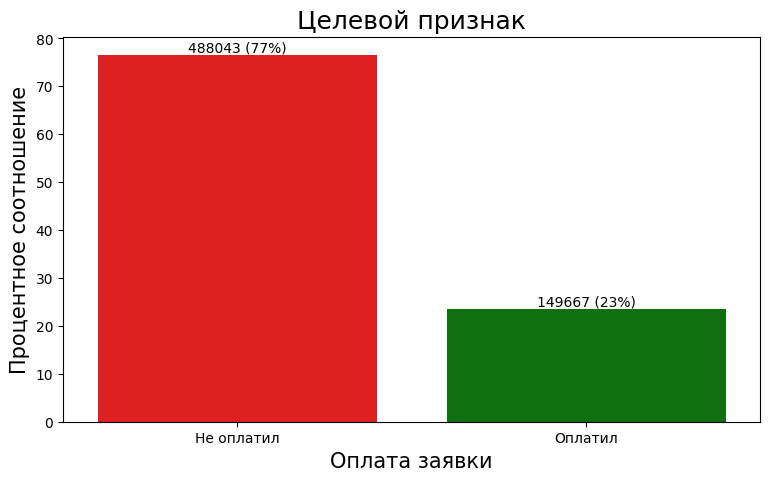

Время выполнения: 0.39 секунд(ы)


In [42]:
eda.target_countplot(dataset=final)

Дисбаланс есть, но не критичный.

**Матрица корреляции `Phik`**

Т.к. признаков много, в методе `phik_correlation` заранее убран один из двух признаков с взаимной корреляцией больше 0.8

Время выполнения: 133.69 секунд(ы)


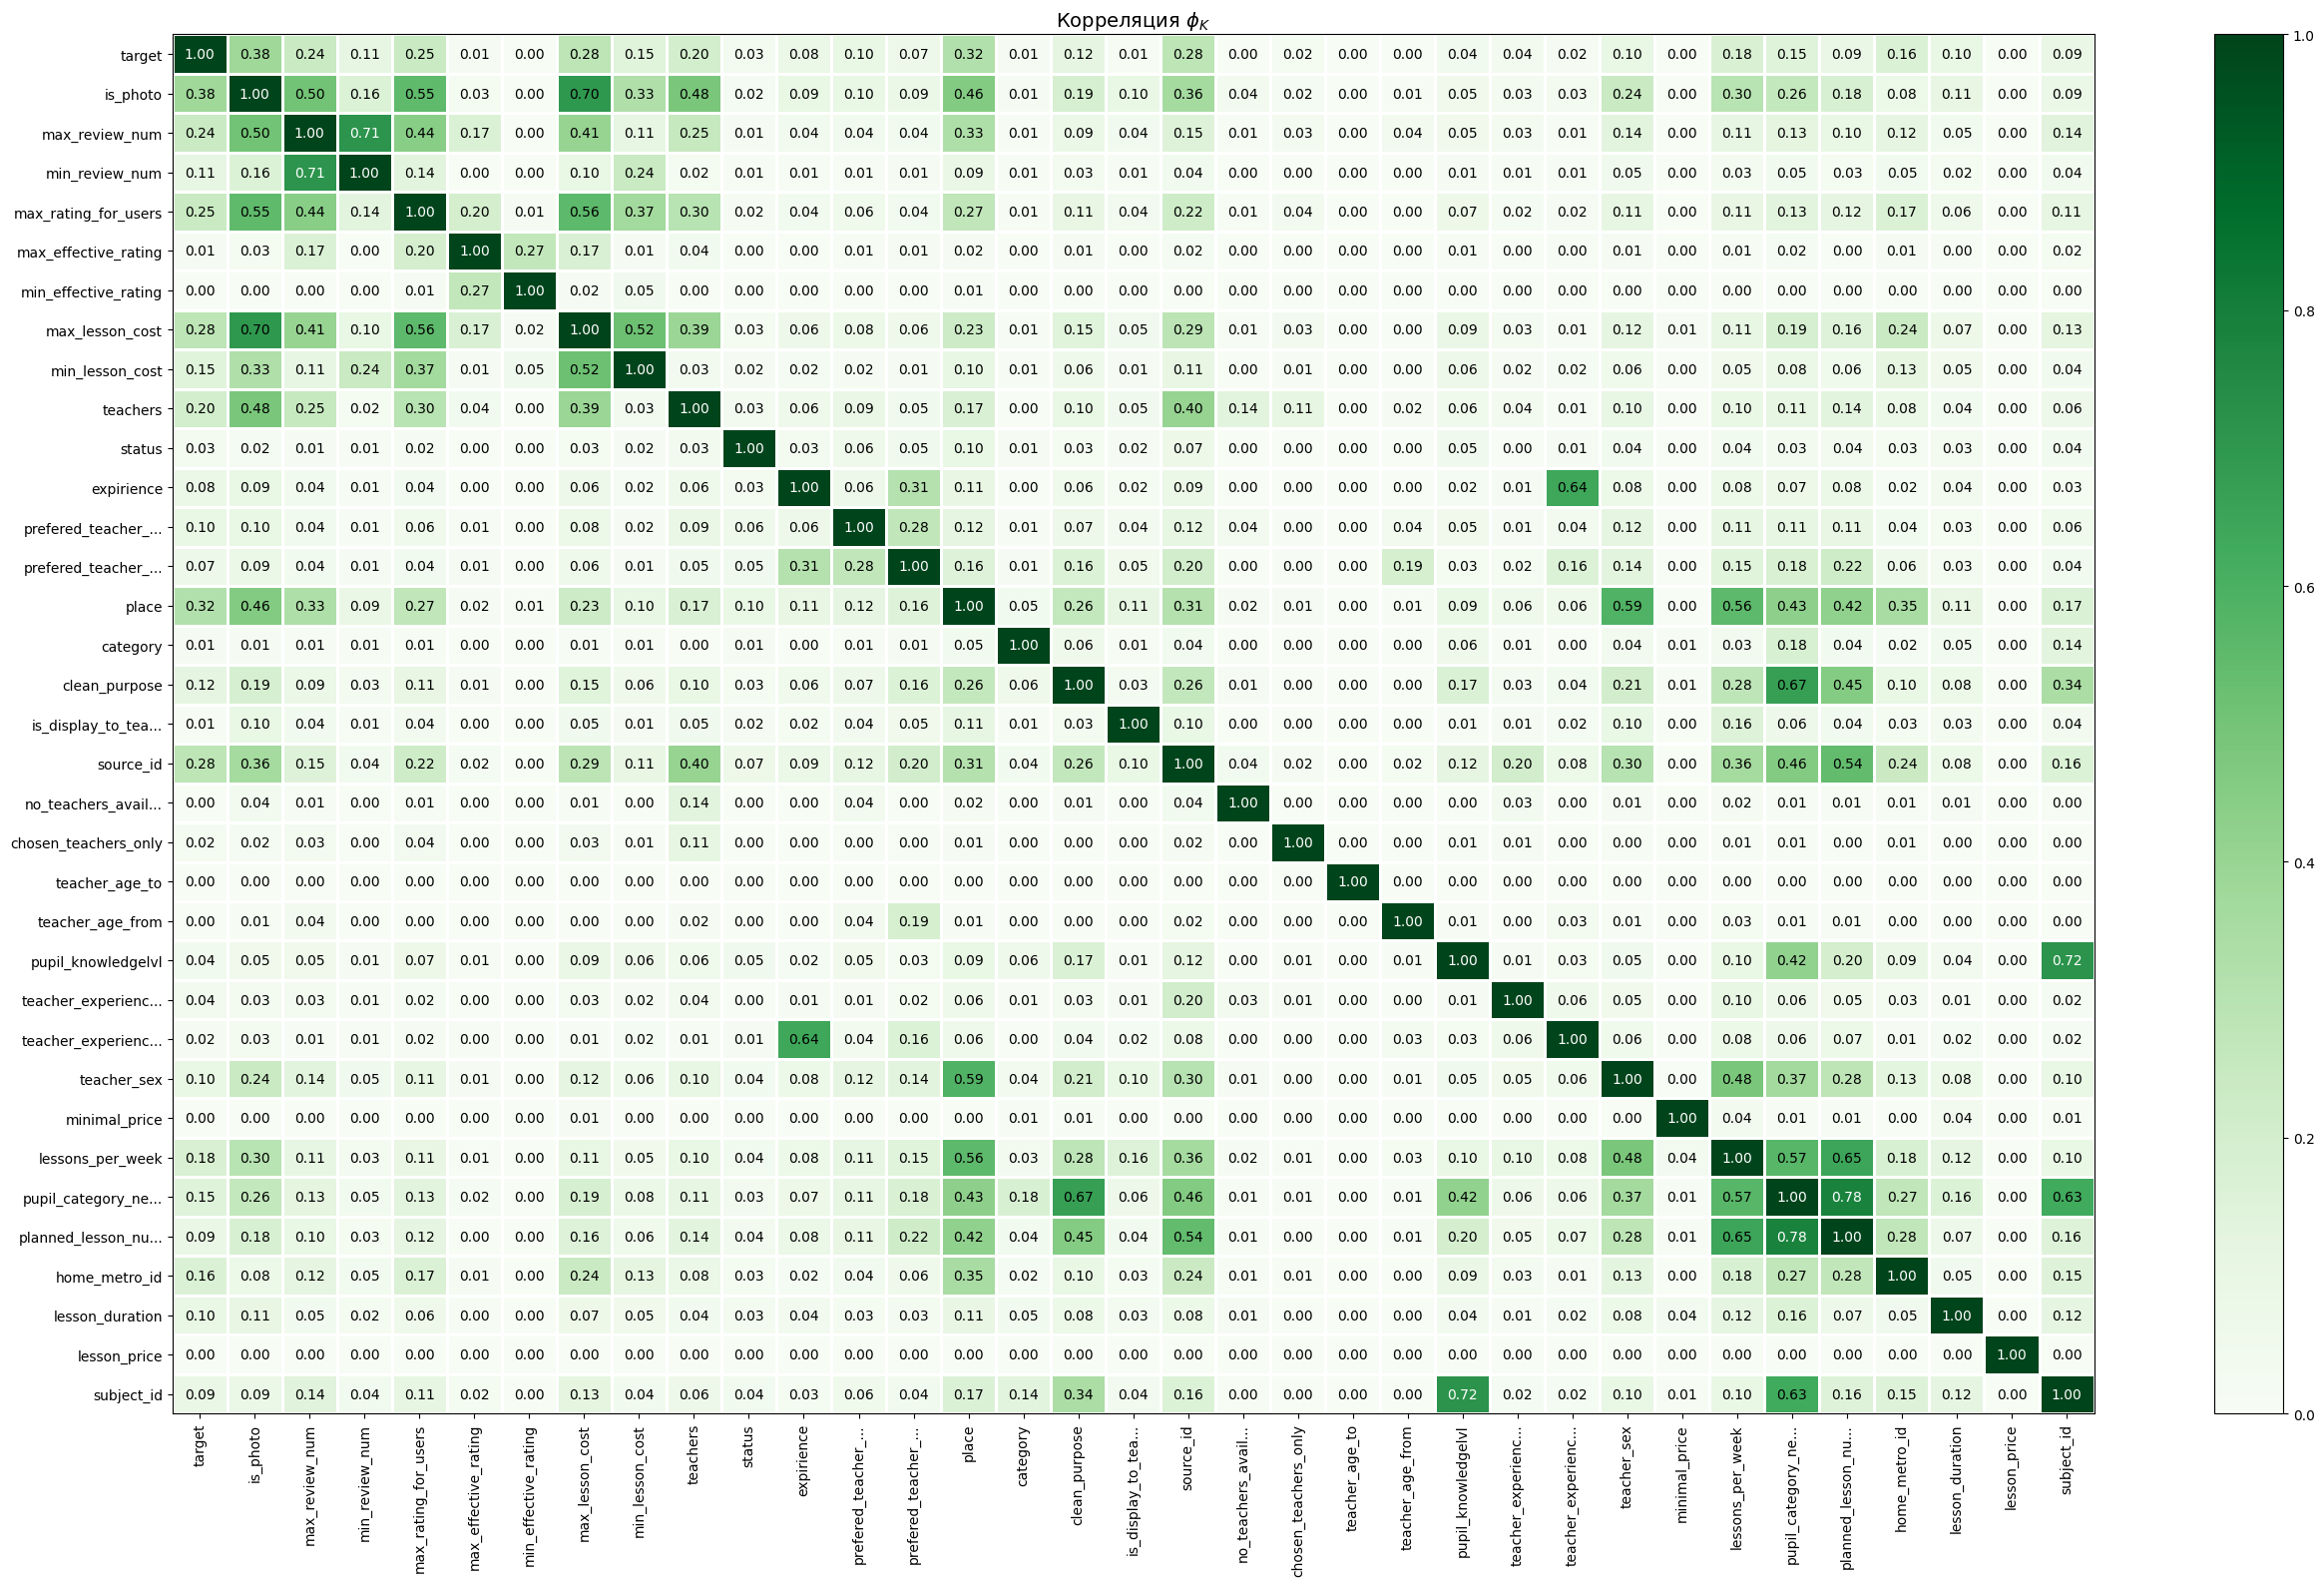

In [43]:
final = eda.phik_correlation(dataset=final)

Сильно коррелирующих признаков с таргетом дающих утечку нету.

**Описательная статистика**

In [44]:
eda.custom_describe(dataset=final)

Описательная статистика.



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
lesson_price,637710.00,2642.52,900.00,1252343.34,0.00,500.00,900.00,1500.00,1000000000.00,798.37,637494.59
lesson_duration,637710.00,60.43,60.00,6.87,0.00,60.00,60.00,60.00,135.00,3.38,46.22
planned_lesson_number,637710.00,8.30,10.00,3.55,0.00,10.00,10.00,10.00,10.00,-1.79,1.39
lessons_per_week,637710.00,3.00,3.00,1.60,0.00,2.00,3.00,4.00,7.00,-0.38,-0.09
minimal_price,637710.00,149.53,0.00,1554.23,0.00,0.00,0.00,0.00,1000000.00,467.41,280730.86
teacher_experience_from,637710.00,1.34,0.00,2.67,0.00,0.00,0.00,1.00,51.00,2.15,5.00
teacher_experience_to,637710.00,0.95,0.00,8.60,0.00,0.00,0.00,0.00,500.00,10.00,115.48
teacher_age_from,637710.00,7.48,0.00,11.58,-40.00,0.00,0.00,18.00,1000.00,2.15,85.55
teacher_age_to,637710.00,19.45,0.00,134.01,-110.00,0.00,0.00,50.00,99999.00,662.95,487766.43
prefered_teacher_age_from,637710.00,1.59,0.00,3.08,0.00,0.00,0.00,3.00,47.00,2.77,11.06


Время выполнения: 3.87 секунд(ы)


**Гистограммы и ящики с усами для числовых признаков**

Гистограммы и ящики с усами.



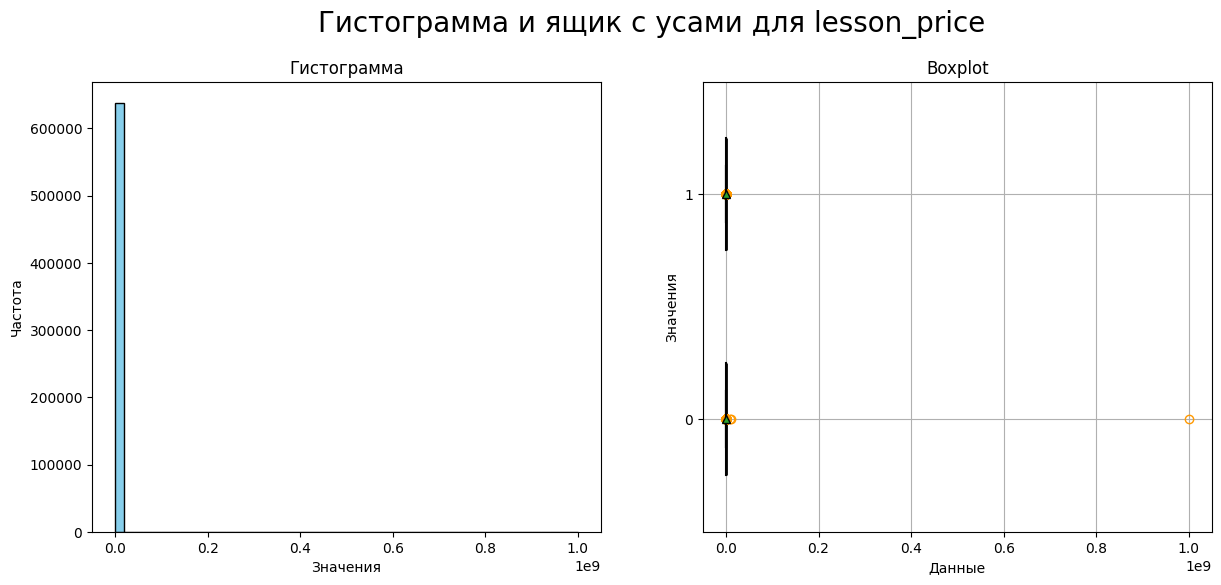

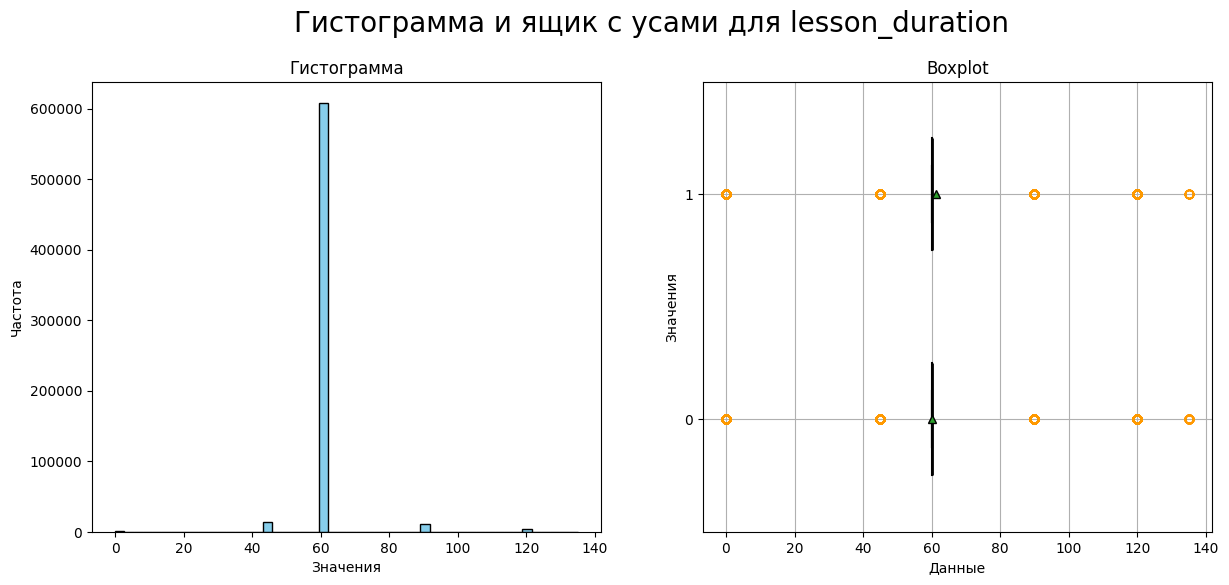

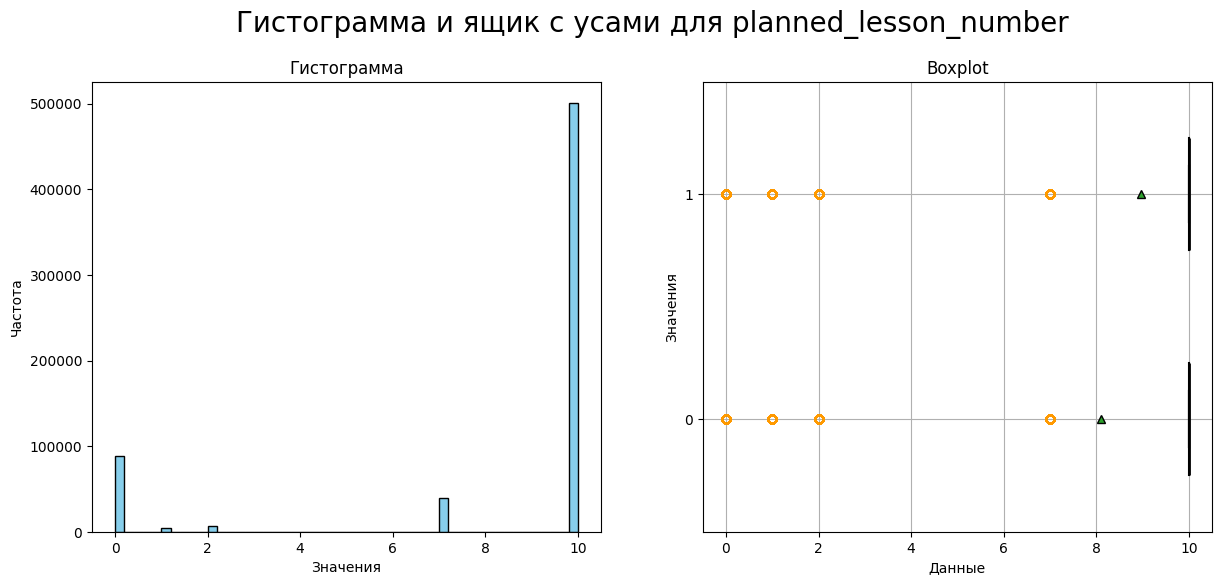

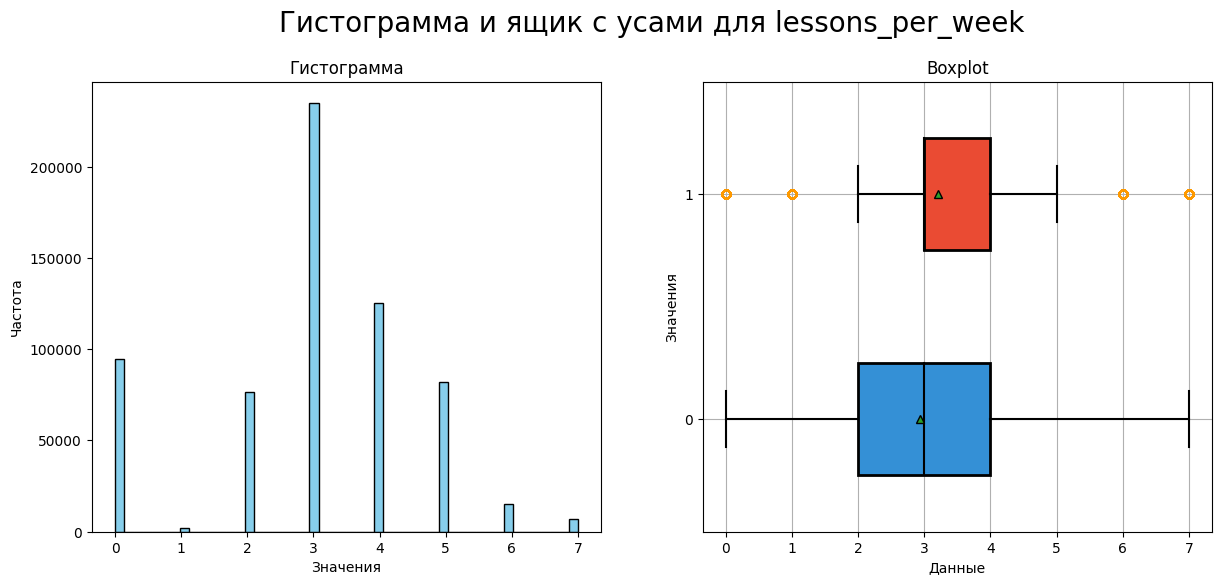

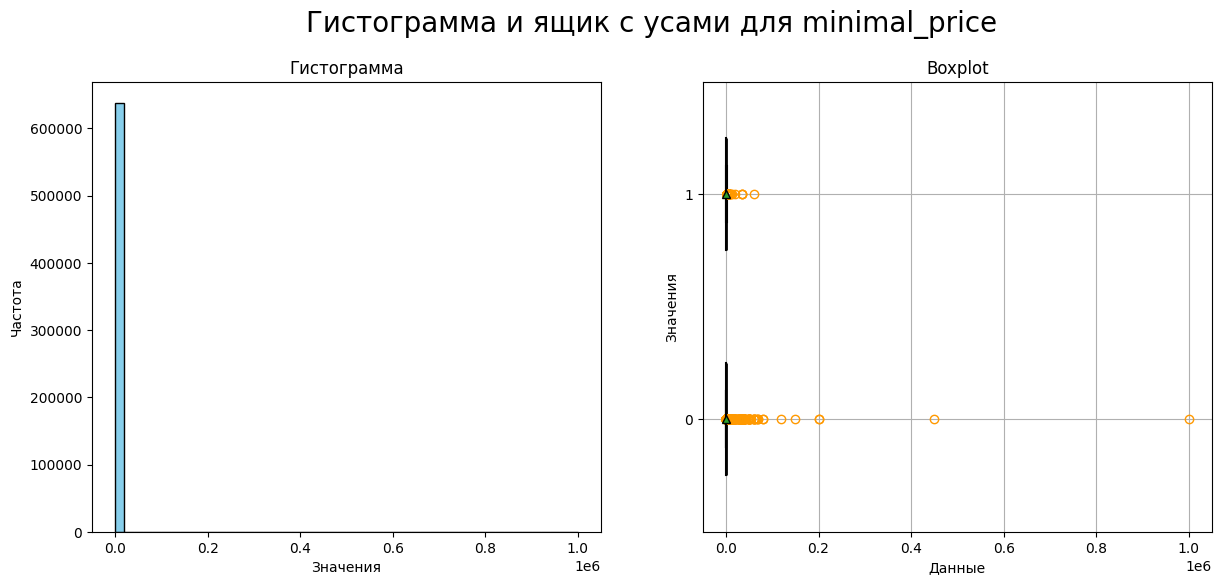

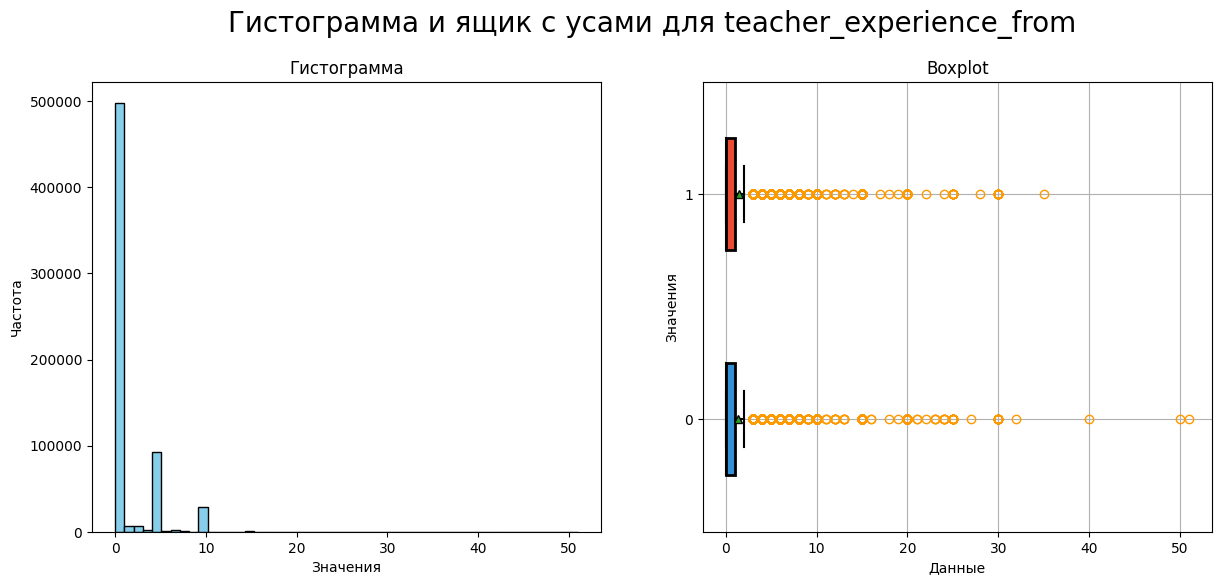

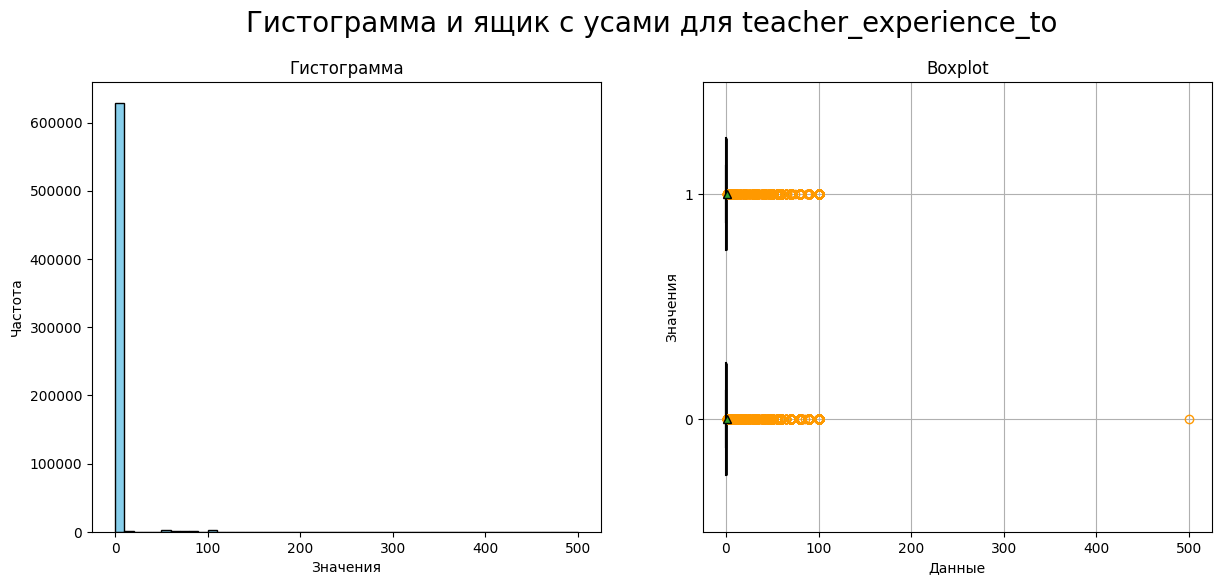

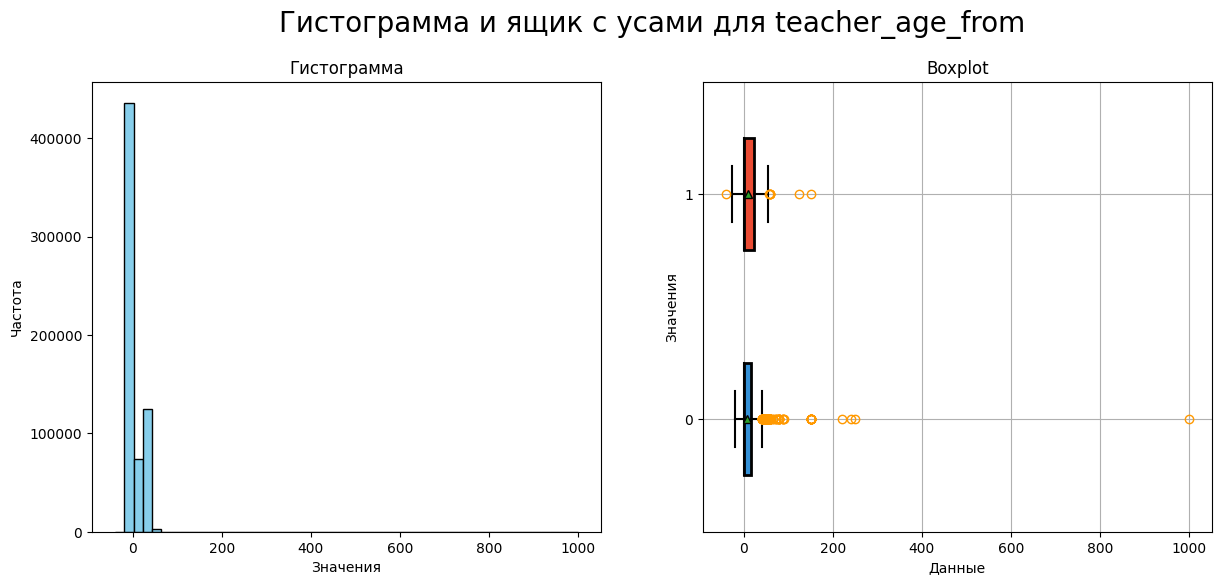

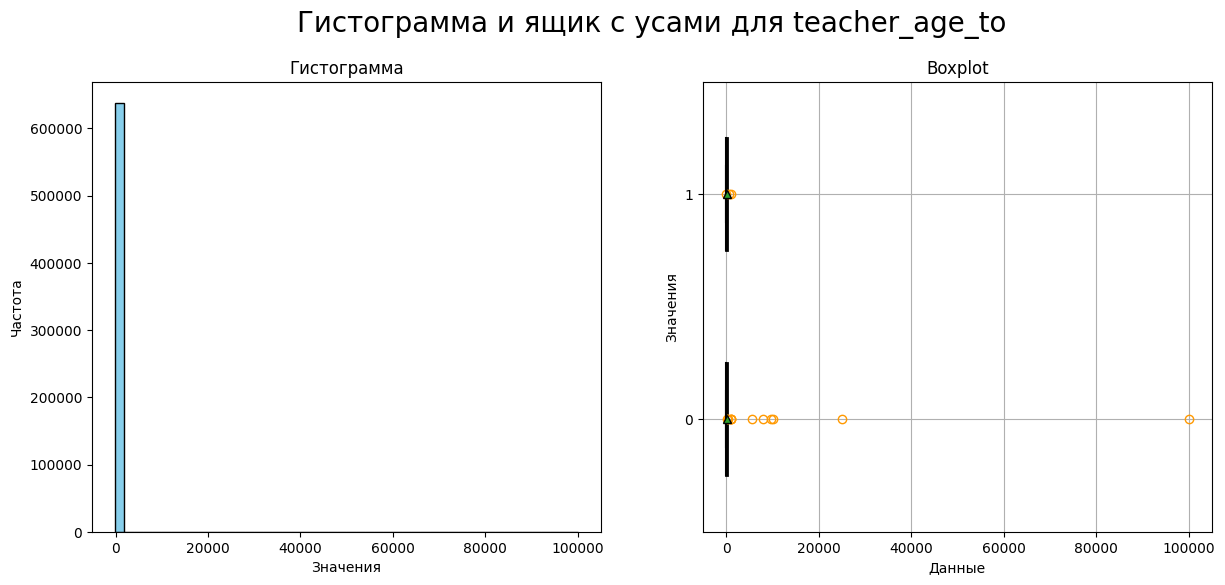

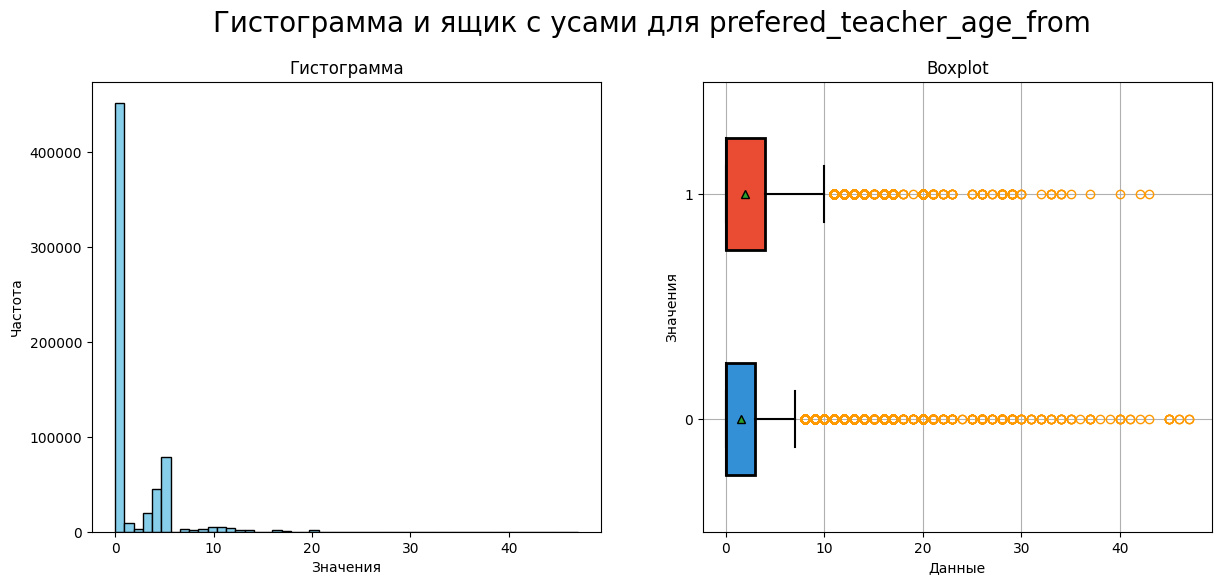

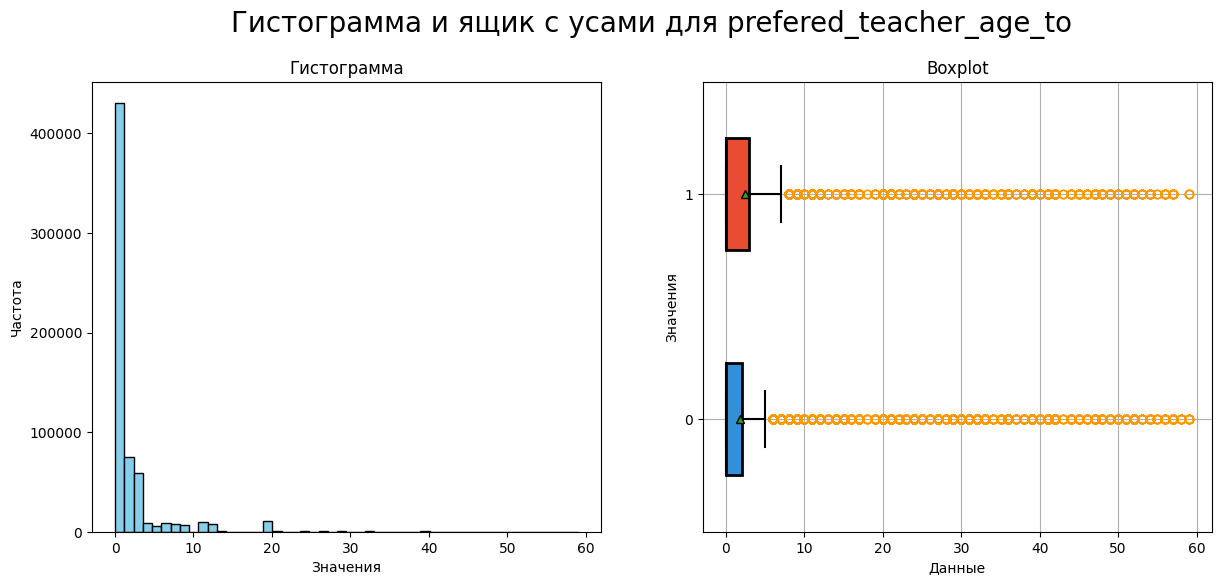

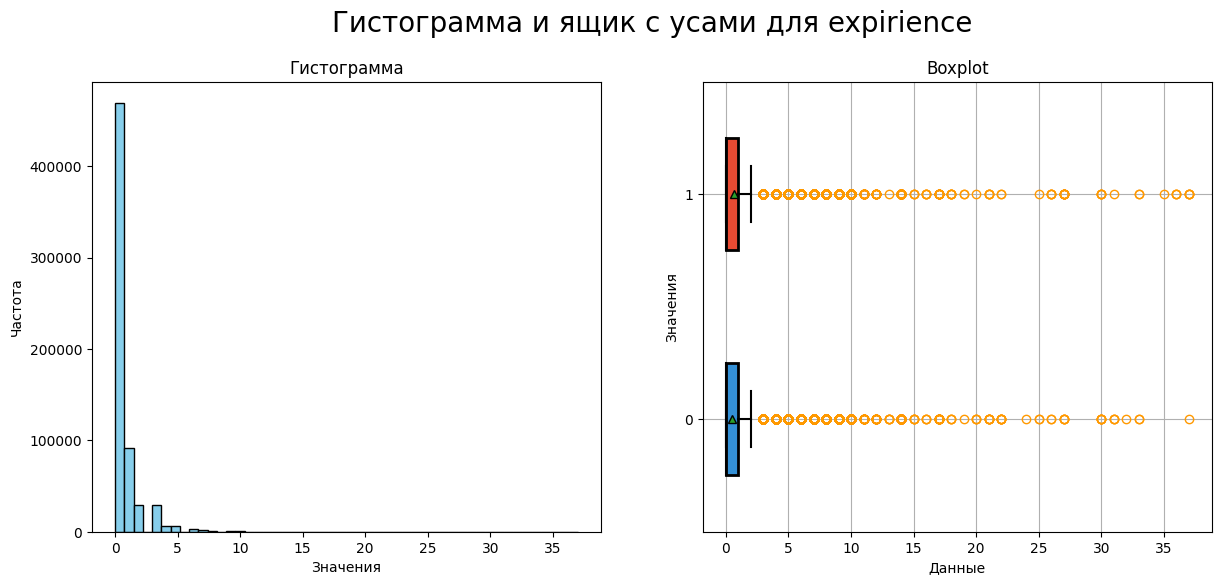

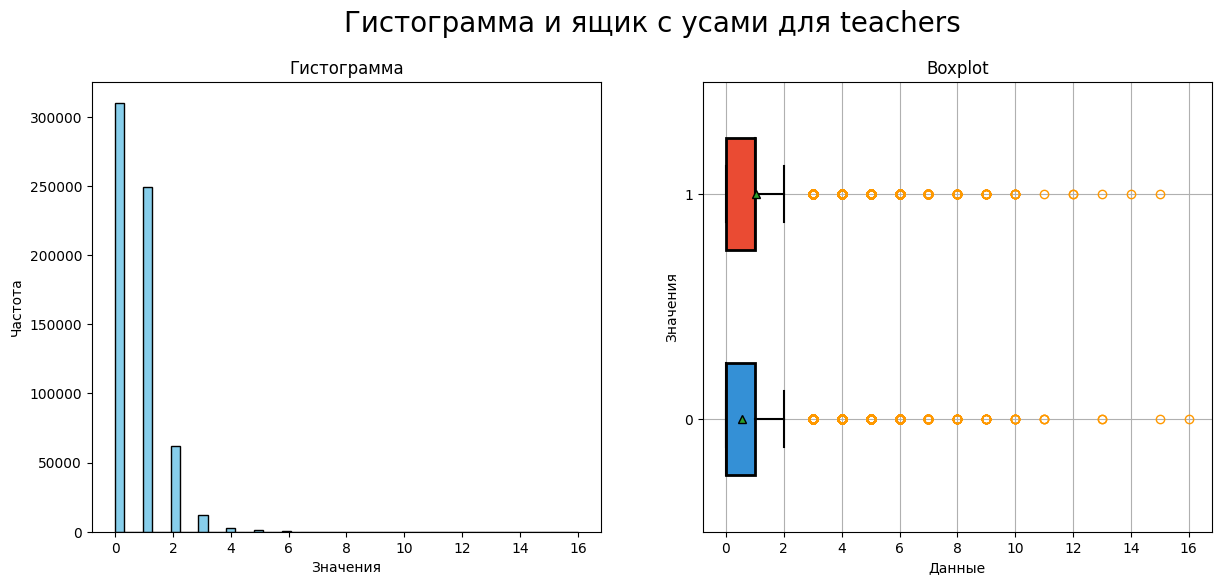

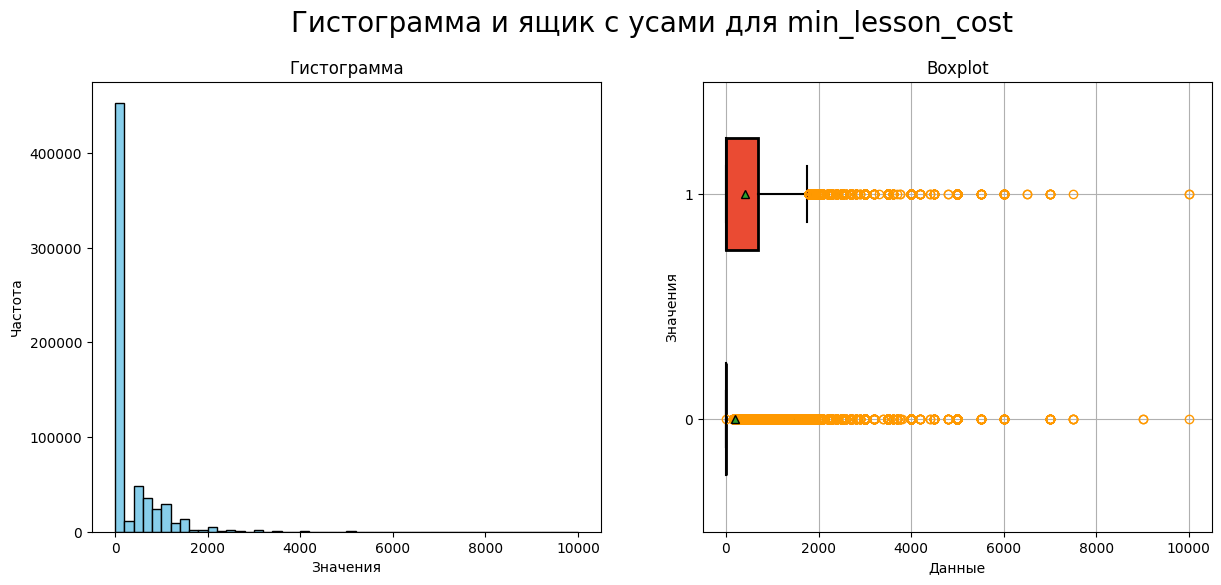

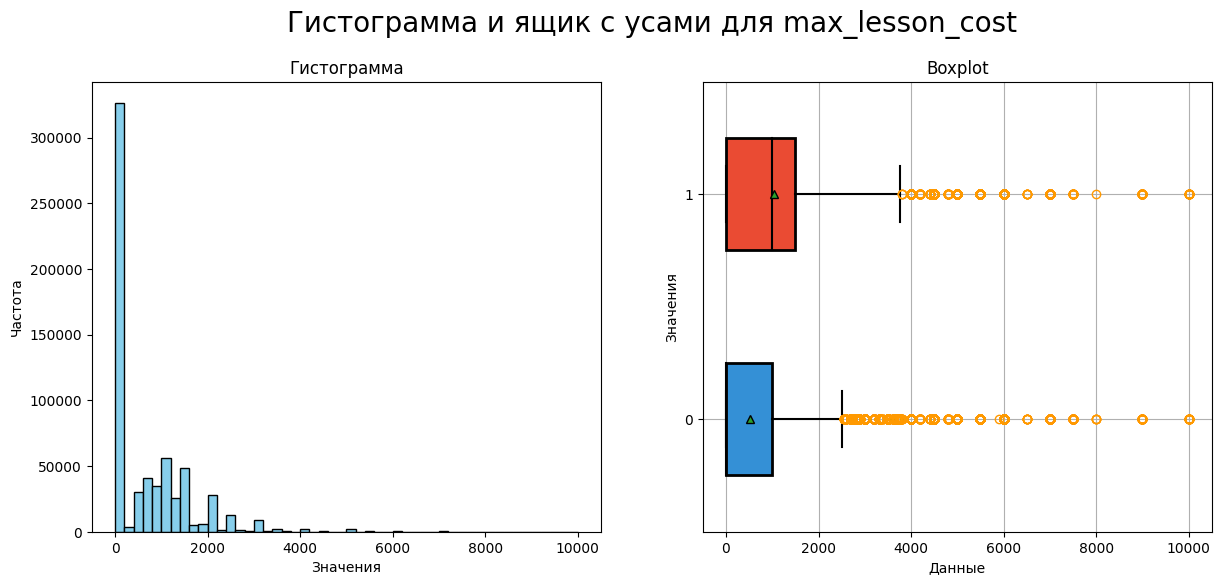

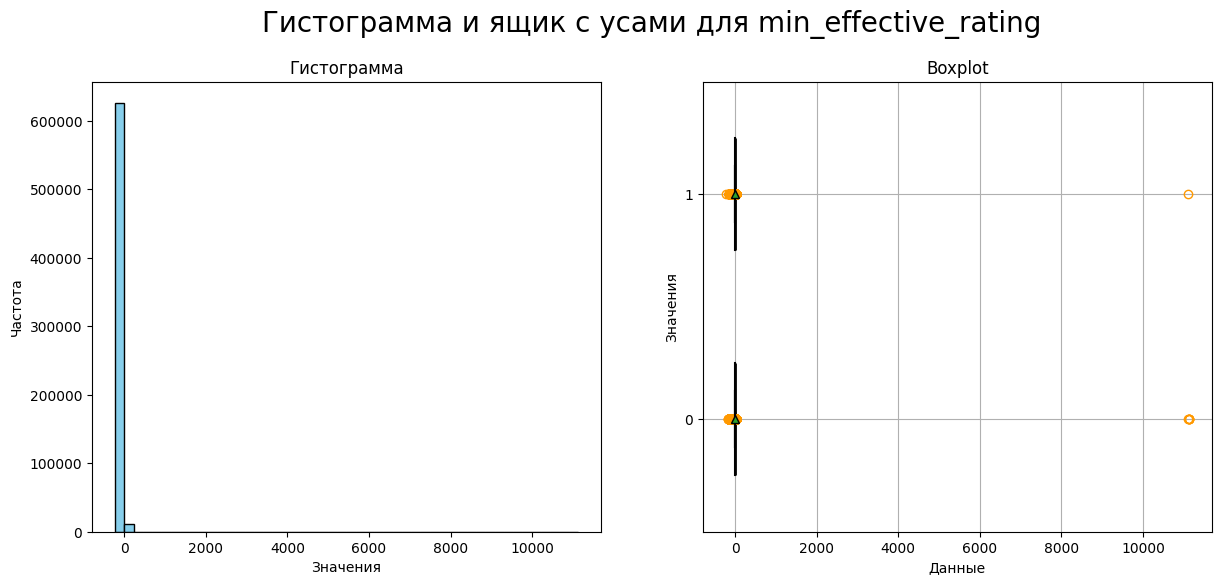

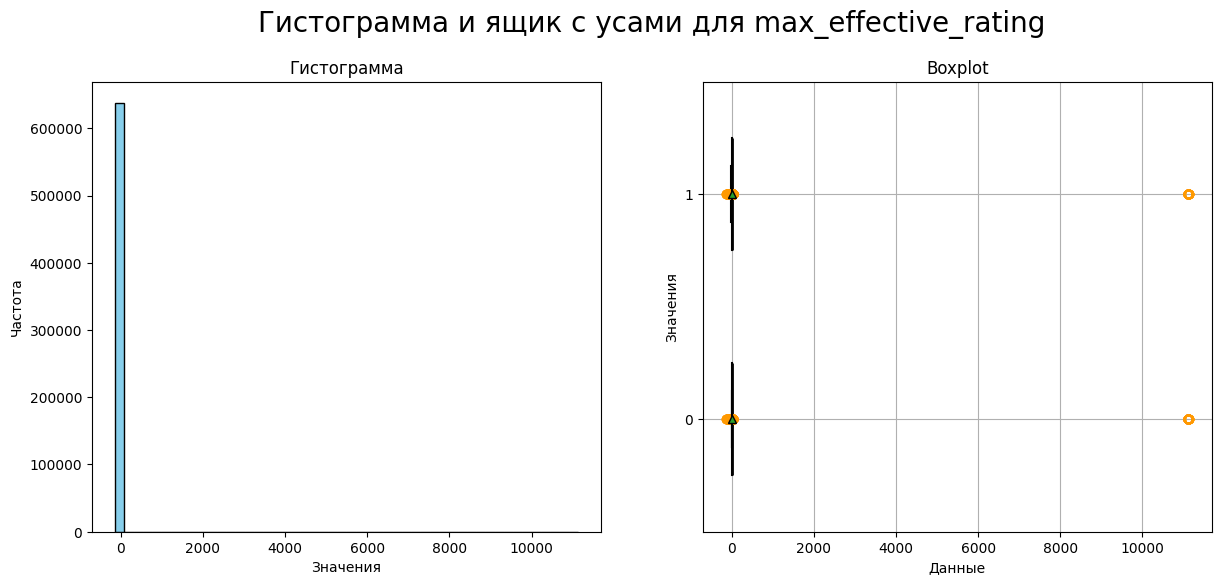

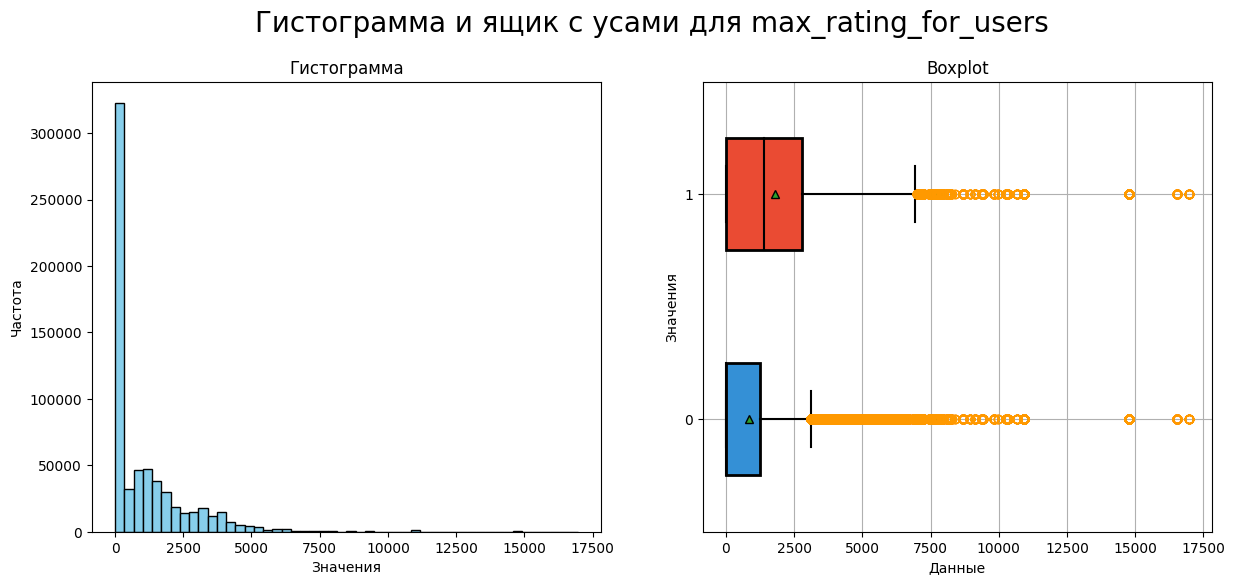

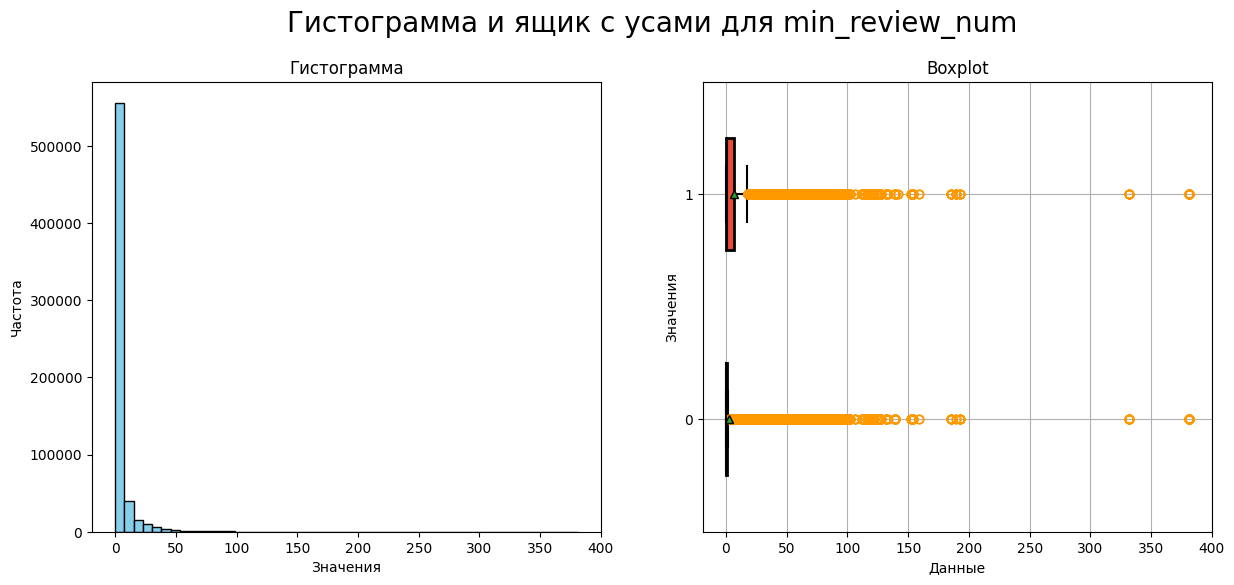

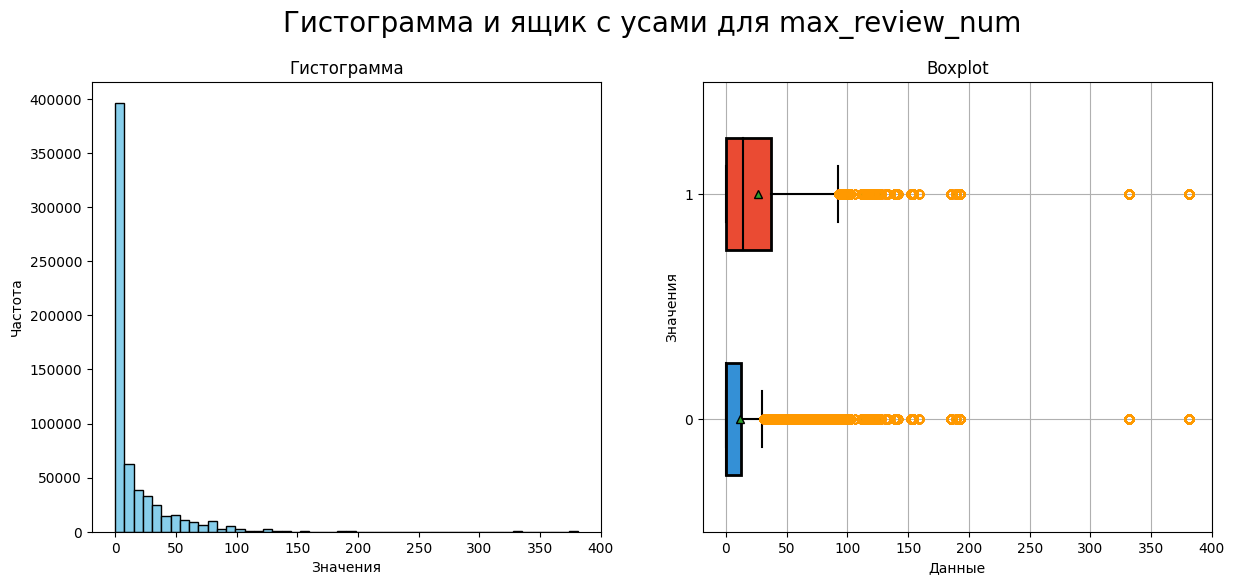

Время выполнения: 19.25 секунд(ы)


In [45]:
eda.hist_and_box(dataset=final, target="target")

По описательной статистике и ящикам с усами есть аномальные значения в признаках:

- `teacher_experience_to` - в опыте слишком большие значения, видимо ставились абы как, ограничим опят 60 годами.
- `teacher_age_from` - есть знаения меньше нуля, которых не должно быть и слишком высокие, ограничим минимум как 18, максимум как 75.
- `teacher_age_to` - аналогично.
- `lesson_price` - цену урока сделаем не более 10000 рублей.
- `minimal_price` - аналогично.

Так же есть слишком высокие цены на занятия, которые ставили учителя `min_lesson_cost` и `max_lesson_cost`, но тут можно оставить как есть. Вполне возможно, что учителя сами себя так оценивают.
Или рейтинги `min_effective_rating`, `max_effective_rating`, `max_rating_for_users` - но как они формируются не известно. Оставляем как есть.

Распределения далеки он нормальных.

Обработать выбросы можно методом `fill_outliers`. Данный метод включен в класс, чтобы не висеть как отдельная функция. Метод точечный.

In [46]:
final = eda.fill_outliers(dataset=final)

Точечное удаление выбросов.
Время выполнения: 0.02 секунд(ы)


In [47]:
eda.custom_describe(dataset=final)

Описательная статистика.



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
lesson_price,637710.00,1029.51,900.00,879.90,0.00,500.00,900.00,1500.00,10000.00,2.48,12.54
lesson_duration,637710.00,60.43,60.00,6.87,0.00,60.00,60.00,60.00,135.00,3.38,46.22
planned_lesson_number,637710.00,8.30,10.00,3.55,0.00,10.00,10.00,10.00,10.00,-1.79,1.39
lessons_per_week,637710.00,3.00,3.00,1.60,0.00,2.00,3.00,4.00,7.00,-0.38,-0.09
minimal_price,637710.00,142.29,0.00,357.06,0.00,0.00,0.00,0.00,10000.00,6.43,117.24
teacher_experience_from,637710.00,1.34,0.00,2.67,0.00,0.00,0.00,1.00,51.00,2.15,5.00
teacher_experience_to,637710.00,0.73,0.00,6.31,0.00,0.00,0.00,0.00,60.00,8.79,76.26
teacher_age_from,637710.00,7.48,0.00,11.49,0.00,0.00,0.00,18.00,75.00,1.11,-0.12
teacher_age_to,637710.00,18.30,0.00,27.21,0.00,0.00,0.00,50.00,75.00,1.00,-0.66
prefered_teacher_age_from,637710.00,1.59,0.00,3.08,0.00,0.00,0.00,3.00,47.00,2.77,11.06


Время выполнения: 4.0 секунд(ы)


Датасет готов к дальнейшему обучению.

## Выборки

Класс `DataSplitCoder` для разбиения датасета на воборки и масштабирования признаков.

In [48]:
class DataSplitCoder:
    """
    Класс для разбиения датасета на выборки и масштабирования.

    Методы класса:
    - get_coded_data: метод получения масштабированных выборок.
    - data_split (статический метод): статический метод разбивает датасет на выборки.
    """

    def __init__(self):
        """
        Конструктор класса DataSplitCoder.
        """
        pass

    @staticmethod
    def data_split(
        dataset=None,
        target_col=None,
        test_size=None,
        valid=False,
        test_valid_size=0.4,
        report=False,
    ):
        """
        Статический метод data_split класса DataSplitCoder.
        Метод разбивает датасет на выборки.

        Параметры:

        - dataset (pd.DataFrame): датасет с данными (по умолчанию None).
        - target_col (str): целевой признак (по умолчанию None).
        - test_size (float): размер тестовой выборки (по умолчанию None).
        - valid (Boolean): флаг для выбора возможности добавлять валидационную выборку (по умолчанию False).
        - test_valid_size (float): размер тестовой и валидационной выборки (по умолчанию None).
        - report (Boolean): флаг для выбора возможности вывода отчета по разбиению (по умолчанию False).

        Возвращает (результат разбиения на выборки):

        - Если valid=False, возвращаются только трейн и тест:

           features_train, target_train, features_test, target_test

        - Если valid=True, возвращаются трейн, валид и тест:

           features_train, target_train, features_valid, target_valid, features_test, target_test

        """

        # выделение признаков
        features = dataset.drop([target_col], axis=1)
        # выделение целевого признака
        target = dataset[target_col]
        # если нужна валидация - разбиваем на train, valid, test в соотношении 60-20-20
        if valid:
            features_train, features_test, target_train, target_test = train_test_split(
                features, target, test_size=test_valid_size, random_state=RANDOM
            )
            features_valid, features_test, target_valid, target_test = train_test_split(
                features_test, target_test, test_size=0.5, random_state=RANDOM
            )
            # если True
            if report:
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Тренировочная выборка: {Style.RESET_ALL}",
                    features_train.shape,
                    target_train.shape,
                )
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Валидационная выборка: {Style.RESET_ALL}",
                    features_valid.shape,
                    target_valid.shape,
                )
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Тестовая выборка: {Style.RESET_ALL}",
                    features_test.shape,
                    target_test.shape,
                )

            return (
                features_train,
                target_train,
                features_valid,
                target_valid,
                features_test,
                target_test,
            )

        # если не нужна валидация - разбиваем на train и test в соотношении 80-20
        else:
            features_train, features_test, target_train, target_test = train_test_split(
                features,
                target,
                test_size=test_size,
                random_state=RANDOM,
                stratify=target,
            )
            # если True
            if report:
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Тренировочная выборка: {Style.RESET_ALL}",
                    features_train.shape,
                    target_train.shape,
                )
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Тестовая выборка: {Style.RESET_ALL}",
                    features_test.shape,
                    target_test.shape,
                )

            return features_train, target_train, features_test, target_test

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def get_coded_data(
        self,
        dataset=None,
        target_col=None,
        cols_to_drop=[],
        test_size=0.25,
        valid=False,
        test_valid_size=0.4,
        report=False,
        scaler=StandardScaler(),
        categorical=False,
        encoder=OrdinalEncoder(),
    ):
        """
        Метод get_coded_data класса DataSplitCoder.
        Метод получения масштабированных выборок.

        Параметры:

        - dataset (pd.DataFrame): датасет с данными (по умолчанию None).
        - target_col (str): целевой признак (по умолчанию None).
        - cols_to_drop (list): список столбцов, которые можно дополнительно удалить (по умолчанию пустой список).
        - test_size (float): размер тестовой выборки (по умолчанию 0.25).
        - valid (Boolean): флаг для выбора возможности добавлять валидационную выборку (по умолчанию False).
        - test_valid_size (float): размер тестовой и валидационной выборки (по умолчанию 0.4).
        - report (Boolean): флаг для выбора возможности вывода отчета по разбиению (по умолчанию False).
        - scaler (class object): скалер для масштабирования числовых признаков (по умолчанию StandardScaler()).
        - categorical(Boolean): флаг для выбора возможность кодирования категориальных признаков (по умолчанию False).
        - encoder (class object): энкодер для кодирования категориальных признаков (по умолчанию OrdinalEncoder()).


        Возвращает (результат разбиения на выборки):

        - Если valid=False, возвращаются только трейн и тест:

           features_train, target_train, features_test, target_test

        - Если valid=True, возвращаются трейн, валид и тест:

           features_train, target_train, features_valid, target_valid, features_test, target_test

        """
        # вызов метода data_split для разбиения на выборки
        # если True, то разбиваем на train, valid и test
        if valid:
            (
                features_train,
                target_train,
                features_valid,
                target_valid,
                features_test,
                target_test,
            ) = DataSplitCoder.data_split(
                dataset,
                target_col=target_col,
                test_size=test_valid_size,
                report=report,
                valid=valid,
            )
        # если False, то разбиваем на train и test
        else:
            (
                features_train,
                target_train,
                features_test,
                target_test,
            ) = DataSplitCoder.data_split(
                dataset,
                target_col=target_col,
                test_size=test_size,
                report=report,
                valid=valid,
            )
        # проверка наличия списка удаляемых столбцов из выборок
        if len(cols_to_drop) > 0:
            # удаление из трейна и теста нужных столбцов
            features_train = features_train.drop(cols_to_drop, axis=1)
            features_test = features_test.drop(cols_to_drop, axis=1)
            if valid:
                features_valid = features_valid.drop(cols_to_drop, axis=1)
        # список числовых признаков
        num_cols = features_train.select_dtypes(include=np.number).columns.tolist()
        # масштабирование числовых признаков
        if len(num_cols) > 0:
            # объявление шкалера и его обучение на трейне
            scaler.fit(features_train[num_cols])
            # масштабирование числовых признаков в трейне и тесте
            features_train[num_cols] = scaler.transform(features_train[num_cols])
            features_test[num_cols] = scaler.transform(features_test[num_cols])
            if valid:
                features_valid[num_cols] = scaler.transform(features_valid[num_cols])
        # масштабирование категориальных признаков
        if categorical:
            # список категориальных признаков
            cat_cols = features_train.select_dtypes(exclude=np.number).columns.tolist()
            if len(cat_cols) > 0:
                # объявление шкалера и его обучение на трейне
                encoder.fit(features_train[cat_cols])
                # масштабирование числовых признаков в трейне и тесте
                features_train[cat_cols] = encoder.transform(features_train[cat_cols])
                features_test[cat_cols] = encoder.transform(features_test[cat_cols])
                if valid:
                    features_valid[cat_cols] = encoder.transform(
                        features_valid[cat_cols]
                    )
        # возврат выборок и таргетов
        if valid:
            return (
                features_train,
                target_train,
                features_valid,
                target_valid,
                features_test,
                target_test,
            )
        return features_train, target_train, features_test, target_test

**Создаем экзепляр класса**

In [49]:
splitter = DataSplitCoder()

**Выборки**

In [50]:
features_train, target_train, features_test, target_test = splitter.get_coded_data(
    dataset=final,
    target_col="target",
    cols_to_drop=[],
    test_size=0.2,
    report=True,
    scaler=RobustScaler(),
    categorical=True,
    encoder=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)

Тренировочная выборка:  (510168, 34) (510168,)
Тестовая выборка:  (127542, 34) (127542,)
Время выполнения: 1.57 секунд(ы)


## Подбор гиперпараметров и обучение модели.

Класс `ModelOptuna` поможет создать модель, подобрать гиперпараметры модели, получить тестовые результаты, а так же поможет отобрать признаки. 

In [51]:
class ModelOptuna:
    """
    Класс для подбора гиперпараметров модели с Optuna, обучения моделей и отбора признаков.

    Методы класса:
    - get_model_with_best_params: метод получает модель на лучших гиперпараметрах.
    - models_report: метод выводит отчет с полученными метриками разных моделей.
    - get_test_results: метод обучает модель, делает предсказания с калибровкой и без неё.
    - sequential_feature_selection: метод отбирает лучшие признаки модели.
    - objective: метод поиска лучших гиперпараметров для модели.
    - convert_param (статический метод): статический метод конвертирует параметр в формат, подходящий для оптимизации с помощью Optuna.
    - get_model (статический метод): статический метод создает модель с параметрами, на основаниия полученного названия модели и словарей с ее гиперпараметрами.
    """

    def __init__(self, random_state=RANDOM):
        """
        Конструктор класса ModelOptuna.
        Параметры:
        - random_state (int): значение random_state.
        """
        self.RANDOM = random_state

    @staticmethod
    def convert_param(param_name, param_value, trial=None):
        """
        Статический метод convert_paramt класса ModelOptuna.
        Конвертирует параметр в формат, подходящий для оптимизации с помощью Optuna.

        Параметры:
        - param_name (str): имя параметра.
        - param_value (any): значение параметра
        - trial (optuna.Trial, optional): экземпляр класса optuna.Trial, используемый для оптимизации параметров.
                                          (по умолчанию None).

        Возвращает:
        - значение параметра, подходящее для оптимизации с помощью Optuna.

        """
        # проверка значения param_value на тип np.ndarray
        if isinstance(param_value, np.ndarray):
            # если тип np.ndarray, проверяем на тип np.integer
            if np.issubdtype(param_value.dtype, np.integer):
                # если тип np.integer возвращаем trial.suggest_int c именем гиперпараметра, стартовым и конечным значением поиска
                # при условии что значение param_value это np.ndarray
                return trial.suggest_int(param_name, param_value[0], param_value[-1])
            # если тип np.ndarray, проверяем на тип np.float
            elif np.issubdtype(param_value.dtype, np.float):
                # если значение параметра является массивом numpy и содержит числа с плавающей запятой, используем suggest_float
                # c именем гиперпараметра, стартовым и конечным значением поиска при условии что значение param_value это np.ndarray
                return trial.suggest_float(
                    param_name, param_value[0], param_value[-1], log=True
                )
        # проверка значения param_value на тип list
        elif isinstance(param_value, list):
            # если все в списке string
            if all(isinstance(item, str) for item in param_value):
                # используем suggest_categorical c именем гиперпараметра и списком строковых значений
                return trial.suggest_categorical(param_name, param_value)
            # если все в списке int
            elif all(isinstance(item, int) for item in param_value):
                # используем suggest_int
                # c именем гиперпараметра, стартовым и конечным значением поиска при условии что значение param_value это list
                return trial.suggest_int(param_name, param_value[0], param_value[-1])
            # если какое-нибудь значение в списке float
            elif any(isinstance(item, float) for item in param_value):
                # используем suggest_float
                # c именем гиперпараметра, стартовым и конечным значением поиска при условии что значение param_value это list
                return trial.suggest_float(
                    param_name, param_value[0], param_value[-1], log=True
                )
            # в других случаях возвращаем исходное значение
            else:
                return param_value

    @staticmethod
    def get_model(
        model_name=None,
        fixed_params=None,
        dynamic_or_best_params=None,
        trial=None,
        random=None,
    ):
        """
        Статический метод get_model класса ModelOptuna.
        Возвращает модель с параметрами, на основаниия полученного названия модели и словарей с ее гиперпараметрами.

        Параметры:
        - model_name (str): имя модели (по умолчанию None).
        - fixed_params (dict): словарь фиксированных параметров (по умолчанию None)
        - dynamic_or_best_params (dict): словарь динамических или лучших параметров (по умолчанию None).
        - trial (optuna.Trial): экземпляр класса optuna.Trial, используемый для оптимизации параметров (по умолчанию None).
        - random (int): значение random_state (по умолчанию None)

        Возвращает:
        - model: экземпляр модели с оптимизированными параметрами.

        """
        # имициализируем переменную со значением None, в которую будем записывать словарь с гиперпараметрами.
        final_params = None
        # проверка на наличие словаря с гиперпараметрами для подбора оптуной или словаря с лучшими гиперпараметрами
        if dynamic_or_best_params:
            # проверка нужен ли экземпляр класса optuna.Trial
            if trial:
                # создаем словарь через вызов статического метода convert_param для конвертации в формат, подходящий
                # для оптимизации с помощью Optuna.
                final_params = {
                    k: ModelOptuna.convert_param(k, v, trial=trial)
                    for k, v in dynamic_or_best_params.items()
                }
            # если optuna.Trial не нужен
            else:
                # в переменную сохраняем словарь с лучшими гиперпараметрами
                final_params = dynamic_or_best_params
        # проверка на наличие словаря с фиксированными гиперпараметрами
        if fixed_params:
            # если передан словарь только с фикированными гиперпараметрами и переменная final_params пустая
            if final_params is None:
                # присваиваем в переменную словарь с фикированными гиперпараметрами
                final_params = fixed_params
            # иначе
            else:
                # объединем словари final_params, полученный при dynamic_or_best_params с fixed_params
                final_params.update(fixed_params)
        # создаем модель согласно имени модели model_name. sys.modules - это словарь,
        # содержащий все загруженные модули в текущем исполняющемся скрипте. name здесь - это строка с именем модуля,
        # из которого мы хотим получить атрибут.  getattr - это встроенная функция Python, которая возвращает значение
        # атрибута объекта по его имени. obj - это модуль, из которого нужно получить атрибут, а attr - это строка с именем атрибута.
        model_class = getattr(sys.modules[__name__], model_name)
        # заполняем модель гиперпараметрами из словаря final_params если он не пустой
        model = (
            lambda p: model_class(**p, random_state=random)
            if p is not None
            else model_class(random_state=random)
        )(final_params)

        return model

    def objective(
        self, trial, model_name, fixed_params, dynamic_or_best_params, metric_for_cv
    ):
        """
        Метод objective класса ModelOptuna.
        Метод поиска лучших гиперпараметров для модели.

        Параметры:
        - trial (optuna.Trial): экземпляр класса optuna.Trial, используемый для оптимизации параметров.
        - model_name (str): имя модели.
        - fixed_params (dict): словарь фиксированных параметров.
        - dynamic_or_best_params (dict): словарь динамических или лучших параметров.
        - metric_for_cv (str): метрика для кросс-валидации.

        Возвращает:
        - metric (float)- значение метрики.
        """

        # создаем модель вызывая статический метод get_model, передавая в него имя модели, фиксированные гиперпараметры,
        # гиперпараметры для подбора, trial и random_state
        model = ModelOptuna.get_model(
            model_name=model_name,
            fixed_params=fixed_params,
            dynamic_or_best_params=dynamic_or_best_params,
            trial=trial,
            random=self.RANDOM,
        )

        # получение метрики на кроссвалидации
        skf = StratifiedKFold(n_splits=5, random_state=RANDOM, shuffle=True)
        metric = cross_val_score(
            model, features_train, target_train, cv=skf, scoring=metric_for_cv
        ).mean()
        # возврат метрики
        return metric

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def get_model_with_best_params(
        self,
        n_trials=10,
        features_train=None,
        target_train=None,
        model_name=None,
        fixed_params=None,
        dynamic_or_best_params=None,
        metric_for_cv="roc_auc",
    ):
        """
        Метод get_model_with_best_params класса ModelOptuna.
        Метод получает модель на лучших гиперпараметрах.

        Параметры:

        - n_trials (int): количество тестов модели (по умолчанию 10).
        - features_train (pd.DataFrame): признаки для облучения (по умолчанию None).
        - target_train (pd.Series, np.array): целевой признак для обучения (по умолчанию None).
        - model_name (srt): название модели, например DecisionTreeClassifier (по умолчанию None).
        - fixed_params (dict): словарь с фиксироваными гиперпараметрами (по умолчанию None).
        - dynamic_or_best_params (dict): словарь динамических или лучших параметров (по умолчанию None).
        - metric_for_cv (str): метрика (по умолчанию "roc_auc").

        Возвращает:
        - model: модель на лучших гиперпараметрах.
        """

        print(
            f"{Fore.GREEN}{Style.BRIGHT}Подбор гиперпараметров Optuna:{Style.RESET_ALL}"
        )
        print()
        # создание сэмплера
        pruner = HyperbandPruner()
        sampler = TPESampler(seed=self.RANDOM)
        # инициализация подбора гиперпараметров
        study = optuna.create_study(
            study_name=model_name, direction="maximize", pruner=pruner, sampler=sampler
        )
        # процесс подбора гиперпараметров
        study.optimize(
            lambda trial: self.objective(
                trial, model_name, fixed_params, dynamic_or_best_params, metric_for_cv
            ),
            n_trials=n_trials,
        )

        # вывод на экран результатов
        print()
        print(
            f"{Fore.GREEN}{Style.BRIGHT}Лучшие гиперпараметры подобраные Optuna:{Style.RESET_ALL}",
            study.best_params,
        )
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Усредненная метрика {metric_for_cv} модели на тренировочной выборке с кроссвалидацией: {study.best_value}{Style.RESET_ALL}"
        )
        # создаем модель вызывая статический метод get_model, передавая в него имя модели, фиксированные гиперпараметры,
        # лучшие подобранные гиперпараметры и random_state
        model = ModelOptuna.get_model(
            model_name=model_name,
            fixed_params=fixed_params,
            dynamic_or_best_params=study.best_params,
            random=self.RANDOM,
        )
        # возврат модели
        return model

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def models_report(self, model_names=None, model_metrics=None):
        """
        Метод models_report класса ModelOptuna.
        Метод выводит отчет с полученными метриками разных моделей.

        Параметры:

        - model_names (list): список с моделями (по умолчанию None).
        - model_metrics (list): список с метриками (по умолчанию None).

        Возвращает:
        - Нет возвращаемого значения.
        """
        # создаем словарь из списков
        data_dict = dict(zip(model_names, model_metrics))
        # создание DataFrame из словаря
        result_df = (
            pd.DataFrame(data_dict, index=[0])
            .T.rename_axis("Models")
            .rename(columns={0: "Metrics"})
        )
        # вывод DataFrame
        display(result_df)

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def get_test_results(
        self,
        model=None,
        features_train=None,
        target_train=None,
        features_test=None,
        target_test=None,
        calibrator=False,
    ):
        """
        Метод get_test_results класса ModelOptuna.
        Метод обучает модель, делает предсказания с калибровкой и без неё.

        Параметры:

        - model (object): модель для обучения (по умолчанию None).
        - features_train (pd.DataFrame): признаки для облучения (по умолчанию None).
        - target_train (pd.Series, np.array): целевой признак для обучения (по умолчанию None).
        - features_test (pd.DataFrame): признаки для теста (по умолчанию None).
        - target_test (pd.Series, np.array): целевой признак для теста (по умолчанию None).
        - calibrator (Boolean): флаг для выбора калибровки обученной модели (по умолчанию False).

        Возвращает:
        Если calibrator=False:
        - model: обученная модель.
        - preds (np.array): предсказания модели.
        - predicted_probalities_test (np.array): предсказанные вероятности моделью.
        - best_roc_auc_test (float): метрика.
        Если calibrator=True:
        - clf_sigmoid: обученная откалиброванная модель.
        - calibr_preds (np.array): предсказания откалиброванной модели.
        - predicted_probalities_test_sigmoid (np.array): предсказанные вероятности откалиброванной моделью.
        - best_roc_auc_test_sigmoid (float): метрика на откалиброванной модели.
        """

        # обучение модели
        model.fit(features_train, target_train)
        # предсказанные вероятности
        predicted_probalities_test = model.predict_proba(features_test)[:, 1]
        # подсчет roc_auc
        best_roc_auc_test = roc_auc_score(target_test, predicted_probalities_test)
        # предсказания
        preds = model.predict(features_test)
        # если True
        if calibrator:
            # инициализируем калибровщик CalibratedClassifierCV на предобучнной модели с сигмоидой
            clf_sigmoid = CalibratedClassifierCV(model, cv="prefit", method="sigmoid")
            # обучаем калибровщик
            clf_sigmoid.fit(features_train, target_train)
            # предсказанные вероятности полсе калибровки
            predicted_probalities_test_sigmoid = clf_sigmoid.predict_proba(
                features_test
            )[:, 1]
            # подсчет roc_auc после калибровки
            best_roc_auc_test_sigmoid = roc_auc_score(
                target_test, predicted_probalities_test_sigmoid
            )
            # предсказания после калибровки
            calibr_preds = clf_sigmoid.predict(features_test)
            # вывод на экран
            print(
                f"{Fore.GREEN}{Style.BRIGHT}Метрика AUC-ROC модели на тестовой выборке без калибровки: {best_roc_auc_test:.6f}{Style.RESET_ALL}"
            )

            print(classification_report(target_test, preds))
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Метрика AUC-ROC модели на тестовой выборке после калибровки: {best_roc_auc_test_sigmoid:.6f}{Style.RESET_ALL}"
            )
            print(classification_report(target_test, calibr_preds))

            return (
                clf_sigmoid,
                calibr_preds,
                predicted_probalities_test_sigmoid,
                best_roc_auc_test_sigmoid,
            )
        else:
            # вывод на экран
            print(
                f"{Fore.GREEN}{Style.BRIGHT}Метрика AUC-ROC модели на тестовой выборке без калибровки: {best_roc_auc_test:.6f}{Style.RESET_ALL}"
            )
            print(classification_report(target_test, preds))

            return model, preds, predicted_probalities_test, best_roc_auc_test

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def sequential_feature_selection(
        self,
        model=None,
        features_train=None,
        target_train=None,
        k_features=25,
        forward=False,
        floating=False,
        verbose=2,
        scoring="roc_auc",
        cv=5,
        n_jobs=2,
        top_rows=3,
    ):
        """
        Метод sequential_feature_selection ModelOptuna.
        Метод отбирает лучшие признаки модели при помощи mlxtend SFS
        (https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).

        Sequential Forward Selection (SFS) - это метод пошагового выбора признаков, который начинает
        с пустого подмножества и поочередно добавляет признак с наилучшим критерием качества.
        Этот процесс продолжается до тех пор, пока не будет достигнуто определенное условие остановки,
        такое как количество выбранных признаков или улучшение качества модели (forward=True, floating=False).

        Sequential Backward Selection (SBS), напротив, начинает с полного набора признаков и постепенно
        удаляет признаки, которые вносят наименьший вклад в качество модели (forward=False, floating=False).

        Sequential Forward Floating Selection (SFFS) интегрирует идею SFS с дополнительным шагом, в
        котором некоторые признаки могут быть временно удалены после того, как они были добавлены на
        предыдущих шагах. Это помогает улучшить способность алгоритма к обнаружению наилучшего подмножества
        признаков (forward=True, floating=True).

        Sequential Backward Floating Selection (SBFS), с другой стороны, объединяет идеи SBS и SFFS,
        позволяя как удаление, так и добавление признаков на различных этапах алгоритма (forward=False, floating=True).

        Параметры:

        - model (object): модель для выбора признаков (по умолчанию None).
        - features_train (pd.DataFrame): признаки для облучения (по умолчанию None).
        - target_train (pd.Series, np.array): целевой признак для обучения (по умолчанию None).
        - k_features (int): количество признаков для отбора (по умолчанию 25).
        - forward (Boolean): (по умолчанию False).
        - floating (Boolean): (по умолчанию False).
        - verbose (int): вывод промежуточного отчета (по умолчанию 2).
        - scoring (string): метрика, по которой будет отбор признаков (по умолчанию "roc_auc").
        - cv (int): параметр кроссвалидации (по умолчанию 5).
        - n_jobs (int): количество процессоров (по умолчанию 2).
        - top_rows (int): количество строк датасета для вывода отчета (по умолчанию 3).

        Возвращает:
        - final_features (list): список лучших признаков.
        """

        # инициализация SFS
        sfs = SFS(
            model,
            k_features=k_features,
            forward=forward,
            floating=floating,
            verbose=verbose,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs,
        )
        # запуск процессаотбора признаков
        sfs = sfs.fit(features_train, target_train)
        # создание датасета с отчетом из атрибута get_metric_dict()
        report = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
        # сортировка по убыванию по наилучшей метрике
        report = report.sort_values(by="avg_score", ascending=False).reset_index(
            drop=True
        )
        report["num_features"] = report["feature_names"].apply(lambda x: len(x))
        # создание списка с лучшими признаками
        final_features = list(report["feature_names"].loc[0])
        # проверка параметра top_rows, если он больше либо равен длине датасета, то выводим весь отчет
        if top_rows >= len(report):
            display(report)
        # в противном случае только top_rows строк
        else:
            display(report.head(top_rows))

        return final_features

**Создаем экзепляр класса**

In [52]:
modelling = ModelOptuna()

### Создание и обучение моделей с дефолтными гиперпараметрами.

Статическим методом `get_model` класса `ModelOptuna` создадим модели, а методом `get_test_results` получим тестовую метрику

**LGBMClassifier**

In [53]:
model_lgbm = ModelOptuna.get_model(
    model_name="LGBMClassifier",
    fixed_params={"force_row_wise": True, "verbose": -1},
    random=RANDOM,
)

**Результат**

In [54]:
_, _, _, lgbm_roc_auc = modelling.get_test_results(
    model=model_lgbm,
    features_train=features_train,
    target_train=target_train,
    features_test=features_test,
    target_test=target_test,
)

Метрика AUC-ROC модели на тестовой выборке без калибровки: 0.808336
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     97609
           1       0.60      0.28      0.38     29933

    accuracy                           0.79    127542
   macro avg       0.70      0.61      0.63    127542
weighted avg       0.76      0.79      0.76    127542

Время выполнения: 7.47 секунд(ы)


**DecisionTreeClassifier**

In [55]:
model_dt = ModelOptuna.get_model(model_name="DecisionTreeClassifier", random=RANDOM)

**Результат**

In [56]:
_, _, _, dt_roc_auc = modelling.get_test_results(
    model=model_dt,
    features_train=features_train,
    target_train=target_train,
    features_test=features_test,
    target_test=target_test,
)

Метрика AUC-ROC модели на тестовой выборке без калибровки: 0.588588
              precision    recall  f1-score   support

           0       0.82      0.81      0.81     97609
           1       0.39      0.41      0.40     29933

    accuracy                           0.71    127542
   macro avg       0.60      0.61      0.60    127542
weighted avg       0.72      0.71      0.71    127542

Время выполнения: 8.16 секунд(ы)


**LogisticRegression**

In [57]:
model_lr = ModelOptuna.get_model(model_name="LogisticRegression", random=RANDOM)

**Результат**

In [58]:
_, _, _, lr_roc_auc = modelling.get_test_results(
    model=model_lr,
    features_train=features_train,
    target_train=target_train,
    features_test=features_test,
    target_test=target_test,
)

Метрика AUC-ROC модели на тестовой выборке без калибровки: 0.722007
              precision    recall  f1-score   support

           0       0.78      0.98      0.87     97609
           1       0.53      0.08      0.14     29933

    accuracy                           0.77    127542
   macro avg       0.66      0.53      0.50    127542
weighted avg       0.72      0.77      0.70    127542

Время выполнения: 11.98 секунд(ы)


**Сводная таблица**

In [59]:
modelling.models_report(
    model_names=["LGBMClassifier", "DecisionTreeClassifier", "LogisticRegression"],
    model_metrics=[lgbm_roc_auc, dt_roc_auc, lr_roc_auc],
)

,Metrics
Models,
LGBMClassifier,0.808336
DecisionTreeClassifier,0.588588
LogisticRegression,0.722007


Время выполнения: 0.01 секунд(ы)


Лучший результат у `LGBMClassifier`, в дальнейшем остановлюсь на ней.

### Отбор признаков Mlxtend SequentialFeatureSelector.

Для отбора применим метод `Sequential Backward Selection (SBS)`, который, начинает с полного набора признаков и постепенно
удаляет признаки, которые вносят наименьший вклад в качество модели (параметры: `forward=False, floating=False` метода `sequential_feature_selection`).
Ограничим отбор до 25 признаков. В отчете будет выведена статистика по признакам и в финал попадут признаки с лучшей метрикой. 

In [60]:
best_features = modelling.sequential_feature_selection(
    model=model_lgbm,
    features_train=features_train,
    target_train=target_train,
    k_features=25,
    forward=False,
    floating=False,
    verbose=1,
    scoring="roc_auc",
    cv=3,
    n_jobs=2,
    top_rows=5,
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  34 out of  34 | elapsed:  6.5min finished
Features: 33/25[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  33 out of  33 | elapsed:  6.6min finished
Features: 32/25[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  32 out of  32 | elapsed:  6.0min finished
Features: 31/25[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  31 out of  31 | elapsed:  6.2min finished
Features: 30/25[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  5.8min finished
Features: 29/25[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  29 out of  29 | elapsed:  5.3min finished
Features: 28/25[Parallel(n_jobs=2)]: Using backend Loky

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,num_features
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[0.8066368290174455, 0.8036468546950482, 0.805886502805097]",0.80539,"(subject_id, lesson_price, lesson_duration, home_metro_id, planned_lesson_number, pupil_category...",0.002858,0.00127,0.000898,34
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[0.8066077641218845, 0.803661771572526, 0.8057836953963512]",0.805351,"(subject_id, lesson_price, lesson_duration, home_metro_id, planned_lesson_number, pupil_category...",0.002793,0.001241,0.000878,32
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[0.8065360741974179, 0.8036687689696957, 0.8057440269542681]",0.805316,"(subject_id, lesson_price, lesson_duration, home_metro_id, planned_lesson_number, pupil_category...",0.002721,0.001209,0.000855,33
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[0.8065670417528287, 0.8034525821066014, 0.8059214874806845]",0.805314,"(subject_id, lesson_price, lesson_duration, home_metro_id, planned_lesson_number, pupil_category...",0.00302,0.001342,0.000949,31
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 3...","[0.8065092376066663, 0.8035545821751988, 0.80580602802086]",0.80529,"(subject_id, lesson_price, lesson_duration, home_metro_id, planned_lesson_number, pupil_category...",0.002836,0.00126,0.000891,30


Время выполнения: 3021.35 секунд(ы)


Отброшенные признаки из первоначальной выборки

In [61]:
print(
    f"{Fore.GREEN}{Style.BRIGHT}Элементы, которые есть в features_train, но отсутствуют в best_features:{Style.RESET_ALL}"
)
print(set(features_train.columns) - set(best_features))

Элементы, которые есть в features_train, но отсутствуют в best_features:
set()


Как видим все признаки нужны.

**Новые трейн и тест**

In [62]:
features_train_best = features_train[best_features]
features_test_best = features_test[best_features]

### Подбор гиперпараметров Optuna.

Для подбора гиперпараметров используем метод `get_model_with_best_params`.

In [63]:
# словарь с гиперпараметрами для подбора
params = {
    "boosting_type": ["gbdt", "rf"],
    "n_estimators": [10, 5000],
    "max_depth": [1, 55],
    "num_leaves": [2, 55],
    "min_child_weight": [5.01, 101],
    "subsample": [0.5, 1.0],
    "subsample_freq": [1, 10],
    "learning_rate": [0.0001, 1],
    "reg_alpha": [0.1, 10.1],
    "reg_lambda": [0.1, 10.1],
}
# словарь с фиксироваными гиперпараметрами
fixed_params = {
    "objective": "binary",
    "is_unbalance": True,
    "n_jobs": -1,
    "verbose": -1,
    "force_row_wise": True,
}

**Подбор оптимальных гиперпараметров**

In [64]:
model = modelling.get_model_with_best_params(
    n_trials=10,
    features_train=features_train_best,
    target_train=target_train,
    model_name="LGBMClassifier",
    fixed_params=fixed_params,
    dynamic_or_best_params=params,
    metric_for_cv="roc_auc",
)

[I 2024-02-09 10:22:39,494] A new study created in memory with name: LGBMClassifier


Подбор гиперпараметров Optuna:



[I 2024-02-09 10:25:25,752] Trial 0 finished with value: 0.8078783244634329 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 927, 'max_depth': 12, 'num_leaves': 32, 'min_child_weight': 29.97202267634364, 'subsample': 0.9757033722905775, 'subsample_freq': 7, 'learning_rate': 0.09899802946330918, 'reg_alpha': 2.041568994445536, 'reg_lambda': 3.152541219720587}. Best is trial 0 with value: 0.8078783244634329.
[I 2024-02-09 10:27:15,835] Trial 1 finished with value: 0.8087479131831021 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 541, 'max_depth': 17, 'num_leaves': 37, 'min_child_weight': 57.0459685989543, 'subsample': 0.9152107567263323, 'subsample_freq': 10, 'learning_rate': 0.07847681841413351, 'reg_alpha': 1.9396663511526442, 'reg_lambda': 2.741622318691845}. Best is trial 1 with value: 0.8087479131831021.
[I 2024-02-09 10:40:46,898] Trial 2 finished with value: 0.7880350852182615 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 2204, 'max_depth': 41, 'num


Лучшие гиперпараметры подобраные Optuna: {'boosting_type': 'gbdt', 'n_estimators': 4867, 'max_depth': 35, 'num_leaves': 49, 'min_child_weight': 22.186979270320244, 'subsample': 0.637994782080327, 'subsample_freq': 8, 'learning_rate': 0.010368512743772752, 'reg_alpha': 0.2833024155326127, 'reg_lambda': 0.3097472837338633}
Усредненная метрика roc_auc модели на тренировочной выборке с кроссвалидацией: 0.8087588604444604
Время выполнения: 6475.15 секунд(ы)


**Результат и лучшая модель**

In [65]:
best_model, preds, predicted_probalities_test, _ = modelling.get_test_results(
    model=model,
    features_train=features_train_best,
    target_train=target_train,
    features_test=features_test_best,
    target_test=target_test,
)

Метрика AUC-ROC модели на тестовой выборке без калибровки: 0.812272
              precision    recall  f1-score   support

           0       0.92      0.67      0.77     97609
           1       0.43      0.81      0.56     29933

    accuracy                           0.70    127542
   macro avg       0.67      0.74      0.66    127542
weighted avg       0.80      0.70      0.72    127542

Время выполнения: 287.19 секунд(ы)


## Визуализация результатов

С визуализацией поможет класс `GraphicReport`

In [66]:
class GraphicReport:
    """
    Класс для визуализации графических отчетов.

    Методы класса:
    - drow_confusion_matrix: метод получения масштабированных выборок.
    - drow_pr_curve: метод для построения pr-кривой и нахождения лучшего трешхолда.
    - plot_importance: метод для построения графика важности признаков.
    - get_preds (статический метод): статический метод для получения предсказаний.
    - get_pred_pro (статический метод): статический метод для получения предсказанных вероятностей.
    """

    def __init__(self):
        """
        Конструктор класса DatasetPreprocessor.
        """
        pass

    @staticmethod
    def get_preds(model, features):
        """
        Статический метод get_preds класса GraphicReport
        Метод для получения предсказаний модели.

        Параметры:
        - model (class object): модель для предсказаний.
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания.

        Возвращает:
        - preds (np.array): предсказания модели.
        """
        preds = model.predict(features)
        return preds

    @staticmethod
    def get_pred_proba(model, features):
        """
        Статический метод get_pred_proba класса GraphicReport
        Метод для получения вероятностей предсказаний модели.

        Параметры:
        - model (class object): модель для предсказаний.
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания.

        Возвращает:
        - pred_proba (np.array): предсказания модели.
        """
        pred_proba = model.predict_proba(features)[:, 1]
        return pred_proba

    def drow_confusion_matrix(self, model=None, features=None, target=None):
        """
        Метод drow_confusion_matrix класса GraphicReport.
        Метод для построения матрицы ошибок.

        Параметры:
        - model (class object): модель для предсказаний (по умолчанию None).
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания (по умолчанию None).
        - target (pd.Series): целевой признак (по умолчанию None).
        Возвращает:
        - Нет возвращаемого значения
        """
        print(f"{Fore.GREEN}{Style.BRIGHT}Матрица ошибок{Style.RESET_ALL}")
        print()
        # получение предсказаний модели и построение confusion matrix
        preds = GraphicReport.get_preds(model, features)
        conf_matrix = confusion_matrix(target, preds)
        # создание графика с матрицей ошибок (confusion matrix)
        plt.figure(figsize=(12, 8))
        # определение классов и их значения
        classes = ["True Negative", "False Positive", "False Negative", "True Positive"]
        # форматирование значений и вычисление процентов
        values = ["{0:0.0f}".format(x) for x in conf_matrix.flatten()]
        percentages = [
            "{0:.1%}".format(x) for x in conf_matrix.flatten() / np.sum(conf_matrix)
        ]
        # комбинация значений для подписей в графике
        combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
        combined = np.asarray(combined).reshape(2, 2)
        # построение Heatmap с подписями - confusion matrix
        ax = sns.heatmap(conf_matrix, annot=combined, fmt="", cmap="YlGnBu")
        ax.set(title="Confusion Matrix")
        ax.set(xlabel="Predicted", ylabel="Actual")
        plt.show()
        # вычисление основных метрик качества модели
        TN = conf_matrix[0][0]
        FP = conf_matrix[0][1]
        FN = conf_matrix[1][0]
        TP = conf_matrix[1][1]
        total = TN + TP + FP + FN
        # вычисление основных метрик качества модели
        acc = round((TP + TN) / total, 4)
        recall = round(TP / (TP + FN), 4)
        precision = round(TP / (TP + FP), 4)

        print(
            f"{Fore.BLACK}{Style.BRIGHT}Всего предсказаний: {total}\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.GREEN}{Style.BRIGHT}Правильно предсказанные ответы (Accuracy): {acc}{Style.RESET_ALL}"
        )
        print(
            f"{Fore.RED}{Style.BRIGHT}Ошибки в прогнозах: {round(1 - acc, 4)}\n{Style.RESET_ALL}"
        )
        print(f"{Fore.BLUE}{Style.BRIGHT}Recall: {recall}{Style.RESET_ALL}")
        print(f"{Fore.BLUE}{Style.BRIGHT}Precision: {precision}\n{Style.RESET_ALL}")
        print(
            f"{Fore.BLACK}{Style.BRIGHT}1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.GREEN}{Style.BRIGHT}  - TN в левом верхнем углу. {TN} правильных ответов. Не оплаченая заявка определена правильно.{Style.RESET_ALL}"
        )
        print(
            f"{Fore.GREEN}{Style.BRIGHT}  - TP в правом нижнем углу. {TP} правильных ответов. Оплаченая заявка определена правильно.\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.BLACK}{Style.BRIGHT}2. Вне главной диагонали — ошибочные варианты:\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.RED}{Style.BRIGHT}  - FP в правом верхнем углу. {FP} ошибок ошибочных предсказаний первого рода. Модель определила неоплаченные заявки как оплаченные.{Style.RESET_ALL}"
        )
        print(
            f"{Fore.RED}{Style.BRIGHT}  - FN в левом нижнем углу. {FN} ошибочных предсказаний второго рода. Модель определила оплаченные заявки как не оплаченные.{Style.RESET_ALL}"
        )

    def drow_pr_curve(self, model=None, features=None, target=None, treshold=False):
        """
        Метод drow_pr_curve класса GraphicReport.
        Метод для построения pr-кривой и нахождения лучшего трешхолда.
        Используется для тренировочной выборки.

        Параметры:
        - model (class object): модель для предсказаний (по умолчанию None).
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания (по умолчанию None).
        - target (pd.Series): целевой признак (по умолчанию None).
        - treshold (Boolean): флаг позволяющий отображать treshold на графике (по умолчанию None).

        Возвращает:
        - Нет возвращаемого значения
        """

        print(f"{Fore.GREEN}{Style.BRIGHT}PR-кривая{Style.RESET_ALL}")
        print()
        # получение вероятностей предсказаний целевого класса
        target_score = GraphicReport.get_pred_proba(model, features)
        # вычисление precision, recall и пороговых значений для PR-кривой
        precision, recall, thresholds = precision_recall_curve(target, target_score)
        # если указан параметр threshold, находим лучший порог
        if treshold:
            fscore = (2 * precision * recall) / (precision + recall)
            ix = np.argmax(fscore)
            best_treshold = thresholds[ix]
            print("Лучший Threshold = %.2f" % best_treshold)
        # построение PR-кривой
        fig, ax = plt.subplots()
        ax.plot(recall, precision, color="purple", label="Модель")
        # отображение лучшего порога на графике, если указан параметр threshold
        if treshold:
            ax.scatter(
                recall[ix],
                precision[ix],
                marker="o",
                color="black",
                label="Лучший Threshold",
            )
        # настройка графика и добавление подписей
        ax.set_title("Precision-Recall Curve")
        ax.set_ylabel("Precision")
        ax.set_xlabel("Recall")
        ax.legend()

        plt.show()

    def plot_importance(self, model=None, features=None, fig_size=(40, 20)):
        """
        Метод plot_importance GraphicReport.
        Метод для построения графика важности признаков.
        Используется для тренировочной выборки.

        Параметры:
        - model (class object): обученная модель (по умолчанию None).
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания (по умолчанию None).
        - fig_size (tuple(int)): размер графика (по умолчанию (40, 20)).

        Возвращает:
        - Нет возвращаемого значения
        """

        # создаем датафрейм из значений и признаков
        feature_imp = pd.DataFrame(
            {"Value": model.feature_importances_, "Feature": features.columns}
        )
        # создаем barplot
        fig, ax = plt.subplots(figsize=fig_size)
        sns.barplot(
            x="Value",
            y="Feature",
            data=feature_imp.sort_values(by="Value", ascending=False),
            ax=ax,
        )
        # подписи к барам
        ax.bar_label(
            ax.containers[0],
            labels=feature_imp["Value"]
            .sort_values(ascending=False)
            .apply("{:.0f}".format),
            fontsize=24,
        )
        # заголовки
        ax.set_title("Важность признаков", fontsize=36)
        ax.set_xlabel("Значение", fontsize=30)
        ax.set_ylabel("Признак", fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        # вывод графика
        plt.tight_layout()
        plt.show()

**Создаем экзепляр класса**

In [67]:
report = GraphicReport()

### Матрица ошибок

Для наглядности рассмотрим матрицы для модели с дефолтными гиперпараметрами и подобранными оптуной.

**Дефолтная модель**

Матрица ошибок



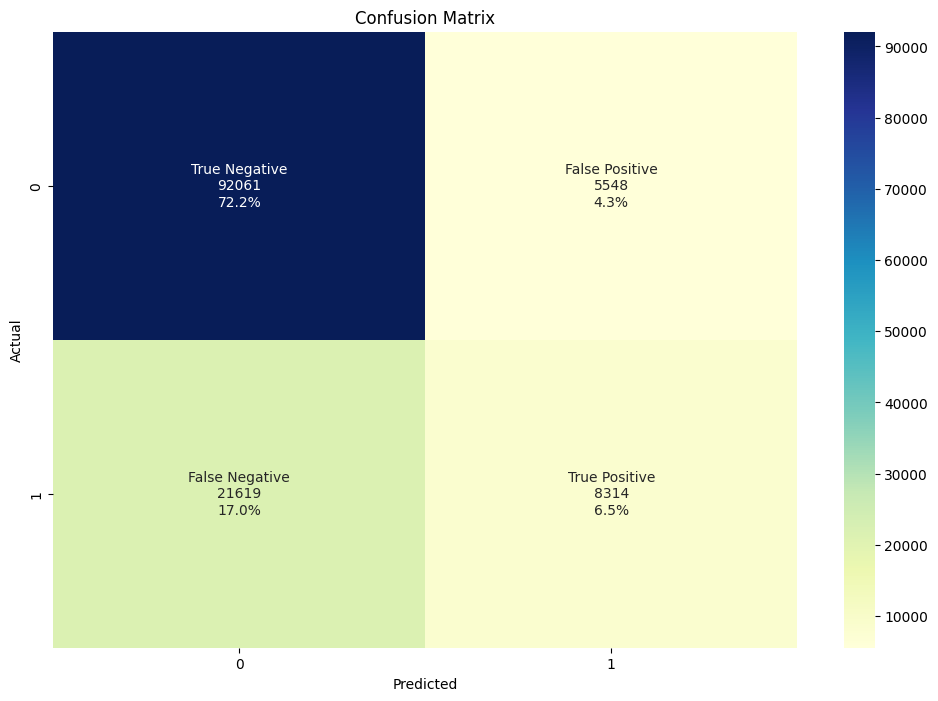

Всего предсказаний: 127542

Правильно предсказанные ответы (Accuracy): 0.787
Ошибки в прогнозах: 0.213

Recall: 0.2778
Precision: 0.5998

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 92061 правильных ответов. Не оплаченая заявка определена правильно.
  - TP в правом нижнем углу. 8314 правильных ответов. Оплаченая заявка определена правильно.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 5548 ошибок ошибочных предсказаний первого рода. Модель определила неоплаченные заявки как оплаченные.
  - FN в левом нижнем углу. 21619 ошибочных предсказаний второго рода. Модель определила оплаченные заявки как не оплаченные.


In [68]:
report.drow_confusion_matrix(
    model=model_lgbm, features=features_test_best, target=target_test
)

**После Optuna**

Матрица ошибок



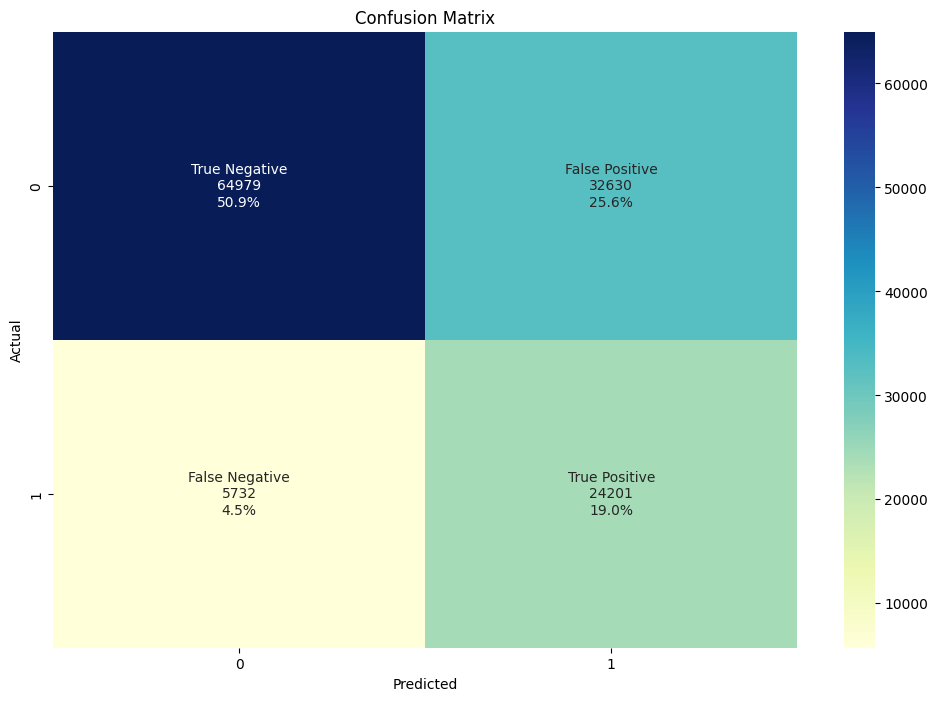

Всего предсказаний: 127542

Правильно предсказанные ответы (Accuracy): 0.6992
Ошибки в прогнозах: 0.3008

Recall: 0.8085
Precision: 0.4258

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 64979 правильных ответов. Не оплаченая заявка определена правильно.
  - TP в правом нижнем углу. 24201 правильных ответов. Оплаченая заявка определена правильно.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 32630 ошибок ошибочных предсказаний первого рода. Модель определила неоплаченные заявки как оплаченные.
  - FN в левом нижнем углу. 5732 ошибочных предсказаний второго рода. Модель определила оплаченные заявки как не оплаченные.


In [69]:
report.drow_confusion_matrix(
    model=best_model, features=features_test_best, target=target_test
)

Согласно ТЗ:
- заказчик толерантен к ошибке пресижн оплаченных заявок, то есть норм, если модель будет показывать больше заявок как хороших, чем на самом деле.
- заказчик не толерантен к низкому пресижн неоплаченных заявок, то есть не хотят модель, которая относит потенциально оплаченные заявки к плохим заявкам.

Поэтому вариант с `is_unbalance": True` предпочтительнее, так как модель видит больше оплаченных и неоплаченные относит в оплаченные.

### Precision-Recall кривая

PR-кривая

Лучший Threshold = 0.59


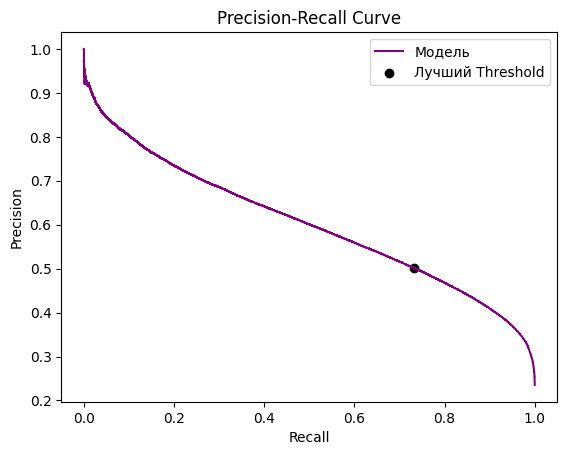

In [70]:
report.drow_pr_curve(
    model=best_model, features=features_train_best, target=target_train, treshold=True
)

Регулировку `Threshold` делать смысла нету, т.к. это может изменить в худшую сторону `False Negative`.

### Важность признаков

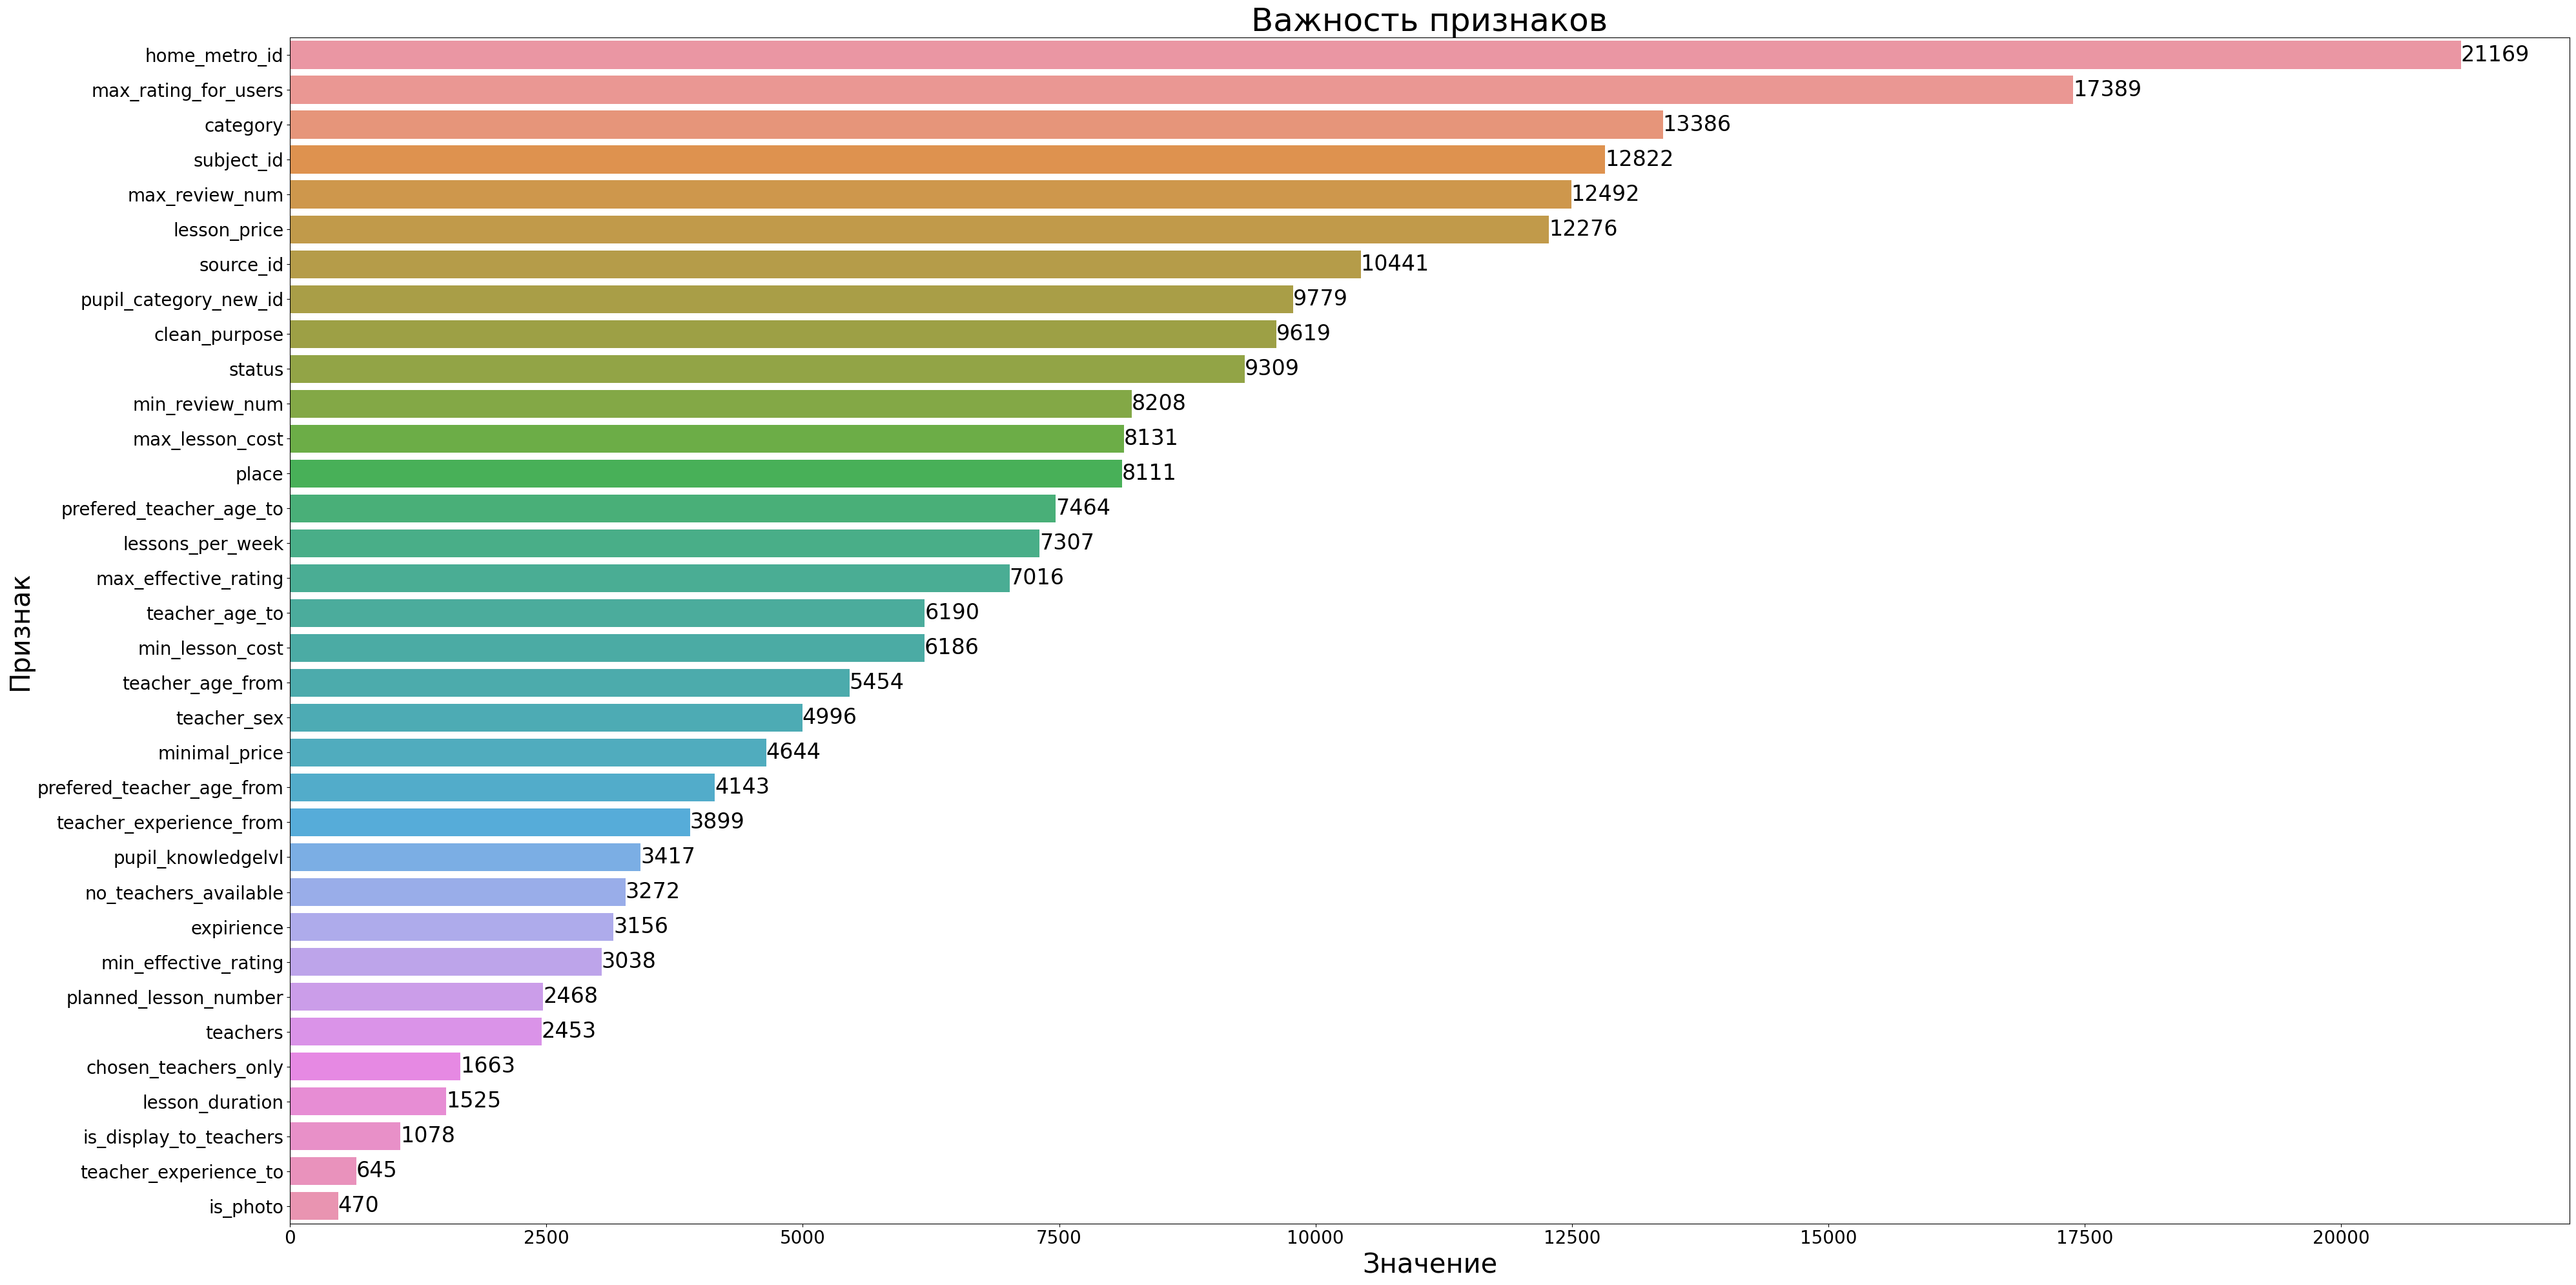

In [71]:
report.plot_importance(
    model=best_model, features=features_train_best, fig_size=(40, 20)
)

Как показал отбор `SBS` и это видно из графика все признаки из набора имеют ту или иную важность.

Как ни странно самый важный это `home_metro_id` хотя метро есть не во всех городах.
Помимо этого в важности фичей с достаточно высокими значениями есть сгененрированные фичи из столбцов `purpose` и `add_info`. Плюс ко всему в десятке есть агрегированные портретные признаки учителей. Можно счетлать вывод, что наличие доступного учителя с теми или иными характеристиками влияет на оплату.

### Калибровка

In [72]:
best_model_calibrator, _, _, _ = modelling.get_test_results(
    model=model,
    features_train=features_train_best,
    target_train=target_train,
    features_test=features_test_best,
    target_test=target_test,
    calibrator=True,
)

Метрика AUC-ROC модели на тестовой выборке без калибровки: 0.812272
              precision    recall  f1-score   support

           0       0.92      0.67      0.77     97609
           1       0.43      0.81      0.56     29933

    accuracy                           0.70    127542
   macro avg       0.67      0.74      0.66    127542
weighted avg       0.80      0.70      0.72    127542

Метрика AUC-ROC модели на тестовой выборке после калибровки: 0.812272
              precision    recall  f1-score   support

           0       0.83      0.90      0.87     97609
           1       0.56      0.41      0.47     29933

    accuracy                           0.79    127542
   macro avg       0.69      0.65      0.67    127542
weighted avg       0.77      0.79      0.77    127542

Время выполнения: 596.84 секунд(ы)


Матрица ошибок



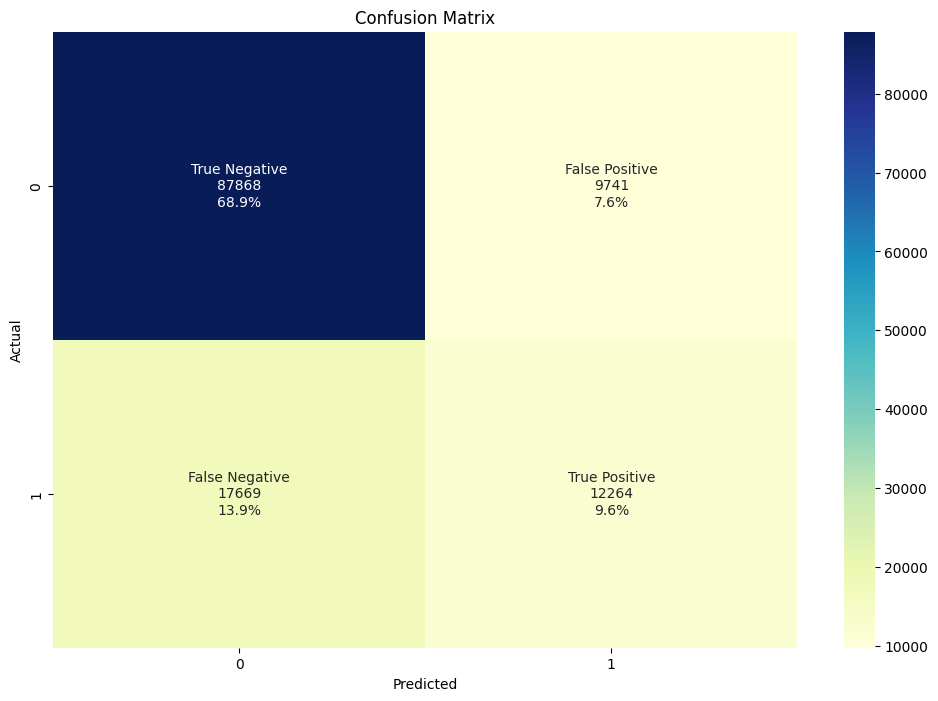

Всего предсказаний: 127542

Правильно предсказанные ответы (Accuracy): 0.7851
Ошибки в прогнозах: 0.2149

Recall: 0.4097
Precision: 0.5573

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 87868 правильных ответов. Не оплаченая заявка определена правильно.
  - TP в правом нижнем углу. 12264 правильных ответов. Оплаченая заявка определена правильно.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 9741 ошибок ошибочных предсказаний первого рода. Модель определила неоплаченные заявки как оплаченные.
  - FN в левом нижнем углу. 17669 ошибочных предсказаний второго рода. Модель определила оплаченные заявки как не оплаченные.


In [73]:
report.drow_confusion_matrix(
    model=best_model_calibrator, features=features_test_best, target=target_test
)

Калибровщик к сожалению ухудшил `False Negative`, а это заказчику не очень нужно.

## Вывод

В результате иссдедвания была опробована гипотеза прогнозирования на агрегированной заявке по идентификатору клиента и идентификатору первой заявки на обучение совмество со сводным портретом репетиторов
автоматически одобренных системой. Выбран вариант автоматического одобрения так как суть задачи состоит в том, чтобы предсказать возможность оплаты заявки до обработки операторами и внесения дополнительных изменений в заявку.

На предсказания хорошо влияют дополнительно сгенерированные признаки, такие как:
- место проведения занятий,
- категория ученика,
- цель занятий,
- опят репетитора,
- возраст репетитора,
- статус репетитора.

Эти признаки были выделены из тектовых комментарием.
Вполне возможно, что стоит их выделить в отдельные поля при заполнение заявок и соответвенно в отдельные поля БД.

Как часто бывает ученики, но и репетиторов тоже касается заполняют числовые поля абы как. Тут впринципе можно тоже ограничить возможность такого ввода. Более адекватные данные могут положительно повлиять на модель.

В результате моделирования была получена достаточно высока метрика `ROC-AUC` - **0.812272**. 

Согласно ТЗ:
- заказчик толерантен к ошибке пресижн оплаченных заявок, то есть норм, если модель будет показывать больше заявок как хороших, чем на самом деле.
- заказчик не толерантен к низкому пресижн неоплаченных заявок, то есть не хотят модель, которая относит потенциально оплаченные заявки к плохим заявкам.

Модель настроена на лучшее прогнозирование оплаченных заявок, то есть имеет высокий `Recall` - **0.8085**.